# Header

In [14]:
from utils import *
from plot import plot_enrich, patchplot
from scipy.stats import ks_2samp

In [2]:
!ls ../data/pySCENIC/

AucMg.csv	    HEK293_motifs.csv	 MCF7_motifs.csv    T47D KO_auc_mtx.csv
BCK4_auc_mtx.csv    Jaccard_FDRDict.pkl  MM134_auc_mtx.csv  T47D KO_motifs.csv
BCK4_motifs.csv     Jaccard_KSDict.pkl	 MM134_motifs.csv   T47D WT_auc_mtx.csv
BinAucMg.csv	    MCF10A_auc_mtx.csv	 ref		    T47D WT_motifs.csv
BinBulkAucMg.csv    MCF10A_motifs.csv	 SUM44_auc_mtx.csv
HEK293_auc_mtx.csv  MCF7_auc_mtx.csv	 SUM44_motifs.csv


# SCENIC
## AUCell scores

In [3]:
import pandas as pd 
CellTypes = ['MCF7','T47D WT','T47D KO',  'MM134','SUM44','BCK4',  'MCF10A', 'HEK293'] 
for n, cell in enumerate(CellTypes):
    
    auc = pd.read_csv('../data/pySCENIC/%s_auc_mtx.csv'%cell, index_col=0).T # gene x cells
    auc.index = [col.strip('(+)') for col in auc.index]
    print(cell, '%d genes %d cells'%(auc.shape[0], auc.shape[1]))
    auc_mg = auc if n==0 else auc_mg.join(auc, how='inner')
    
auc_mg = auc_mg.T
print(auc_mg.shape)
auc_mg.head(3)

MCF7 264 genes 977 cells
T47D WT 264 genes 509 cells
T47D KO 265 genes 491 cells
MM134 266 genes 439 cells
SUM44 296 genes 314 cells
BCK4 285 genes 512 cells
MCF10A 302 genes 491 cells
HEK293 295 genes 881 cells
(4614, 60)


ATF1      ATF3      ATF4  ATF6B  BACH1   BHLHE40  \
Cell                                                                          
AL1:AAAGGGCCAGCAATTCx  0.093687  0.021922  0.403083    0.0    0.0  0.052082   
AL1:AACAAAGGTTGAATCCx  0.093025  0.028635  0.339407    0.0    0.0  0.052928   
AL1:AAAGTGACAGACTCTAx  0.085527  0.029396  0.365364    0.0    0.0  0.049582   

                           BRF2     CEBPB     CEBPG     CEBPZ  ...       SRF  \
Cell                                                           ...             
AL1:AAAGGGCCAGCAATTCx  0.036763  0.095552  0.082768  0.069588  ...  0.025053   
AL1:AACAAAGGTTGAATCCx  0.043632  0.102575  0.079513  0.064178  ...  0.031093   
AL1:AAAGTGACAGACTCTAx  0.038306  0.101363  0.095266  0.068908  ...  0.024251   

                            TBP     TEAD2     TFDP1     THAP1    THAP11  \
Cell                                                                      
AL1:AAAGGGCCAGCAATTCx  0.063955  0.066794  0.073970  0.042495  0.074736   
AL1:AACAAAGGTTGAATCCx  0.188478  0.046347  0.078197  0.051469  0.068505   
AL1:AAAGTGACAGACTCTAx  0.193369  0.046039  0.082745  0.050827  0.074520   

                           USF1      USF2       YY1  ZBTB7A  
Cell                                                         
AL1:AAAGGGCCAGCAATTCx  0.024788  0.075857  0.075142     0.0  
AL1:AACAAAGGTTGAATCCx  0.030055  0.078550  0.077915     0.0  
AL1:AAAGTGACAGACTCTAx  0.017459  0.078470  0.076929     0.0  

[3 rows x 60 columns]

In [4]:
auc_mg.to_csv('../data/pySCENIC/AucMg.csv')

In [18]:
fpath = '../data/scVelo/AL1.h5ad'
AL1 = anndata.read_h5ad(fpath)

## Binarization

In [6]:
def plot_binarization(auc_mtx: pd.DataFrame, regulon_name: str, threshold=None, bins: int=100, ax=None) -> None:
    """
    Plot the "binarization" process for the given regulon.

    :param auc_mtx: The dataframe with the AUC values for all cells and regulons (n_cells x n_regulons).
    :param regulon_name: The name of the regulon.
    :param bins: The number of bins to use in the AUC histogram.
    :param threshold: The threshold to use for binarization.
    """
    from skimage.filters import threshold_minimum

    if ax is None:
        ax=plt.gca()
    x = auc_mtx[regulon_name].values
    auc_mtx[regulon_name].hist(bins=bins,ax=ax)
    ylim = ax.get_ylim()
    
    try:
        threshold = threshold_minimum(x, nbins=bins)
        ax.plot([threshold]*2, ylim, 'r:')
    except:
        threshold = None 
        print('Unable to generate threshold for %s'%regulon_name)
    
    ax.set_ylim(ylim)
#     ax.set_xlabel('AUC')
#     ax.set_ylabel('#')
    ax.set_title(regulon_name, fontsize=30)
    
    return threshold

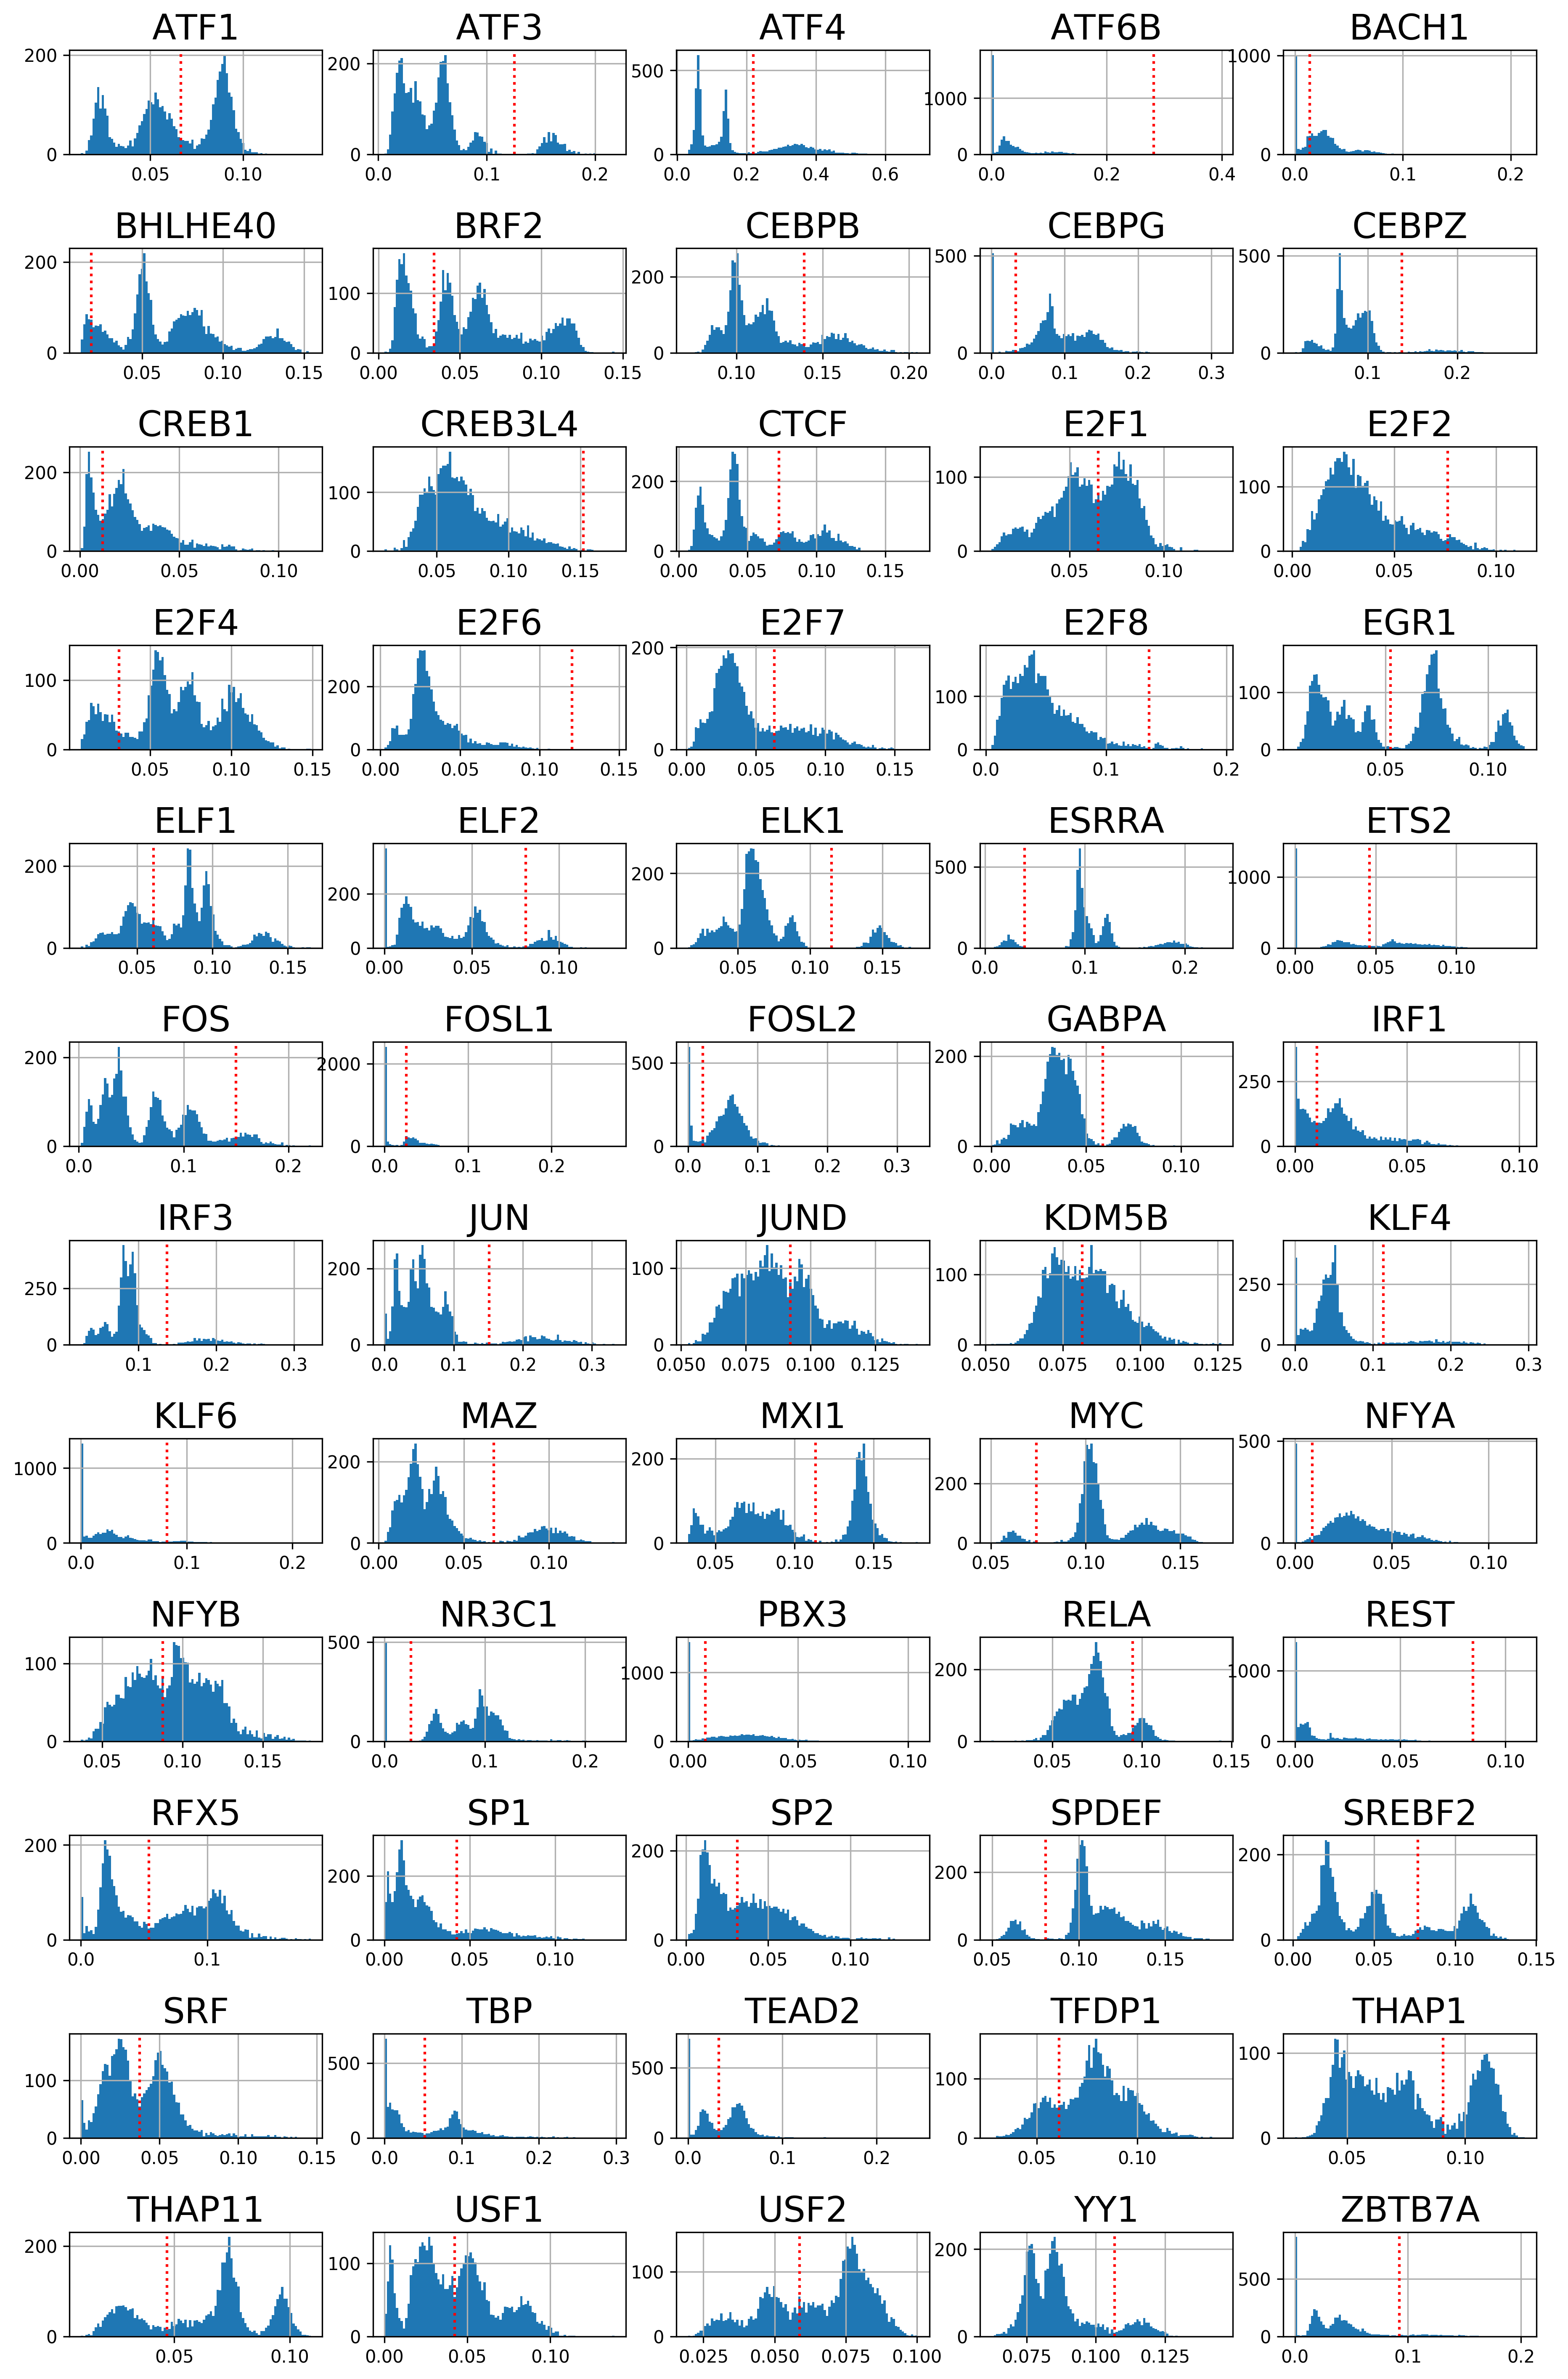

In [8]:
nplots = len(auc_mg.columns)
ncols = 5
nrows = ceil(nplots/ncols)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3, nrows*2), dpi=300)
plt.subplots_adjust(wspace=0.2, hspace=0.9) # 
axes_list = axes.flatten()

X_raw = auc_mg.values # obs x var
X = np.log2(X_raw/np.sum(X_raw, axis=1, keepdims=True) + 1)
tf_thr = {}

for n, tf in enumerate(auc_mg.columns):
    ax = axes_list[n]
    x = X_raw[:, n]
    tf_thr[tf] = plot_binarization(auc_mg, tf, ax=ax)  # auc_mg (raw data) 
    ax.set_title(tf, fontsize=20)
    
# plt.savefig('../Figure/Fig5/BinaryThresHist.png', dpi=300)

In [9]:
# binarize
tf_sel = [k for k in tf_thr.keys() if tf_thr[k] is not None]
auc_sel = auc_mg.loc[:, tf_sel]

X_raw = auc_sel.values # obs x var
X = np.log2(X_raw/np.sum(X_raw, axis=1, keepdims=True) + 1)
Xb = np.empty(auc_sel.shape)

for n, tf in enumerate(tf_sel):
    v = X_raw[:,n]
    thr = tf_thr[tf]
    
    vb = np.array([1 if i>thr else 0 for i in v])
    Xb[:,n] = vb
    
print(auc_mg.shape, Xb.shape)

Xb_df = pd.DataFrame(Xb, columns=tf_sel, index=auc_sel.index)
Xb_df.head(3)
Xb_df.to_csv('../data/pySCENIC/BinAucMg.csv')

(4614, 60) (4614, 60)


In [10]:
sns.set(context='paper', style='whitegrid', palette='deep', font='sans-serif', 
font_scale=.8, color_codes=True)

mpl.style.use('NaturePub')

In [15]:
Xb_df 

ATF1  ATF3  ATF4  ATF6B  BACH1  BHLHE40  BRF2  CEBPB  \
Cell                                                                          
AL1:AAAGGGCCAGCAATTCx   1.0   0.0   1.0    0.0    0.0      1.0   1.0    0.0   
AL1:AACAAAGGTTGAATCCx   1.0   0.0   1.0    0.0    0.0      1.0   1.0    0.0   
AL1:AAAGTGACAGACTCTAx   1.0   0.0   1.0    0.0    0.0      1.0   1.0    0.0   
AL1:AAACGCTGTCTACAACx   1.0   0.0   1.0    0.0    0.0      1.0   0.0    0.0   
AL1:AACAAAGGTCAAAGATx   1.0   0.0   1.0    0.0    1.0      1.0   1.0    0.0   
...                     ...   ...   ...    ...    ...      ...   ...    ...   
AL1:TTTATGCAGTAGTCCTx   0.0   0.0   0.0    0.0    1.0      0.0   0.0    0.0   
AL1:TTTACGTCATAAGCAAx   0.0   0.0   0.0    0.0    1.0      0.0   0.0    0.0   
AL1:TTTGACTCAGTTTGGTx   0.0   0.0   0.0    0.0    1.0      0.0   0.0    0.0   
AL1:TTTGGAGCAGGCTTGCx   0.0   0.0   0.0    0.0    1.0      1.0   0.0    0.0   
AL1:TTTGTTGTCGCCGTGAx   0.0   0.0   0.0    0.0    1.0      1.0   0.0    0.0   

                       CEBPG  CEBPZ  ...  SRF  TBP  TEAD2  TFDP1  THAP1  \
Cell                                 ...                                  
AL1:AAAGGGCCAGCAATTCx    1.0    0.0  ...  0.0  1.0    1.0    1.0    0.0   
AL1:AACAAAGGTTGAATCCx    1.0    0.0  ...  0.0  1.0    1.0    1.0    0.0   
AL1:AAAGTGACAGACTCTAx    1.0    0.0  ...  0.0  1.0    1.0    1.0    0.0   
AL1:AAACGCTGTCTACAACx    1.0    0.0  ...  0.0  0.0    1.0    1.0    0.0   
AL1:AACAAAGGTCAAAGATx    1.0    0.0  ...  0.0  0.0    1.0    1.0    0.0   
...                      ...    ...  ...  ...  ...    ...    ...    ...   
AL1:TTTATGCAGTAGTCCTx    1.0    0.0  ...  0.0  1.0    0.0    1.0    1.0   
AL1:TTTACGTCATAAGCAAx    1.0    0.0  ...  0.0  1.0    0.0    1.0    1.0   
AL1:TTTGACTCAGTTTGGTx    1.0    0.0  ...  0.0  1.0    0.0    1.0    1.0   
AL1:TTTGGAGCAGGCTTGCx    1.0    0.0  ...  0.0  1.0    0.0    1.0    1.0   
AL1:TTTGTTGTCGCCGTGAx    1.0    0.0  ...  0.0  1.0    0.0    1.0    1.0   

                       THAP11  USF1  USF2  YY1  ZBTB7A  
Cell                                                    
AL1:AAAGGGCCAGCAATTCx     1.0   0.0   1.0  0.0     0.0  
AL1:AACAAAGGTTGAATCCx     1.0   0.0   1.0  0.0     0.0  
AL1:AAAGTGACAGACTCTAx     1.0   0.0   1.0  0.0     0.0  
AL1:AAACGCTGTCTACAACx     1.0   0.0   1.0  0.0     0.0  
AL1:AACAAAGGTCAAAGATx     1.0   0.0   1.0  0.0     0.0  
...                       ...   ...   ...  ...     ...  
AL1:TTTATGCAGTAGTCCTx     1.0   1.0   1.0  0.0     0.0  
AL1:TTTACGTCATAAGCAAx     1.0   0.0   1.0  0.0     0.0  
AL1:TTTGACTCAGTTTGGTx     1.0   1.0   1.0  0.0     0.0  
AL1:TTTGGAGCAGGCTTGCx     1.0   1.0   1.0  0.0     0.0  
AL1:TTTGTTGTCGCCGTGAx     1.0   1.0   1.0  0.0     0.0  

[4614 rows x 60 columns]

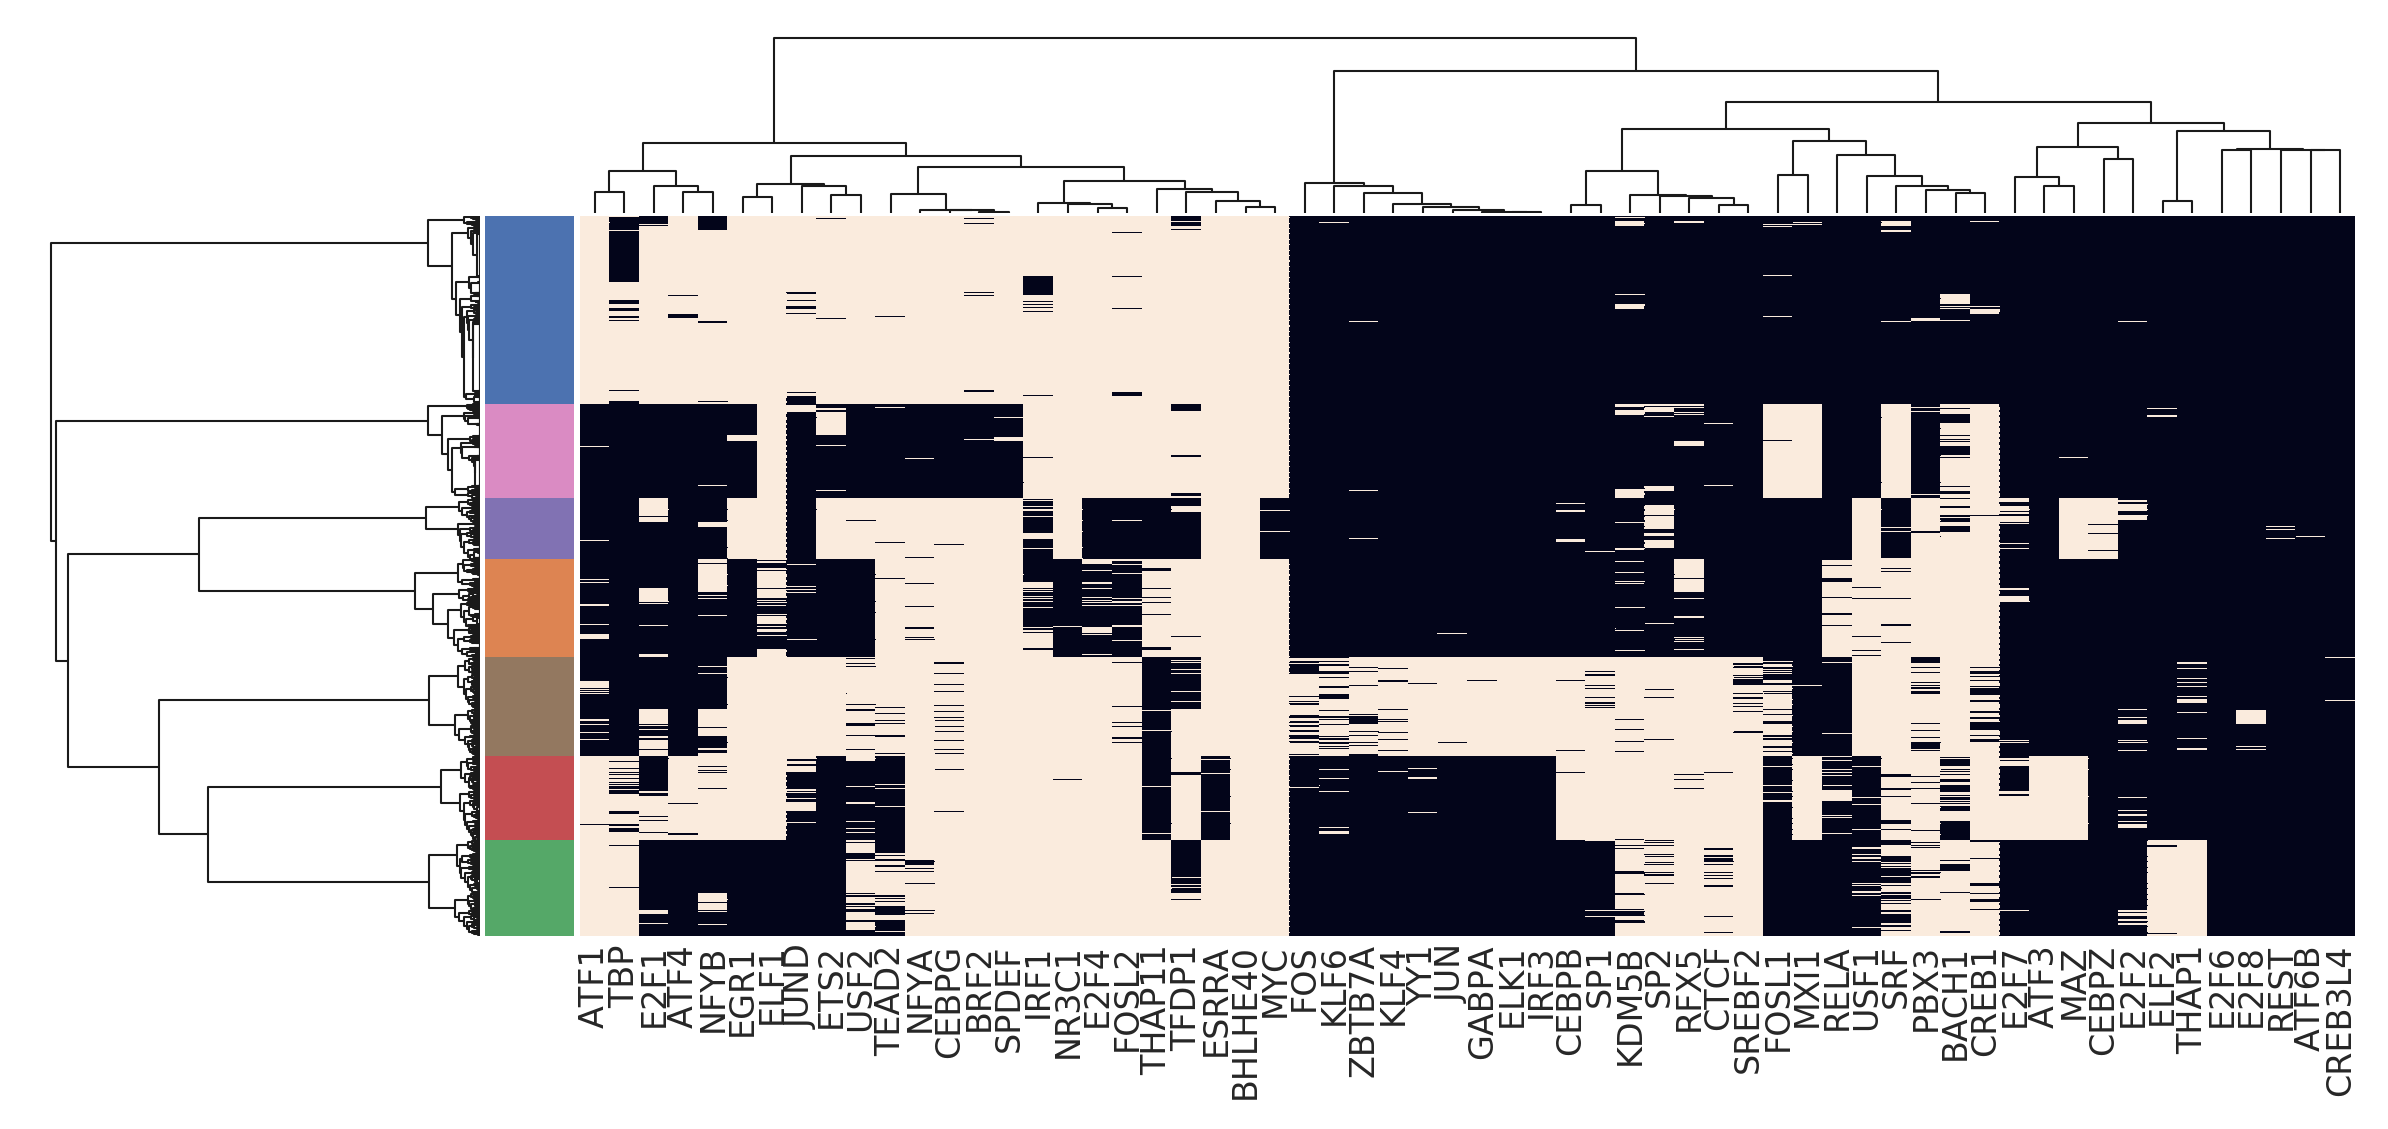

In [37]:
breast_cells = AL1[AL1.obs['CellType'] != 'HEK293'].obs.index  
Xb_df_sel = Xb_df.loc[breast_cells, :]
AL1_sel = AL1[AL1.obs['CellType'] != 'HEK293']

CellTypeMapper = AL1_sel.obs['CellType']
types = np.array(AL1_sel.obs['CellType'].dtype.categories)
clist_types = sns.color_palette(palette='deep', desat=1)
row_colors = [clist_types[np.where(types==CellTypeMapper[bc])[0][0]] for bc in Xb_df_sel.index]

g = sns.clustermap(Xb_df_sel.values, figsize=(10, 4), method='ward', metric='jaccard', 
                   row_colors=row_colors,
                   width_colors_ratio=0.04)

xlabels = Xb_df.columns[np.array(g.dendrogram_col.reordered_ind)]
g.ax_heatmap.set_xticks([x+0.5 for x in range(len(xlabels))])
g.ax_heatmap.set_xticklabels(xlabels, rotation=90, fontsize=8)

g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels('')

cbar = g.cax
cbar.set_visible(False)

In [33]:
g.savefig('../Figure/Fig5/BinaryHeatmap.png', dpi=300)

In [92]:
!mv ../Figure/Fig4/BinaryHeatmap.png ../Figure/Fig5/BinaryHeatmap.png

## Jaccard

In [47]:
sns.set(context='paper', style='whitegrid', palette='deep', font='sans-serif', 
font_scale=1.2, color_codes=True)

10642191 (4614, 4614)


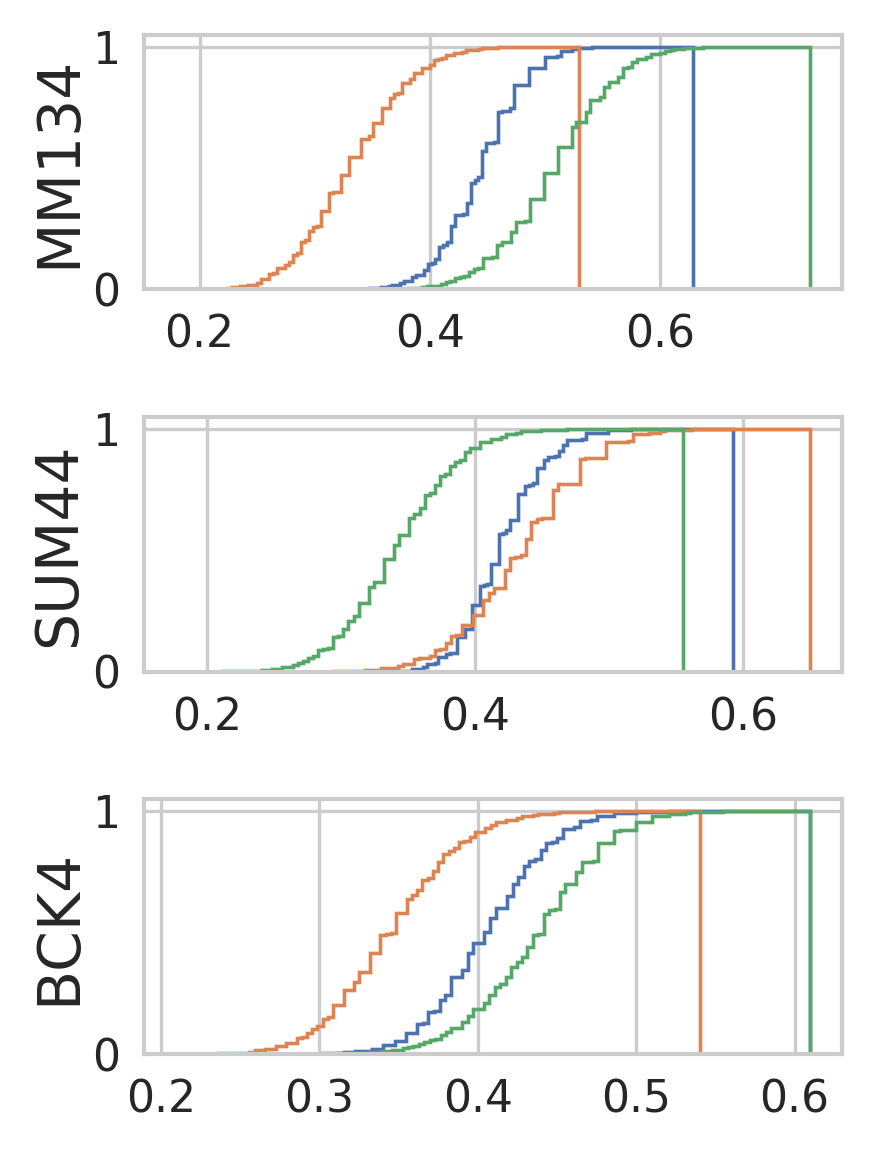

In [52]:
from scipy.spatial.distance import squareform, pdist

adata = AL1[AL1.obs['CellType'] != 'HEK293']
meta = adata.obs.loc[list(Xb_df.index),:]

refs = ['MM134','SUM44','BCK4'] # without HEK293
queries = ['MCF7', 'T47D WT', 'T47D KO']

nplots = len(refs)
ncols = 1
nrows = ceil(nplots/ncols)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3, nrows*1.5), dpi=300)
plt.subplots_adjust(wspace=0.1, hspace=0.5) # pdist is unique while squareform makes it redundant
axes_list = axes.flatten()

clist = sns.color_palette(palette='deep', desat=1)
D = 1 - squareform(pdist(Xb, 'jaccard')) # Jaccard index
print(len(pdist(Xb, 'jaccard')), D.shape)

k = -1
AucVec = []
for m, i in enumerate(refs):
    k += 1
    ax = axes_list[k]
    AucVec_tmp = []
    
    for n, j in enumerate(queries):    
        
        idx_i = (meta['CellType'] == i).values
        idx_j = (meta['CellType'] == j).values
        
        
        sel = D[idx_i,:][:,idx_j].flatten()
        AucVec_tmp.append(sel)
        
        n, bins, patches = ax.hist(sel, 100, density=True, histtype='step', cumulative=True, color=clist[n])
        ax.hist(sel, bins=bins, histtype='step', cumulative=True, density=True, label=j)
#     ax.set_xlim(0,1.02)
    ax.set_ylabel(i, fontsize=14)

    AucVec.append(np.array(AucVec_tmp))

plt.savefig('../Figure/Fig5/JaccardIndex_BinRegulonActivation.pdf')

In [60]:
from scipy.stats import *
from statsmodels.stats.multitest import multipletests

FDR_Dict = {}
KS_Dict = {}

for k,X in enumerate(AucVec):
    cell = refs[k]
    KS = np.empty((len(queries),len(queries)))
    Pvals = np.empty((len(queries),len(queries)))

    for i,U in enumerate(X):
        for j,V in enumerate(X):
            ks, p = ks_2samp(U, V)
            KS[i,j] = ks
            Pvals[i,j] = p
    
    KS_df = pd.DataFrame(KS, index=queries, columns=queries)
    KS_Dict[cell] = KS_df
    
    FDR_df = multipletests(Pvals.flatten())[1].reshape((len(queries),len(queries)))
    FDR_df = pd.DataFrame(FDR_df, index=queries, columns=queries)
    FDR_Dict[cell] = FDR_df 


In [61]:
fname = 'Jaccard_FDRDict'
f = open("../data/pySCENIC/%s.pkl"%(fname),"wb")
pickle.dump(FDR_Dict, f)
f.close()

In [62]:
fname = 'Jaccard_KSDict'
f = open("../data/pySCENIC/%s.pkl"%(fname),"wb")
pickle.dump(KS_Dict, f)
f.close()

In [65]:
for cell in refs:
    print(KS_Dict[cell],FDR_Dict[cell])

             MCF7   T47D WT   T47D KO
MCF7    -0.000000  0.834764  0.589168
T47D WT  0.834764 -0.000000  0.937659
T47D KO  0.589168  0.937659 -0.000000          MCF7  T47D WT  T47D KO
MCF7      1.0      0.0      0.0
T47D WT   0.0      1.0      0.0
T47D KO   0.0      0.0      1.0
             MCF7   T47D WT   T47D KO
MCF7    -0.000000  0.283711  0.773287
T47D WT  0.283711 -0.000000  0.729901
T47D KO  0.773287  0.729901 -0.000000          MCF7  T47D WT  T47D KO
MCF7      1.0      0.0      0.0
T47D WT   0.0      1.0      0.0
T47D KO   0.0      0.0      1.0
             MCF7   T47D WT   T47D KO
MCF7    -0.000000  0.610312  0.338663
T47D WT  0.610312 -0.000000  0.764361
T47D KO  0.338663  0.764361 -0.000000          MCF7  T47D WT  T47D KO
MCF7      1.0      0.0      0.0
T47D WT   0.0      1.0      0.0
T47D KO   0.0      0.0      1.0


## Bulk

In [67]:
BinAuc = pd.read_csv('../data/pySCENIC/BinAucMg.csv', index_col=0)

BinAucDict = {}
CellTypes = ['MCF7','T47D WT','T47D KO',    'MM134','SUM44','BCK4',    'MCF10A',   'HEK293'] 
for cell in CellTypes:
    cells = AL1.obs.index[AL1.obs['CellType']==cell]
    BinSel = BinAuc.loc[cells,:].values
    v = (np.mean(BinSel, axis=0)>0.5) * 1
    BinAucDict[cell] = v
    
BinBulk = pd.DataFrame(BinAucDict)
BinBulk.index = auc_mg.columns
BinBulk

MCF7  T47D WT  T47D KO  MM134  SUM44  BCK4  MCF10A  HEK293
ATF1        1        0        1      1      0     0       0       0
ATF3        0        0        0      1      0     0       0       0
ATF4        1        0        0      1      0     0       0       0
ATF6B       0        0        0      0      0     0       0       0
BACH1       0        1        1      0      1     1       1       1
BHLHE40     1        1        1      1      1     1       1       1
BRF2        1        1        1      1      1     1       0       0
CEBPB       0        0        0      1      0     1       0       0
CEBPG       1        1        1      1      1     1       0       1
CEBPZ       0        0        0      0      1     0       0       0
CREB1       0        1        1      1      1     1       1       1
CREB3L4     0        0        0      0      0     0       0       0
CTCF        0        0        1      1      0     1       0       0
E2F1        1        0        0      0      0     0       0       1
E2F2        0        0        0      0      0     0       0       0
E2F4        1        0        1      1      0     1       1       1
E2F6        0        0        0      0      0     0       0       0
E2F7        0        0        0      1      0     0       0       1
E2F8        0        0        0      0      0     0       0       0
EGR1        1        0        0      1      1     1       0       0
ELF1        1        1        0      1      1     1       1       0
ELF2        0        0        1      0      0     0       0       0
ELK1        0        0        0      0      0     1       0       0
ESRRA       1        1        1      0      1     1       1       1
ETS2        1        0        0      0      1     1       0       0
FOS         0        0        0      0      0     1       0       0
FOSL1       0        0        0      0      0     1       1       1
FOSL2       1        0        1      1      0     1       1       1
GABPA       0        0        0      0      0     1       0       0
IRF1        1        0        1      1      0     1       1       0
IRF3        0        0        0      0      0     1       0       0
JUN         0        0        0      0      0     1       0       0
JUND        1        0        0      0      0     1       0       0
KDM5B       0        0        1      1      0     1       0       1
KLF4        0        0        0      0      0     1       0       0
KLF6        0        0        0      0      0     1       0       0
MAZ         0        0        0      1      1     0       0       0
MXI1        0        0        0      1      0     0       1       1
MYC         1        1        1      1      0     1       1       1
NFYA        1        1        1      1      1     1       0       1
NFYB        1        0        0      1      0     0       0       1
NR3C1       1        0        1      1      1     1       1       1
PBX3        0        1        1      1      1     1       0       1
RELA        0        1        0      0      0     0       0       0
REST        0        0        0      0      0     0       0       0
RFX5        0        0        1      1      0     1       0       1
SP1         0        0        0      1      0     1       0       0
SP2         0        0        1      1      1     1       0       1
SPDEF       1        1        1      1      1     1       0       1
SREBF2      0        0        1      1      0     1       0       0
SRF         0        1        0      1      0     1       1       0
TBP         1        0        1      1      0     0       0       1
TEAD2       1        1        1      0      1     1       0       0
TFDP1       1        1        0      1      0     1       1       1
THAP1       0        0        1      0      0     0       0       1
THAP11      1        1        1      0      0     0       1       1
USF1        0        1        0      0      1     1       0       1
USF2        1        0        1      0      1     1       0      

In [68]:
BinBulk.to_csv('../data/pySCENIC/BinBulkAucMg.csv')

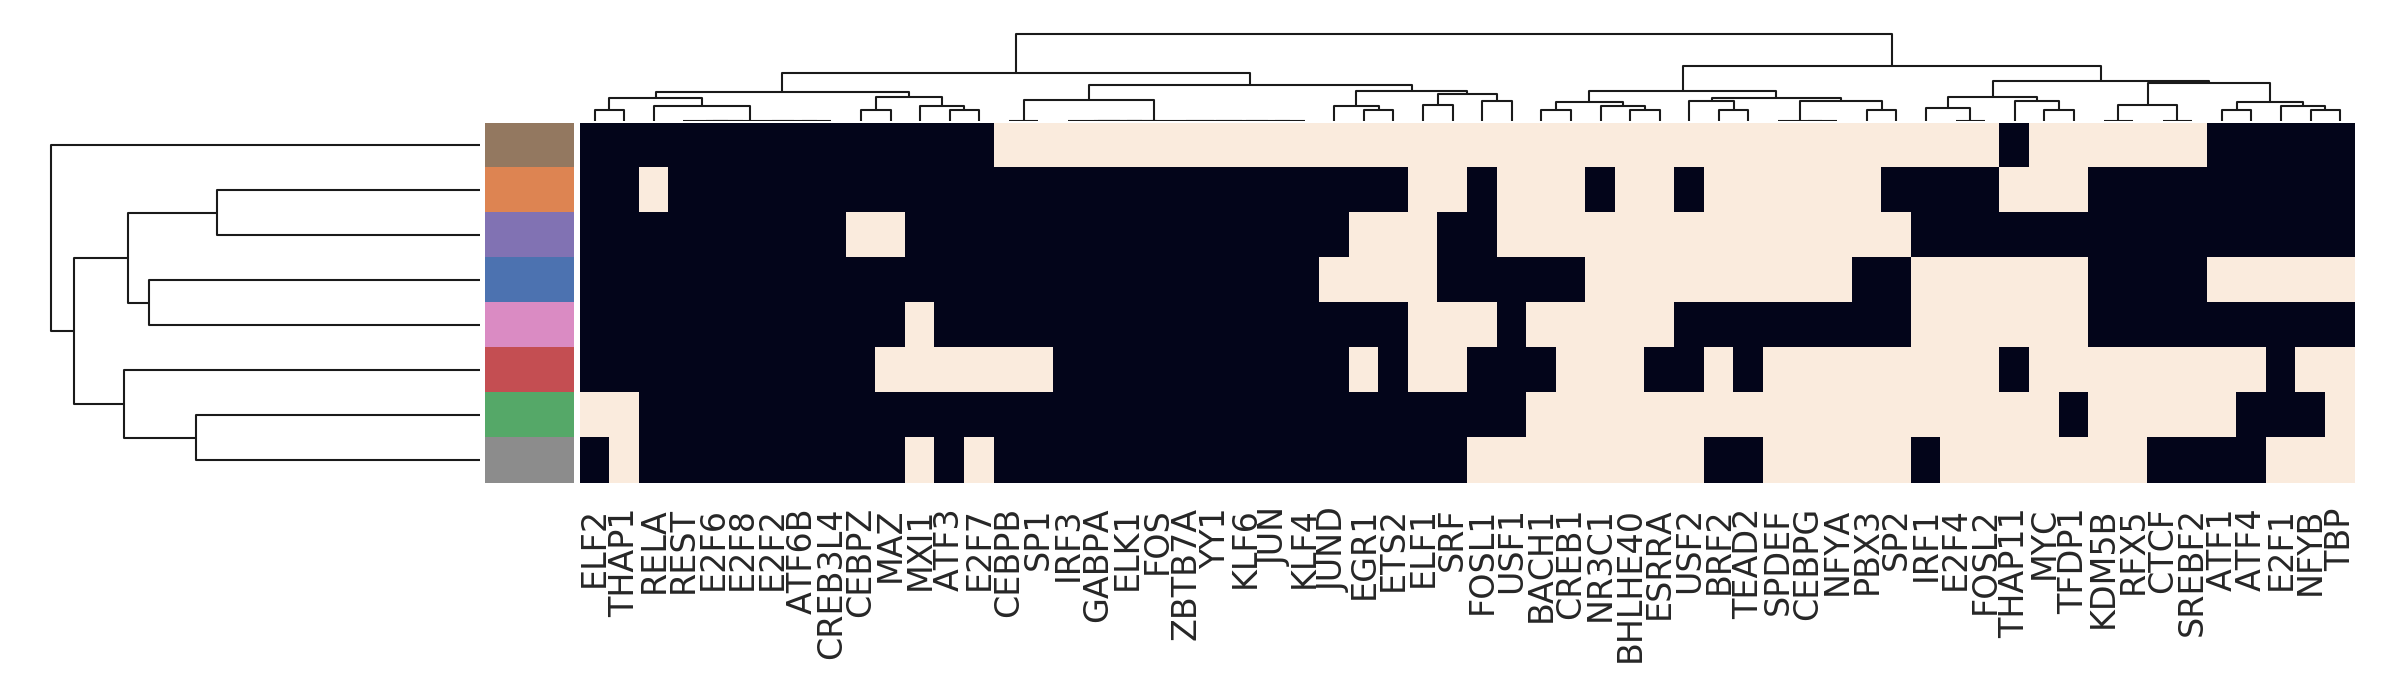

In [72]:
clist = sns.color_palette(palette='deep', desat=1)

g = sns.clustermap(BinBulk.values.T, figsize=(10, 2), method='ward', metric='euclidean', 
                   row_colors=clist[:8],                   
                   width_colors_ratio=0.04)
xlabels = BinBulk.index[np.array(g.dendrogram_col.reordered_ind)]
g.ax_heatmap.set_xticks([x+0.5 for x in range(len(xlabels))])
g.ax_heatmap.set_xticklabels(xlabels, rotation=90, fontsize=8)

g.ax_heatmap.set_yticks([])
g.ax_heatmap.set_yticklabels('')

g.cax.set_visible(False)

In [73]:
g.savefig('../Figure/Fig5/BinBulk.png', dpi=300)

# KO activated regulons

In [5]:
BinBulk = pd.read_csv('../data/pySCENIC/BinBulkAucMg.csv', index_col=0)

In [6]:
BinBulk 

MCF7  T47D WT  T47D KO  MM134  SUM44  BCK4  MCF10A  HEK293
ATF1        1        0        1      1      0     0       0       0
ATF3        0        0        0      1      0     0       0       0
ATF4        1        0        0      1      0     0       0       0
ATF6B       0        0        0      0      0     0       0       0
BACH1       0        1        1      0      1     1       1       1
BHLHE40     1        1        1      1      1     1       1       1
BRF2        1        1        1      1      1     1       0       0
CEBPB       0        0        0      1      0     1       0       0
CEBPG       1        1        1      1      1     1       0       1
CEBPZ       0        0        0      0      1     0       0       0
CREB1       0        1        1      1      1     1       1       1
CREB3L4     0        0        0      0      0     0       0       0
CTCF        0        0        1      1      0     1       0       0
E2F1        1        0        0      0      0     0       0       1
E2F2        0        0        0      0      0     0       0       0
E2F4        1        0        1      1      0     1       1       1
E2F6        0        0        0      0      0     0       0       0
E2F7        0        0        0      1      0     0       0       1
E2F8        0        0        0      0      0     0       0       0
EGR1        1        0        0      1      1     1       0       0
ELF1        1        1        0      1      1     1       1       0
ELF2        0        0        1      0      0     0       0       0
ELK1        0        0        0      0      0     1       0       0
ESRRA       1        1        1      0      1     1       1       1
ETS2        1        0        0      0      1     1       0       0
FOS         0        0        0      0      0     1       0       0
FOSL1       0        0        0      0      0     1       1       1
FOSL2       1        0        1      1      0     1       1       1
GABPA       0        0        0      0      0     1       0       0
IRF1        1        0        1      1      0     1       1       0
IRF3        0        0        0      0      0     1       0       0
JUN         0        0        0      0      0     1       0       0
JUND        1        0        0      0      0     1       0       0
KDM5B       0        0        1      1      0     1       0       1
KLF4        0        0        0      0      0     1       0       0
KLF6        0        0        0      0      0     1       0       0
MAZ         0        0        0      1      1     0       0       0
MXI1        0        0        0      1      0     0       1       1
MYC         1        1        1      1      0     1       1       1
NFYA        1        1        1      1      1     1       0       1
NFYB        1        0        0      1      0     0       0       1
NR3C1       1        0        1      1      1     1       1       1
PBX3        0        1        1      1      1     1       0       1
RELA        0        1        0      0      0     0       0       0
REST        0        0        0      0      0     0       0       0
RFX5        0        0        1      1      0     1       0       1
SP1         0        0        0      1      0     1       0       0
SP2         0        0        1      1      1     1       0       1
SPDEF       1        1        1      1      1     1       0       1
SREBF2      0        0        1      1      0     1       0       0
SRF         0        1        0      1      0     1       1       0
TBP         1        0        1      1      0     0       0       1
TEAD2       1        1        1      0      1     1       0       0
TFDP1       1        1        0      1      0     1       1       1
THAP1       0        0        1      0      0     0       0       1
THAP11      1        1        1      0      0     0       1       1
USF1        0        1        0      0      1     1       0       1
USF2        1        0        1      0      1     1       0      

In [7]:
# TFs turned on after KO
TFs = BinBulk.index[BinBulk.values[:,2] * (1-BinBulk.values[:,1])==1]
TFs 

Index(['ATF1', 'CTCF', 'E2F4', 'ELF2', 'FOSL2', 'IRF1', 'KDM5B', 'NR3C1',
       'RFX5', 'SP2', 'SREBF2', 'TBP', 'THAP1', 'USF2'],
      dtype='object')

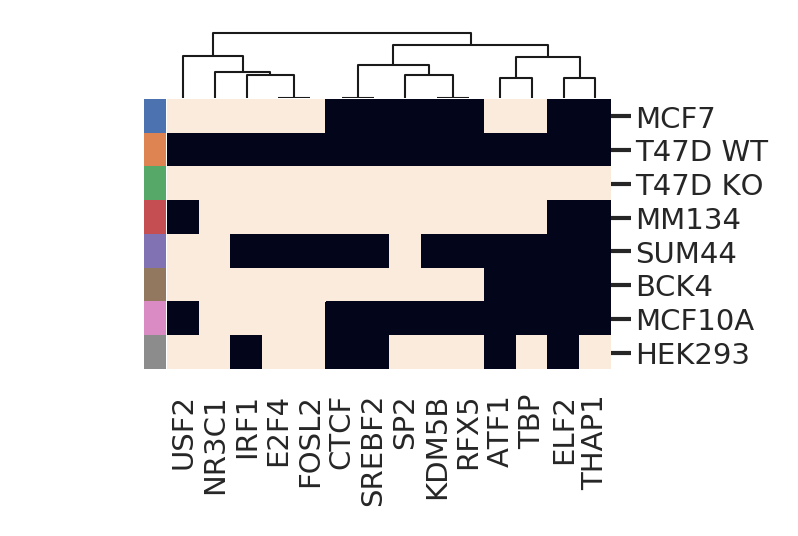

In [90]:
clist = sns.color_palette(palette='deep', desat=1)
df_plot = BinBulk.loc[TFs,:].T

g = sns.clustermap(df_plot, figsize=(2.5, 1.5), method='ward', metric='euclidean', 
                   row_cluster=False,  row_colors=clist[:8],              
                   width_colors_ratio=0.04)
xlabels = df_plot.columns[np.array(g.dendrogram_col.reordered_ind)]
g.ax_heatmap.set_xticks([x+0.5 for x in range(len(xlabels))])
g.ax_heatmap.set_xticklabels(xlabels, rotation=90, fontsize=7)

# ylabels = df_plot.index[np.array(g.dendrogram_row.reordered_ind)]
ylabels = df_plot.index
g.ax_heatmap.set_yticks([x+0.5 for x in range(len(ylabels))])
g.ax_heatmap.set_yticklabels(ylabels, rotation=0, fontsize=7)

cbar = g.cax
cbar.set_visible(False)

In [91]:
g.savefig('../Figure/Fig5/AL1_TurnedOnRegulons.pdf', bbox_inches='tight')

## Master TF expression in TCGA15
validate TF activation patterns in ILCs/KO

In [8]:
fpath = '../data/PublicData/adata/tcga15.h5ad'
tcga = anndata.read_h5ad(fpath)

In [9]:
tcga.obs.groupby(['ONCOTREE_CODE', 'PAM50']).size().unstack()

PAM50          Basal  Her2   LumA   LumB  Normal
ONCOTREE_CODE                                   
BRCA            24.0   7.0   52.0   26.0     4.0
IDC            107.0  51.0  200.0  122.0     9.0
ILC              1.0   2.0  106.0    6.0    12.0
MDLC             4.0   5.0   57.0   22.0     NaN

In [13]:
X = tcga.X
E = np.log2(X/np.sum(X, axis=1, keepdims=True)) # sample x gene
E_df = pd.DataFrame(E, index=tcga.obs.index, columns=tcga.var.index)

df_p = tcga.obs 
df_p = df_p.join(E_df.loc[:, BinBulk.index])

In [16]:
TFs 

Index(['ATF1', 'CTCF', 'E2F4', 'ELF2', 'FOSL2', 'IRF1', 'KDM5B', 'NR3C1',
       'RFX5', 'SP2', 'SREBF2', 'TBP', 'THAP1', 'USF2'],
      dtype='object')

In [15]:
glist = TFs
ks_res = np.empty((len(glist), 3))
df_p_sel = df_p[df_p['PAM50']=='LumA']

from scipy.stats import ks_2samp
for n, g in enumerate(glist):
    x1 = df_p_sel[g][df_p_sel['ONCOTREE_CODE']=='ILC'].values
    x2 = df_p_sel[g][df_p_sel['ONCOTREE_CODE']=='IDC'].values
    x1 = x1[abs(x1) < 1e308] 
    x2 = x2[abs(x2) < 1e308] 

    stat, p = ks_2samp(x1, x2)
    sg_stat = stat if np.median(x1) > np.median(x2) else (-1)*stat
    ks_res[n,:] = [stat, sg_stat, p]
    
ks_df = pd.DataFrame(ks_res, columns=['ks','sg_ks','p'], index=glist).sort_values(by='sg_ks', ascending=False)

from statsmodels.stats.multitest import multipletests
ks_df['FDR'] = multipletests(ks_df['p'])[1] 
ks_df[ks_df['FDR']<0.05] 

ks     sg_ks         p       FDR
IRF1  0.278302  0.278302  0.000031  0.000399
CTCF  0.282358 -0.282358  0.000022  0.000311

In [38]:
Sigks_df = ks_df.index[ks_df['FDR']<0.05]
print('%d terms tested for enrichement in LumA ILC & IDC, \n%d terms with FDR<0.05'%(ks_df.shape[0], Sigks_df.shape[0]))


29 terms tested for enrichement in LumA ILC & IDC, 
8 terms with FDR<0.05


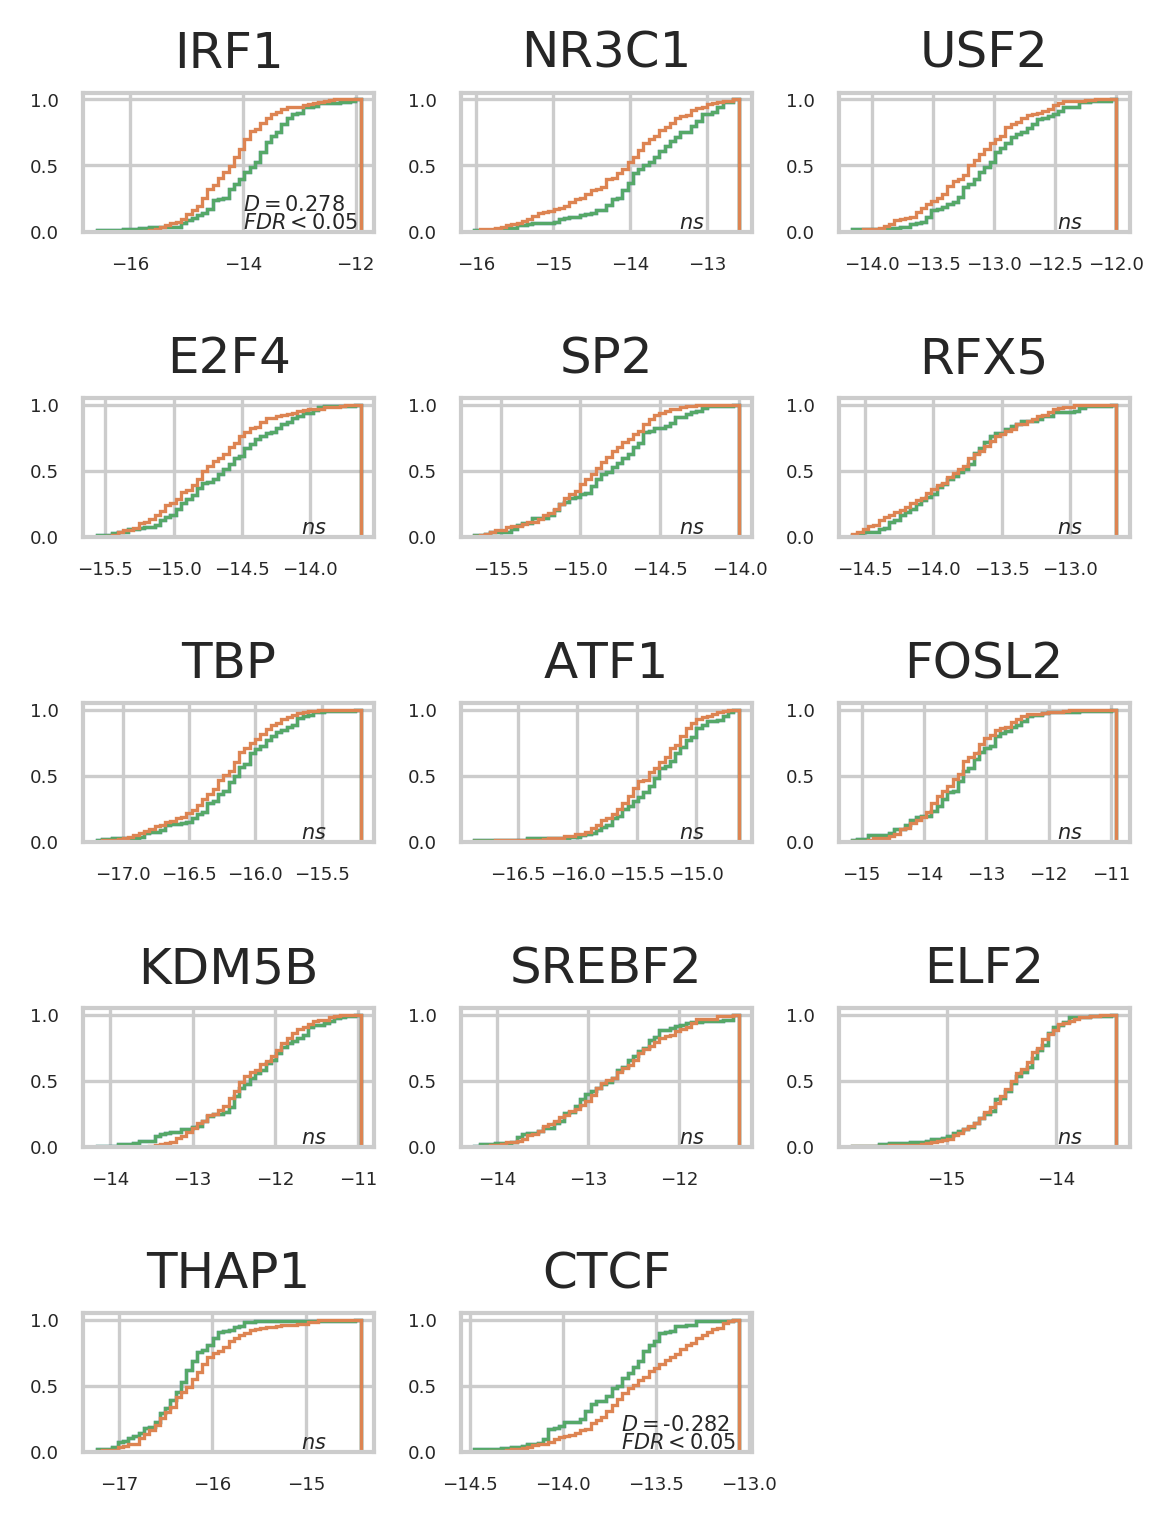

In [21]:
mpl.style.use('NaturePub')
sns.set(context='paper', style='whitegrid', palette='deep', font='sans-serif', 
font_scale=.5, color_codes=True)

# glist = ks_df.index[ks_df['FDR']<0.05]
glist = ks_df.index
n_bins = 50

nplots = len(glist)
ncols = 3
nrows = ceil(nplots/ncols)
clist = sns.color_palette(palette='deep', desat=1)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*1.5, nrows*1.2), dpi=300)
plt.subplots_adjust(wspace=0.3, hspace=1.2) # 
axes_list = axes.flatten()

df_p_sel = df_p[df_p['PAM50'].isin(['LumA'])]


for k in range(len(axes_list)):
    ax = axes_list[k]

    try:
        g = glist[k]
        x1 = df_p_sel[g][df_p_sel['ONCOTREE_CODE']=='ILC'].values
        x2 = df_p_sel[g][df_p_sel['ONCOTREE_CODE']=='IDC'].values
        x1 = x1[abs(x1) < 1e308] 
        x2 = x2[abs(x2) < 1e308] 

    #     sns.boxplot(data=df_p_sel, x='PAM50',y=g, hue='ONCOTREE_CODE', ax=ax)
        n, bins, patches = ax.hist(x1, n_bins, density=True, histtype='step', cumulative=True)
        ax.hist(x1, bins=bins, histtype='step', cumulative=True, density=True, label='ILC', color=clist[2])
        ax.hist(x2, bins=bins, histtype='step', cumulative=True, density=True, label='IDC', color=clist[1])

        ax.set_title(g, fontsize=12)
        ks, fdr = ks_df.loc[g, ['sg_ks','FDR']].values
        if fdr < 0.05:
            ax.text(0.55, 0.02, '${FDR}<0.05$', fontsize=5, transform = ax.transAxes) 
            ax.text(0.55, 0.15, '${D}=$%.3f'%ks, fontsize=5, transform = ax.transAxes)
        else:
            ax.text(0.75, 0.02, '${ns}$', fontsize=5, transform = ax.transAxes) 
    except:
        ax.axis('off')
            
plt.savefig('../Figure/Fig5/TCGA_tf.pdf', bbox_inches='tight')

# IRF1 in AL1

In [34]:
df_p = pd.DataFrame()
samples = AL1.obs.index

df_p['CellType'] = AL1.obs['CellType']
df_p['IRF1 Regulon'] = auc_mg.loc[samples,'IRF1'].values
df_p['IRF1 RNA'] = AL1[:,'IRF1'].layers['Ms']
df_p['CDH1 RNA'] = AL1[:,'CDH1'].layers['Ms']
df_p


CellType  IRF1 Regulon  IRF1 RNA  CDH1 RNA
index                                                           
AL1:AAAGTGAGTCATAGTCx    MM134      0.050138  0.785981  0.147251
AL1:AAAGAACGTAACAAGTx  T47D KO      0.018164  0.055986  0.267185
AL1:AAACGCTGTAGACACGx  T47D WT      0.004195  0.020321  0.819680
AL1:AAAGGGCCAGCAATTCx     MCF7      0.015673  0.303926  1.320525
AL1:AACAAAGGTTGAATCCx     MCF7      0.022771  0.309152  1.853251
...                        ...           ...       ...       ...
AL1:TTTGATCGTTGCACGCx     BCK4      0.028071  0.227847  0.142681
AL1:TTTGTTGCATCAGCGCx     MCF7      0.028757  0.458118  1.735341
AL1:TTTGGTTGTGATACAAx    SUM44      0.006991  1.477634  0.343677
AL1:TTTGACTGTTAGTTCGx   MCF10A      0.017374  0.512272  0.919501
AL1:TTTGTTGGTGATTAGAx   MCF10A      0.023018  0.413180  0.602770

[4614 rows x 4 columns]

In [35]:
# test
sel_terms = ['CDH1 RNA', 'IRF1 RNA', 'IRF1 Regulon']
glist = sel_terms 
ks_res = np.empty((len(glist), 3))

for n, g in enumerate(glist):
    x1 = df_p[g][df_p['CellType']=='T47D KO'].values
    x2 = df_p[g][df_p['CellType']=='T47D WT'].values
    x1 = x1[abs(x1) < 1e308] 
    x2 = x2[abs(x2) < 1e308] 

    stat, p = ks_2samp(x1, x2)
    sg_stat = stat if np.median(x1) > np.median(x2) else (-1)*stat
    ks_res[n,:] = [stat, sg_stat, p]
    
ks_df = pd.DataFrame(ks_res, columns=['ks','sg_ks','p'], index=glist).sort_values(by='sg_ks', ascending=False)

from statsmodels.stats.multitest import multipletests
ks_df['FDR'] = multipletests(ks_df['p'])[1] 
ks_df[ks_df['FDR']<0.05] 

ks     sg_ks              p  FDR
IRF1 Regulon  0.823491  0.823491  1.239188e-147  0.0
IRF1 RNA      0.432784  0.432784   4.385868e-41  0.0
CDH1 RNA      0.979849 -0.979849  7.663551e-209  0.0

In [75]:
mpl.style.use('NaturePub')
sns.set(context='paper', style='whitegrid', palette='deep', font='sans-serif', 
font_scale=2, color_codes=True)

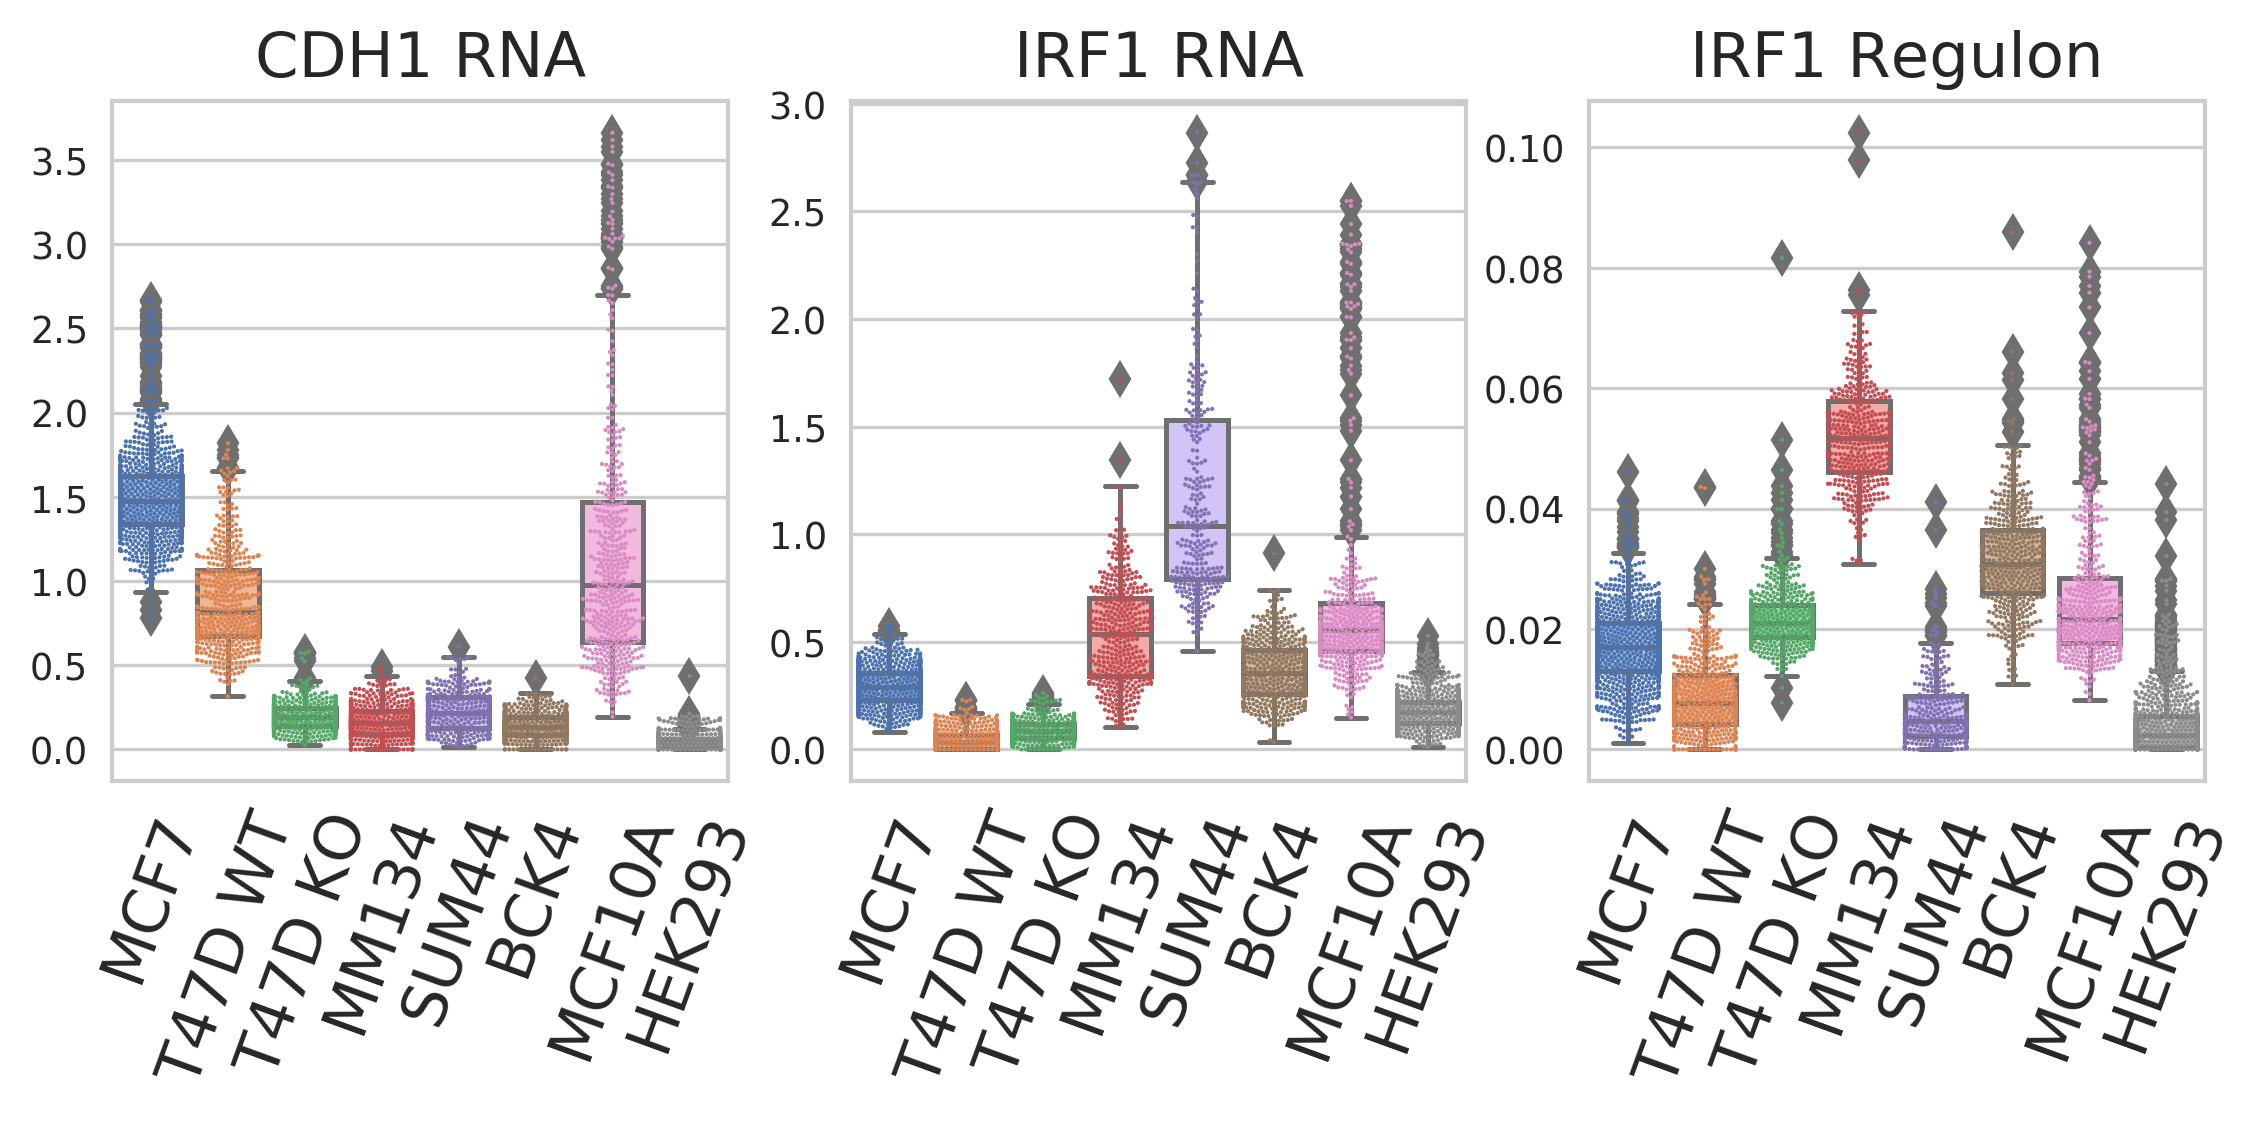

In [77]:
mpl.style.use('NaturePub')
sns.set(context='paper', style='whitegrid', palette='deep', font='sans-serif', 
font_scale=1, color_codes=True)


cats = ['CDH1 RNA', 'IRF1 RNA', 'IRF1 Regulon']
nplots = len(cats)
nrows = 1
ncols = ceil(nplots/nrows)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3, nrows*3), dpi=300)
plt.subplots_adjust(wspace=0.2, hspace=0.8) # 
axes_list = axes.flatten()

pvals = []
from scipy.stats import *
for n, g in enumerate(cats):
    ax = axes_list[n]
    
    sns.boxplot(data=df_p, x='CellType', y=g, ax=ax, palette='pastel') 
    sns.swarmplot(data=df_p, x='CellType', y=g, ax=ax, dodge=True, palette='deep', s=1) 

    ax.set_title(g, fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=15, rotation=70)
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.savefig('../Figure/Fig5/CatExpr_AL1_allsample.pdf', bbox_inches='tight')

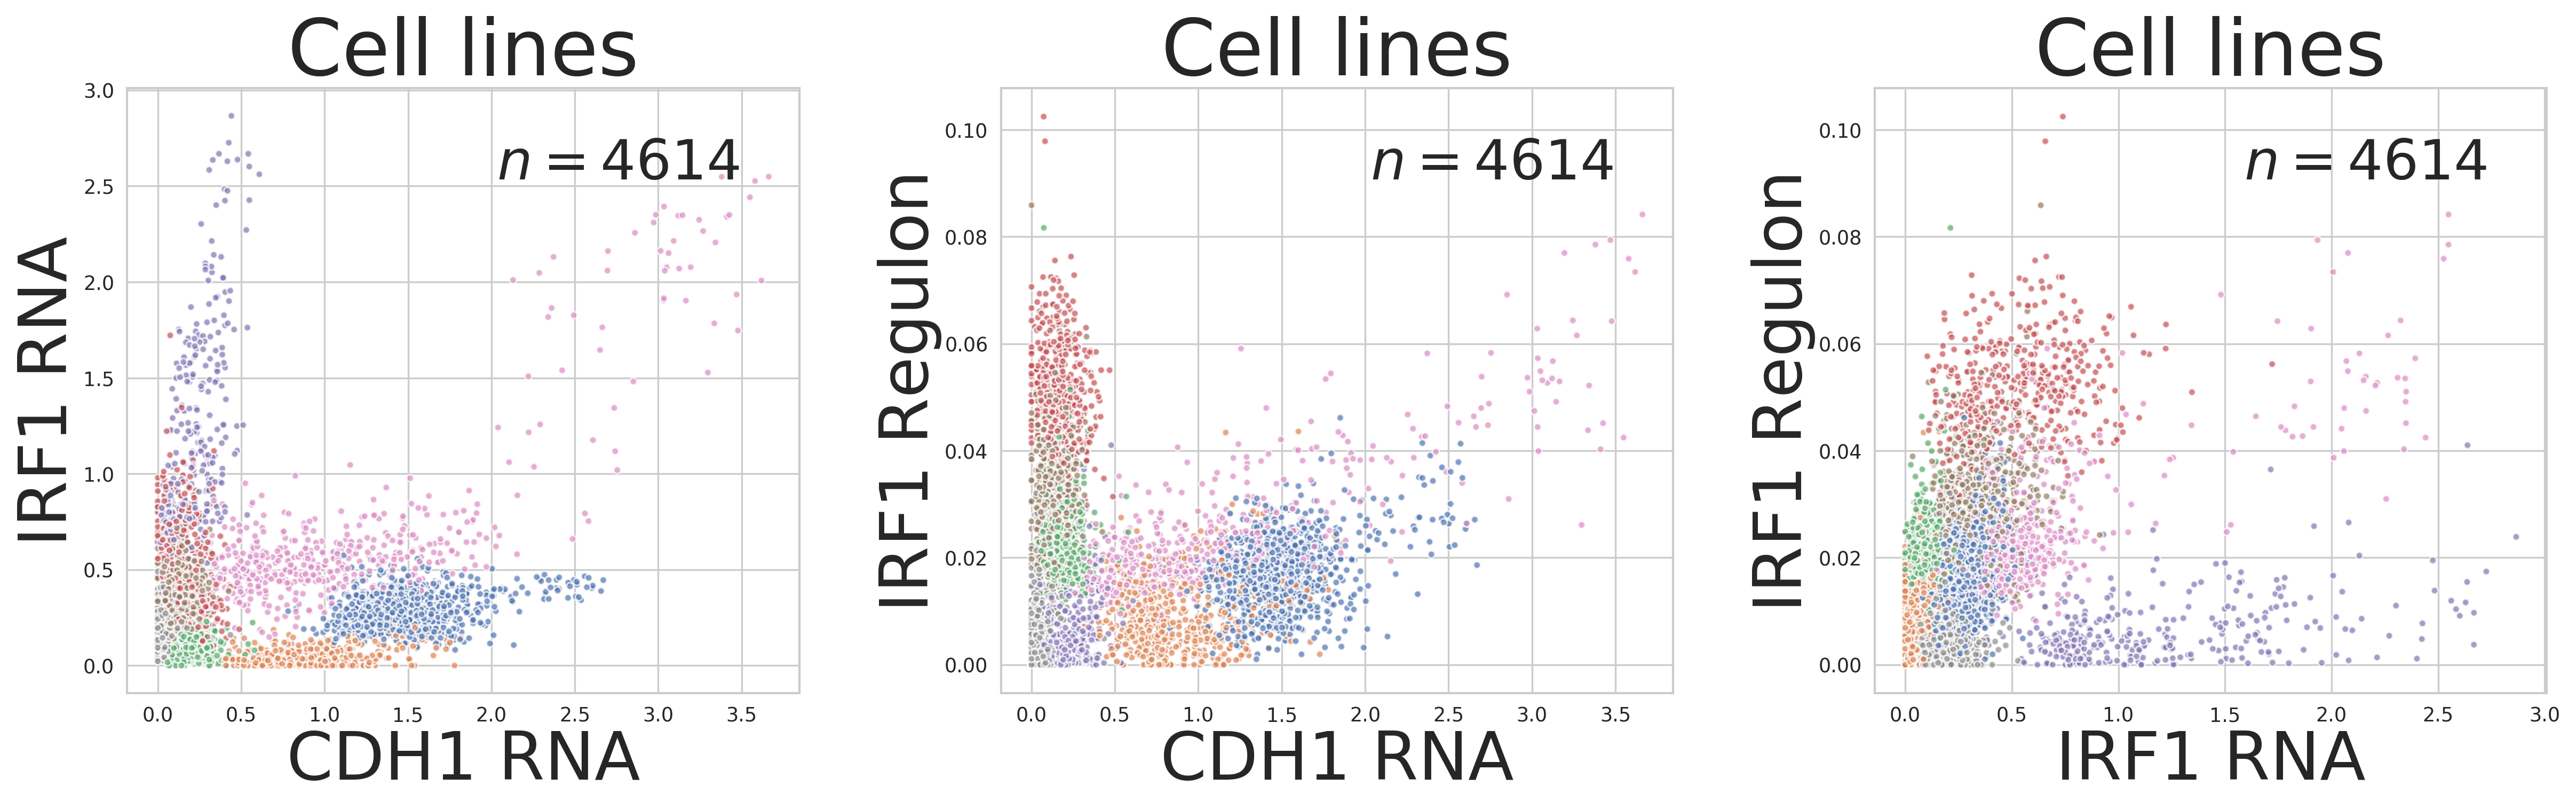

In [78]:
#restricted to LumA? 
from scipy.stats import pearsonr

cats = ['CDH1 RNA', 'IRF1 RNA', 'IRF1 Regulon']
nplots = len(cats)
nrows = 1
ncols = ceil(nplots/nrows)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*6.5, nrows*5), dpi=300)
plt.subplots_adjust(wspace=0.3, hspace=0.8) # 
axes_list = axes.flatten()

for n, g in enumerate(cats):
    ax = axes_list[n]
    if n==0:
        g1 = 'CDH1 RNA'
        g2 = 'IRF1 RNA'
    if n==1:
        g1 = 'CDH1 RNA'
        g2 = 'IRF1 Regulon'
    if n==2:
        g1 = 'IRF1 RNA'
        g2 = 'IRF1 Regulon' 
    sns.scatterplot(data=df_p, x=g1, y=g2, hue='CellType', s=10, alpha=.7, ax=ax, legend=False)

    x1 = df_p[g1]
    x2 = df_p[g2]    
    rho, p = pearsonr(x1,x2)

    ax.set_title('Cell lines', fontsize=35)
    ax.set_xlabel(g1, fontsize=30)
    ax.set_ylabel(g2, fontsize=30)

    ax.text(0.55, 0.85, '${n}=$%d'%len(x1), fontsize=25, transform = ax.transAxes)
        
plt.savefig('../Figure/Fig5/CoExpr_AL1_allsample.pdf', bbox_inches='tight')

In [54]:
Counter(test['60GeneClassifierClassAssignment'].values)

Counter({'Reactive-like': 50, 'Immune-related': 50, 'Proliferative': 27})

# Regulon components of masters

In [22]:
!ls ../data/pySCENIC/

AucMg.csv	    HEK293_motifs.csv	 MCF7_motifs.csv    T47D KO_auc_mtx.csv
BCK4_auc_mtx.csv    Jaccard_FDRDict.pkl  MM134_auc_mtx.csv  T47D KO_motifs.csv
BCK4_motifs.csv     Jaccard_KSDict.pkl	 MM134_motifs.csv   T47D WT_auc_mtx.csv
BinAucMg.csv	    MCF10A_auc_mtx.csv	 ref		    T47D WT_motifs.csv
BinBulkAucMg.csv    MCF10A_motifs.csv	 SUM44_auc_mtx.csv
HEK293_auc_mtx.csv  MCF7_auc_mtx.csv	 SUM44_motifs.csv


## Read Regulon

In [33]:
auc_mg = pd.read_csv('../data/pySCENIC/AucMg.csv', index_col=0)

In [4]:
masters = auc_mg.columns
CellTypes = ['MCF7','T47D WT','T47D KO',  'MM134','SUM44','BCK4',  'MCF10A'] # without HEK293
RegDict = {}

for master in masters:
    for n, cell in enumerate(CellTypes):
        with open('../data/pySCENIC/%s_motifs.csv'%cell, "rb") as f:
            regulons = pickle.load(f)

        tfs = np.array([r.transcription_factor for r in regulons])
        reg = regulons[np.where(tfs == master)[0][0]]
        tmp = pd.DataFrame(reg.weights, index=reg.genes, columns=[cell])

        res = tmp if n==0 else res.join(tmp, how='outer')
    
    res = res.fillna(0)
    RegDict[master] = res

In [27]:
df = RegDict['IRF1'] 
df

MCF7   T47D WT  T47D KO     MM134  SUM44  BCK4    MCF10A
AAMDC   4.513605  0.000000      0.0  0.000000    0.0   0.0  0.000000
AASS    0.000000  0.000000      0.0  0.000000    0.0   0.0  4.260723
ABCA2   2.489115  0.000000      0.0  0.000000    0.0   0.0  0.000000
ABCD1   0.000000  0.000000      0.0  0.000000    0.0   0.0  0.517072
ABHD11  0.000000  0.000000      0.0  0.000000    0.0   0.0  1.422320
...          ...       ...      ...       ...    ...   ...       ...
ZNF846  0.000000  2.854218      0.0  0.000000    0.0   0.0  0.000000
ZNF865  0.000000  2.246361      0.0  0.000000    0.0   0.0  0.000000
ZNFX1   0.000000  2.246361      0.0  0.000000    0.0   0.0  0.000000
ZSWIM5  0.000000  0.000000      0.0  1.799649    0.0   0.0  0.000000
ZSWIM6  0.000000  3.416452      0.0  0.000000    0.0   0.0  0.000000

[1166 rows x 7 columns]

In [28]:
fname = 'RegulonDict'
f = open("../data/pySCENIC/%s.pkl"%(fname),"wb")
pickle.dump(RegDict,f)
f.close()

## Write gmt

In [5]:
import pickle 
from utils import write_gmt 

RegDict = pickle.load(open('../data/pySCENIC/RegulonDict.pkl', 'rb'))
# gdict 
gmt_path = '../data/GSVA/Regulon.gmt'
regulon_gdict = {}


for master, val in RegDict.items():
    X = 1*(val.values > 0) # binarize
    genes = val.index 
    genes_sel = list(genes[(X[:,2] + X[:,3] + X[:,4] + X[:,5]) > 1]) ### at least present in two of the ILCs or KO

    if len(genes_sel)>10:
        print(master,':%d genes'%len(genes_sel))
        regulon_gdict[master] = genes_sel

write_gmt(regulon_gdict, gmt_path)

ATF1 :189 genes
ATF3 :520 genes
ATF4 :83 genes
ATF6B :18 genes
BHLHE40 :694 genes
BRF2 :793 genes
CEBPB :840 genes
CEBPZ :266 genes
CREB1 :33 genes
CREB3L4 :79 genes
CTCF :237 genes
E2F1 :1499 genes
E2F2 :157 genes
E2F4 :96 genes
E2F6 :46 genes
E2F7 :69 genes
E2F8 :259 genes
EGR1 :1406 genes
ELF1 :366 genes
ELF2 :73 genes
ELK1 :296 genes
ESRRA :513 genes
FOS :488 genes
FOSL2 :14 genes
GABPA :88 genes
IRF1 :22 genes
IRF3 :148 genes
JUN :441 genes
JUND :905 genes
KDM5B :857 genes
KLF4 :14 genes
MAZ :79 genes
MXI1 :75 genes
MYC :833 genes
NFYA :22 genes
NFYB :593 genes
NR3C1 :51 genes
PBX3 :29 genes
RELA :58 genes
RFX5 :80 genes
SP1 :28 genes
SP2 :55 genes
SPDEF :1222 genes
SREBF2 :502 genes
SRF :31 genes
TEAD2 :23 genes
TFDP1 :833 genes
THAP1 :83 genes
THAP11 :204 genes
USF1 :74 genes
USF2 :219 genes
YY1 :2424 genes
ZBTB7A :94 genes
finished writing 53 gene sets to ../data/GSVA/Regulon.gmt


In [8]:
wkdir = '/bgfs/alee/chelsea/projects/10X/CellLine'
keyword = 'Regulon'
sample = 'tcga'

for method in ['gsva', 'ssgsesa']:

    gmt_path = '{}/data/GSVA/{}.gmt'.format(wkdir, keyword)
    expr_path = '{}/data/TCGA15/{}.logNormCts.csv'.format(wkdir, sample) # gene x cell
    gsvaPrefix = '{}/data/GSVA/{}_{}'.format(wkdir,sample, keyword)

#     if not isfile('{}.{}.csv'.format(gsvaPrefix, method)):
    cmd = 'srun -t1:00:00 --cpus-per-task 12 /ihome/crc/install/gcc-8.2.0/r/3.6.0/bin/Rscript %s/codes/GSVA.R %s %s %s %s &\n'%(wkdir, expr_path, gmt_path, gsvaPrefix, method)
    print(cmd)

srun -t1:00:00 --cpus-per-task 12 /ihome/crc/install/gcc-8.2.0/r/3.6.0/bin/Rscript /bgfs/alee/chelsea/projects/10X/CellLine/codes/GSVA.R /bgfs/alee/chelsea/projects/10X/CellLine/data/TCGA15/tcga.logNormCts.csv /bgfs/alee/chelsea/projects/10X/CellLine/data/GSVA/Regulon.gmt /bgfs/alee/chelsea/projects/10X/CellLine/data/GSVA/tcga_Regulon gsva &

srun -t1:00:00 --cpus-per-task 12 /ihome/crc/install/gcc-8.2.0/r/3.6.0/bin/Rscript /bgfs/alee/chelsea/projects/10X/CellLine/codes/GSVA.R /bgfs/alee/chelsea/projects/10X/CellLine/data/TCGA15/tcga.logNormCts.csv /bgfs/alee/chelsea/projects/10X/CellLine/data/GSVA/Regulon.gmt /bgfs/alee/chelsea/projects/10X/CellLine/data/GSVA/tcga_Regulon ssgsesa &



## Gene components of IRF1 regulon

In [31]:
sel_dict = read_gmt('../data/GSVA/Regulon.gmt')
sigGenes = sel_dict['irf1']

from gprofiler import GProfiler
gp = GProfiler(return_dataframe=True)
r = gp.convert(organism='hsapiens',
            query=sigGenes,
            target_namespace='ENTREZGENE_ACC')


In [32]:
for idx in r.index:
    name, desc = r.loc[idx, ['incoming','description']]
    print(name, desc,sep='\t\t')

AGPAT2		1-acylglycerol-3-phosphate O-acyltransferase 2 [Source:HGNC Symbol;Acc:HGNC:325]
AZIN1		antizyme inhibitor 1 [Source:HGNC Symbol;Acc:HGNC:16432]
CORO6		coronin 6 [Source:HGNC Symbol;Acc:HGNC:21356]
CRABP2		cellular retinoic acid binding protein 2 [Source:HGNC Symbol;Acc:HGNC:2339]
CSNK1D		casein kinase 1 delta [Source:HGNC Symbol;Acc:HGNC:2452]
CYB5R1		cytochrome b5 reductase 1 [Source:HGNC Symbol;Acc:HGNC:13397]
GMIP		GEM interacting protein [Source:HGNC Symbol;Acc:HGNC:24852]
GOLGA6L4		golgin A6 family like 4 [Source:HGNC Symbol;Acc:HGNC:27256]
GPBP1		GC-rich promoter binding protein 1 [Source:HGNC Symbol;Acc:HGNC:29520]
IRF1		interferon regulatory factor 1 [Source:HGNC Symbol;Acc:HGNC:6116]
ISOC2		isochorismatase domain containing 2 [Source:HGNC Symbol;Acc:HGNC:26278]
KLF3		Kruppel like factor 3 [Source:HGNC Symbol;Acc:HGNC:16516]
NR1H2		nuclear receptor subfamily 1 group H member 2 [Source:HGNC Symbol;Acc:HGNC:7965]
OLFM2		olfactomedin 2 [Source:HGNC Symbol;Acc:HGNC:17189]


In [33]:
# IRF1 regulon from ENCODE (downloaded from EnrichR, `ENCODE_and_ChEA_Consensus_TFs_from_ChIP-X` dataset)
IRF1_CHEA = ['PTPRN2', 'UNC13C', 'PRELID2', 'ATP6V1E1', 'DYX1C1', 'GLYCTK', 'RPL24', 'AARSD1', 'PISD', 'BC037281', 'CYP1A1', 'PI4K2B', 'ATF3', 'HPGD', 'HNT', 'MGC4093', 'CYB5D2', 'C3ORF17', 'CREB3L1', 'CHAC1', 'SAMD13', 'RFFL', 'INTS2', 'HLA-E', 'STAG2', 'ADFP', 'KIAA0146', 'RNPS1', 'VEZT', 'RPL34', 'LOC124446', 'CTDSPL2', 'CDCA8', 'ZBTB5', 'ZNF26', 'HSPH1', 'BRIP1', 'RASSF5', 'BARD1', 'AASS', 'DUSP6', 'MYST1', 'NSUN4', 'HEG1', 'TUBB2A', 'POU6F2', 'LOC126917', 'TMEFF1', 'NCOR1', 'RARB', 'EXOC5', 'PIGG', 'HBS1L', 'C1ORF35', 'ABHD7', 'C6ORF170', 'AK096234', 'TOR1AIP1', 'FXR2', 'RBM35B', 'LOC346157', 'KCNT2', 'CSRP1', 'CXORF9', 'HLA-DQA1', 'FAM58A', 'WDR18', 'HSPC072', 'STXBP5L', 'TMEM65', 'RAB11A', 'RAB11B', 'PSMA6', 'HIST2H3C', 'NAP5', 'MC5R', 'CD48', 'ZNF333', 'DHRS13', 'WRB', 'UNG', 'PEPD', 'NUDT4', 'FLJ10241', 'AKAP12', 'PLAGL1', 'LCMT1', 'LOC730091', 'LOC401152', 'BC016970', 'RAB2B', 'KIAA0090', 'HNRPC', 'ZNF77', 'RPSA', 'KIAA1856', 'ALDH4A1', 'KIAA0404', 'CSDA', 'CNOT4', 'YPEL2', 'AL137707', 'GAPDHS', 'ZFHX1B', 'PTPN3', 'PTPN4', 'PCNA', 'DNMT2', 'CCNT2', 'CHRM5', 'SLC1A2', 'CCBL1', 'C1ORF106', 'ZNF425', 'RGS20', 'ARHGEF11', 'CD97', 'ACBD6', 'SHRM', 'C2ORF18', 'HELZ', 'C1ORF103', 'TFIIB', 'PICALM', 'RNF168', 'FRMD6', 'TMEM119', 'NAT5', 'TXN2', 'SLA-LP', 'SLC2A2', 'TRHDE', 'LOC729982', 'CHAF1B', 'AK023939', 'NFATC2IP', 'ZKSCAN3', 'HPMS6', 'C14ORF43', 'GLYATL1', 'NIPSNAP1', 'CLK1', 'FLJ37078', 'OAS3', 'MCM7', 'DOCK2', 'ALK', 'FBN3', 'C2ORF43', 'MIPEP', 'ONECUT3', 'NLGN1', 'ILK', 'CHD9', 'ATP5L', 'HK1', 'FBXO43', 'FUT8', 'PDE4B', 'C14ORF28', 'ZNF502', 'SCYL1BP1', 'ACP2', 'DCC', 'TCF7L1', 'DDX17', 'C13ORF6', 'ARNT', 'FBXL18', 'NSMCE2', 'KCTD7', 'TBX3', 'SNTB1', 'MLPH', 'GOLPH3', 'POLR1B', 'GFOD1', 'RGS13', 'FXN', 'SPAG1', 'CD226', 'RBMX', 'HIST1H2BC', 'AK096849', 'C3ORF26', 'HIST1H2BD', 'ASNSD1', 'STEAP4', 'WDR5', 'C14ORF122', 'UBXD7', 'SLC25A29', 'ZIC3', 'TDH', 'SIX3', 'FBXO4']
IRF1_ENCODE = ['NIPSNAP3A', 'FNBP4', 'DHDH', 'KIAA1586', 'MIR3917', 'BTBD10', 'PRKAB2', 'RPL17-C18ORF32', 'NECAP1', 'NECAP2', 'MTHFD2', 'C8ORF44-SGK3', 'MTHFD1', 'ORAI3', 'LOC100128292', 'ORAI2', 'ORAI1', 'CIAPIN1', 'JRK', 'NPRL3', 'EWSR1', 'SDAD1', 'PTPDC1', 'PRPSAP2', 'PRPSAP1', 'LOC100133669', 'KCNQ1OT1', 'SNX29', 'BBX', 'LOC100128288', 'ZNF18', 'SAP30BP', 'PRPF38B', 'PRPF38A', 'TEX10', 'NCAPH2', 'VPS13D', 'SECISBP2', 'VPS13C', 'ENTPD3-AS1', 'LOC100630918', 'ZNF17', 'DHFR', 'MOV10', 'PPFIBP2', 'FAM111A', 'PLSCR1', 'PLSCR3', 'PLBD2', 'CHST2', 'SFXN2', 'SFXN3', 'SF1', 'DZIP3', 'NMT1', 'TFRC', 'ITSN2', 'LOC100630923', 'LOC100506190', 'ZNF23', 'ZNF25', 'ALKBH8', 'LOC285441', 'DEDD2', 'ZNF28', 'OPLAH', 'ALKBH4', 'LOH12CR2', 'LARP1', 'ZC3H12A', 'ZNF20', 'LOH12CR1', 'NKX3-1', 'PLEKHM1P', 'LOC100132356', 'DUSP5', 'SDF2L1', 'GSTM4', 'PNPT1', 'DUSP3', 'JUN', 'JUP', 'MCRS1', 'ZNF32', 'IFT122', 'ZNF35', 'LOC643723', 'BMP8A', 'DCBLD1', 'MMP17', 'DPYD', 'CCDC8', 'LOC100130581', 'GTF2H2C', 'RAPGEF6', 'IL18BP', 'KCNC3', 'CRYBB2P1', 'ZNF43', 'ZC3HAV1', 'ZNF44', 'ZNF45', 'FAM113A', 'ZNF48', 'ZNF41', 'ATAD1', 'EGLN3', 'DGAT1', 'LOC388796', 'MBD2', 'ACOT13', 'SNX24', 'LOC100288198', 'ADAM10', 'ARCN1', 'TTC28-AS1', 'MYBBP1A', 'SNX17', 'ADAM15', 'LARS2', 'SDHAF1', 'APEX1', 'PTRH2', 'TRUB2', 'GTF2H2D', 'SNX13', 'JRKL', 'PRKAG1', 'MIR3928', 'FGFR1OP2', 'STRA13', 'PKM2', '11-Sep', 'MAP3K4', 'C21ORF33', 'ATP11B', 'FBXW2', 'LRCH3', 'LOC643770', 'RINT1', 'UQCRQ', 'MSH6', 'LY6E', 'PKP3', 'PDCD5', 'PDCD4', 'SRSF4', 'PDCD2', 'CDKN2AIPNL', 'SRSF6', 'ARL8B', 'SRSF9', 'SRSF1', 'FAM35A', 'URM1', 'RASL11B', 'LENEP', 'PTAR1', 'RG9MTD3', 'STX7', 'STX6', 'RG9MTD1', 'NDOR1', 'MAP3K8', 'LINC00115', 'CERS4', 'BCAS4', 'NEK7', 'C21ORF59', 'PIAS1', 'FBXO34', 'FBXO31', 'PIAS2', 'MINPP1', 'DRAP1', 'SMS', 'BCAT2', 'NOP10', 'MNAT1', 'C21ORF67', 'BLM', 'RIF1', 'FBXO24', 'LOC100289495', 'GSTT1', 'PKMYT1', 'FBXO22', 'FBXO21', 'UQCRH', 'UROD', 'KHDC1', 'NEK1', 'TNFRSF8', 'ZKSCAN3', 'NFATC2IP', 'TMEM167A', 'ZKSCAN1', 'TRIM68', 'TRIM62', 'UNC45A', 'API5', 'DHPS', 'EIF2AK1', 'EIF2AK4', 'RABGGTB', 'TNFRSF1A', 'TNFRSF1B', 'TNFRSF21', 'PCCA', 'SP2', 'SP5', 'SMCR7', 'UNC79', 'ETF1', 'ZNF878', 'TRIM59', 'DCTPP1', 'LOC257396', 'TRIM56', 'KCNK5', 'AARS2', 'UFD1L', 'SAR1B', 'SHMT1', 'LY96', 'UAP1', 'C17ORF61-PLSCR3', 'PPWD1', 'FBXO43', 'DRAM1', 'DRAM2', 'NELF', 'KDSR', 'RDH11', 'C10ORF10', 'RDH14', 'TRIM44', 'TNFRSF14', 'BCAS2', 'MBIP', 'NOP58', 'SLC36A1', 'KCNH5', 'UNC5B', 'KCNH8', 'RNASET2', 'MRVI1-AS1', 'BCS1L', 'LENG1', 'C1D', 'KIAA0226', 'TXNIP', 'TRIM37', 'TRIM38', 'TRIM32', 'TRIM33', 'NOP56', 'ZNF850', 'MTCH2', 'CANT1', 'C1R', 'UHRF2', 'LOC257358', 'DYSF', 'SRF', 'ECE1', 'LENG8', 'PTER', 'ARL13B', 'ZNF846', 'TRIM25', 'UBQLN2', 'UBQLN1', 'ZNF845', 'ZNF844', 'FBXO7', 'RNMTL1', 'TRIM21', 'ZNF841', 'SSB', 'PEX19', 'TMEM170A', 'ARL16', 'ECH1', 'FBXO3', 'CNBP', 'NBEAL2', 'PEX10', 'PEX14', 'GSTZ1', 'LOC646762', 'ST7', 'CCP110', 'SOAT1', 'SUB1', 'MTCP1', 'FLYWCH2', 'TP53', 'HM13', 'SLC23A1', 'PEX26', 'PSMB10', 'E2F1', 'E2F2', 'E2F3', 'E2F4', 'ATXN7L1', 'E2F6', 'COX8A', 'MIR1281', 'APOBEC3H', 'TGDS', 'SPDYC', 'IGF1', 'MGC72080', 'KEL', 'CNKSR3', 'BTD', 'MSRA', 'RNF144A', 'SNHG11', 'CWF19L1', 'CWF19L2', 'SNHG10', 'NET1', 'LOC256880', 'MON1A', 'PTPLAD1', 'BTK', 'NDUFAF1', 'NDUFAF2', 'FBXL3', 'FBXL6', 'FBXL5', 'MON1B', 'GRB7', 'FBXL8', 'CES2', 'APOBEC3C', 'LOC554206', 'RFESD', 'ICAM4', 'ICAM5', 'ZBTB4', 'ZBTB3', 'APOO', 'MT2A', 'LGALS1', 'TNFSF10', 'LGALS9', 'DECR2', 'BBS2', 'MST4', 'HARS2', 'BBS1', 'KLHL2', 'TOX4', 'BST2', 'RAP2B', 'PTMA', 'TFAP4', 'LOC100287765', 'RAP2C', 'KLHL7', 'KLHL8', 'LOC100505687', 'ARHGEF2', 'TAX1BP3', 'ATPAF1', 'COX7C', 'MRPS16', 'COX7B', 'MRPS17', 'DHX8', 'HIBADH', 'MRPS14', 'MRPS12', 'SDC4', 'MRPS10', 'KHK', 'NEU3', 'PPP3CC', 'ANKRD18DP', 'RAP1B', 'UIMC1', 'NEU1', 'ORMDL3', 'LOC100505676', 'FAM192A', 'BBS7', 'PCK2', 'LYAR', 'DYNC1I2', 'BBS4', 'C9ORF114', 'MRPS27', 'SPRYD3', 'MRPS28', 'SPRYD4', 'MRPS25', 'MRPS26', 'SPRYD7', 'MRPS23', 'MRPS24', 'ORMDL1', 'MRPS21', 'CACYBP', 'C9ORF116', 'LOC439994', 'KIN', 'APRT', 'ETAA1', 'BRMS1', 'SEC23IP', 'NDUFAB1', 'FAM195A', 'SGSM3', 'TACC2', 'RAD1', 'DYNC1H1', 'VMP1', 'C9ORF102', 'ECM1', 'COX5A', 'MRPS35', 'C9ORF100', 'PRICKLE3', 'MRPS30', 'NUP188', 'MRPS31', 'HERPUD2', 'ZFP14', 'POFUT1', 'ENPP3', 'SDF4', 'SDF2', 'ENPP7', 'HSD3B7', 'FBXW11', 'ZNF76', 'MRE11A', 'SDHAP2', 'SDHD', 'APTX', 'DHDDS', 'SDHA', 'ZNF70', 'POLE3', 'ZNF74', 'PLAA', 'GRINA', 'PCNA', 'SFSWAP', 'NDUFB10', 'PRDM1', 'ZNF81', 'ZNF83', 'MSX1', 'DENND5A', 'PCNT', 'TTC37', 'PCYT1A', 'TTC38', 'TTC35', 'TTC33', 'PCID2', 'TTC32', 'CHCHD10', 'NUP153', 'AP4B1', 'FAM199X', 'TIMM44', 'RNASEH1', 'LOC100216545', 'CCNB1IP1', 'SLC9A11', 'ZNF92', 'ZNF93', 'PSPC1', 'MKRN1', 'MKRN2', 'MKRN3', 'UBA3', 'UBA1', 'POLG2', 'MICU1', 'FGF13', 'LOC441461', 'COX16', 'COX19', 'TACO1', 'PTRF', 'NME1-NME2', 'PIBF1', 'GUSBP4', 'PLDN', 'GUSBP1', 'URGCP', 'TTC14', 'SUN1', 'TTC12', 'TTC17', 'ETV7', 'IFT43', 'POLA2', 'C4ORF42', 'TNIP2', 'EEF1D', 'ACOX1', 'EEF1G', 'TAG', 'LOC100507466', 'TTC26', 'C9ORF163', 'UBA7', 'LOC255512', 'PLD6', 'SLC3A2', 'PLD2', 'C4ORF33', 'C4ORF32', 'PLD4', 'TTC29', 'FYCO1', 'SYNGR2', 'ZNF670-ZNF695', 'GRK6', 'CA8', 'TBP', 'TIMM8B', 'CAD', 'C4ORF29', 'C4ORF27', 'WARS2', 'USF1', 'SMUG1', 'GALE', 'ERCC5', 'ERCC3', 'ERCC8', 'ERCC6', 'NUP107', 'LOC100132273', 'CBS', 'POLD2', 'POLD3', 'TDG', 'BNIP2', 'BNIP1', 'IFT57', 'CYTH2', 'EARS2', 'DUS4L', 'CYTH1', 'GAMT', 'DNAAF1', 'AFAP1', 'WDR73', 'NUP210', 'WDR74', 'FAM86EP', 'C14ORF159', 'LOC100506054', 'TEC', 'NUP93', 'ARMC1', 'OSTM1', 'NUP98', 'SDPR', 'ZSCAN21', 'ARMC7', 'WDR83', 'VPS25', 'GTF2IRD1', 'VPS28', 'GALT', 'TES', 'C14ORF149', 'RALA', 'C14ORF142', 'WDR65', 'FAM86DP', 'APOL6', 'TFG', 'LOC100128164', 'NUP85', 'ZSCAN12', 'FAM120B', 'WDR70', 'LUC7L', 'NUP88', 'VPS16', 'APOL2', 'APOL1', 'RALY', 'VPS18', 'ST3GAL3', 'NDFIP1', 'PLK4', 'NDFIP2', 'APOOL', 'MCAM', 'WDR53', 'LOC158572', 'ELL2', 'C14ORF178', 'COPZ1', 'HCFC2', 'WDR60', 'WDR61', 'RNF216P1', 'FANK1', 'TMEM110-MUSTN1', 'RRP1', 'C14ORF166', 'SMC6', 'ARPP19', 'SMC4', 'SMC5', 'WDR47', 'SMC2', 'C14ORF169', 'FAM86FP', 'WDR45', 'ELK4', 'FAM122B', 'POM121C', 'BLOC1S2', 'KIAA1468', 'BTF3', 'WDR38', 'PHF11', 'IL10RB', 'WDR31', 'FAM126A', 'WDR33', 'WDR34', 'MTF2', 'EXOC4', 'EXOC7', 'GARS', 'EXOC1', 'MOCS2', 'FXC1', 'EXOC2', 'FAM86HP', 'BTG3', 'WDR27', 'DENND1B', 'DENND1A', 'AKAP17A', 'WDR20', 'WDR24', 'WDR25', 'FAM171A2', 'SPTA1', 'METTL21D', 'LHPP', 'TK1', 'GAR1', 'PLLP', 'RRS1', 'WDR18', 'CDKN2C', 'HELLS', 'TPK1', 'LOC145216', 'WDR19', 'MOCOS', 'GATC', 'KIDINS220', 'RRP1B', 'NFIA', 'FDX1L', 'KIAA0195', 'KIAA0196', 'NFIC', 'JKAMP', 'GATS', 'PLIN2', 'TIMELESS', 'TMEM229B', 'TKT', 'SRFBP1', 'SMG5', 'CDKN1B', 'SETD4', 'NDUFA12', 'NDUFA13', 'NDUFA10', 'RARS', 'SMG8', 'SMG9', 'SMG6', 'FAM127A', 'UBL7', 'PPP1R2', 'MCEE', 'IFIH1', 'ARFRP1', 'UBL5', 'UBL3', 'NAMPT', 'PPP1R8', 'CKB', 'SLC17A7', 'RRP15', 'SBDSP1', 'AHSP', 'SLC17A5', 'FAM48A', 'CSGALNACT2', 'C8ORF38', 'FKBPL', 'USP4', 'HIPK1', 'PPP1CA', 'MORF4L1', 'COPS5', 'COPS4', 'COPS6', 'ZNF799', 'FKBP5', 'FKBP4', 'FRA10AC1', 'FKBP3', 'ZNF791', 'LOC147804', 'ZNF790', 'GTF2B', 'PARK7', 'GLT8D1', 'FGD2', 'RNU11', 'ABLIM3', 'CFL1', 'USP2', 'SLC26A11', 'ZNF788', 'ZNF786', 'C8ORF44', 'ZNF785', 'MAP2K4', 'ZNF783', 'MAP2K5', 'ZNF781', 'OSBPL8', 'FANCM', 'GTF3A', 'FANCF', 'FANCE', 'FANCG', 'SYNJ2', 'SYNJ1', 'PITPNM1', 'BCL2L1', 'PDCL', 'ZNF778', 'TPP1', 'ZNF776', 'ZNF774', 'BCL2L2', 'IFNAR2', 'FAM49B', 'N6AMT2', 'ZNF771', 'ZNF770', 'CNO', 'TPMT', 'INSIG1', 'SLC38A10', 'IPO4', 'FGF2', 'EDC3', 'EDC4', 'VPS72', 'LOC440925', 'TCEANC', 'TMEM179B', 'ZNF766', 'PLS1', 'ZNF765', 'MAP2K7', 'ZNF761', 'LANCL1', 'SECISBP2L', 'ARL2-SNX15', 'WIPI2', 'ZNF75A', 'BCKDK', 'DNAJC2', 'NOA1', 'DNAJC8', 'MFAP1', 'BCL6', 'PCNA-AS1', 'CPD', 'CEBPZ', 'MCM6', 'DNAJC9', 'C8ORF76', 'MCM2', 'IPPK', 'SLC48A1', 'VPS4B', 'HMMR', 'UBR3', 'ZC3H8', 'LOC100499227', 'UFSP2', 'LBH', 'RRP7B', 'ORC6', 'MIR4529', 'ORC5', 'DNAJB1', 'RRP7A', 'TNPO1', 'ORC1', 'DNAJB6', 'ZNF749', 'ORC3', 'VPS53', 'DNAJB4', 'PHACTR4', 'ZNF746', 'TNPO3', 'MCL1', 'PLA2G12A', 'SMOX', 'GGPS1', 'LOC100289561', 'WDR96', 'LEMD2', 'TSN', 'CPPED1', 'DNAJA2', 'DNAJA1', 'MIR4519', 'APOC1', 'VPS41', 'MIR4514', 'CTDSP2', 'LOC641298', 'DNAJA3', 'MIR4515', 'DRG1', 'DRG2', 'C8ORF51', 'CRK', 'ALDH9A1', 'C8ORF55', 'HDAC3', 'MCM8', 'HDAC1', 'CEBPG', 'WDR85', 'KIAA0101', 'NOB1', 'TTK', 'MTO1', 'HDAC7', 'WDR89', 'COCH', 'HECTD3', 'WDR91', 'ZNF726', 'VPS36', 'CSK', 'ZNF720', 'VPS39', 'SRRM3', 'SLC35A3', 'SLC35A2', 'SLC35A4', 'IFRD1', 'C17ORF28', 'SLC35A1', 'SRRM1', 'SRRM2', 'KIAA0922', 'NEIL3', 'ZNF839', 'GLOD4', 'ZNF837', 'FAM40A', 'PARS2', 'DCP1B', 'NEIL2', 'DCP1A', 'MIR4453', 'TECPR2', 'MTPN', 'IFITM2', 'IFITM3', 'C17ORF39', 'IFITM1', 'STXBP2', 'SLC35B2', 'STXBP3', 'IL21R', 'PDHB', 'NOD1', 'NFS1', 'PDCD11', 'LOC100506844', 'ARFIP2', 'STXBP6', 'ARFIP1', 'TMEM184B', 'LOC100505549', 'COG8', 'ARRDC2', 'COG5', 'SYNRG', 'SLC35C2', 'COG3', 'OCEL1', 'HLA-E', 'RPS27', 'RPS26', 'FCHSD1', 'RPS29', 'RPS28', 'SMU1', 'ADCK3', 'ZNF816', 'ATP5J2-PTCD1', 'ZNF813', 'RPS21', 'RPS20', 'RPS23', 'RPS25', 'RBAK', 'RPS24', 'SLC22A5', 'VEZT', 'MTRR', 'HDAC11', 'SLC35D1', 'HDAC10', 'MPHOSPH10', 'CSTF3', 'PITPNA', 'IFIT5', 'IFIT2', 'IFIT1', 'IFIT3', 'RPS15', 'RPS19', 'ZNF805', 'CSTF2', 'WBSCR22', 'ZNF800', 'RPS10', 'ERMAP', 'PDK1', 'RPS12', 'RPS11', 'ARGLU1', 'PDK3', 'RPS13', 'SLC35E4', 'MLF1', 'MLF2', 'C17ORF61', 'HIST3H2A', 'NFX1', 'VWA1', 'COPG2', 'MEGF9', 'DTYMK', 'C2CD3', 'CAB39L', 'SLC35F5', 'C17ORF70', 'C17ORF75', 'LIAS', 'ZCCHC17', 'COIL', 'DGCR6L', 'SEC61G', 'C1QBP', 'UBXN8', 'TMED2', 'TMED1', 'TMED7', 'LRRCC1', 'UBXN7', 'PARP4', 'MIR4470', 'NFYB', 'GBF1', 'FAM46C', 'SLC35G1', 'THOC2', 'ZDHHC13', 'THOC1', 'ZDHHC14', 'TEKT4P2', 'PPHLN1', 'FLJ38109', 'ZDHHC18', 'THOC5', 'PPP2CA', 'PARP9', 'PDP2', 'NR6A1', 'SPCS2', 'GDPD1', 'C9ORF3', 'AIDA', 'FYTTD1', 'LOC253039', 'ZDHHC20', 'C17ORF59', 'ZDHHC24', 'SIPA1L3', 'C17ORF53', 'RPAIN', 'PPP2CB', 'GSG2', 'MTX1', 'CPSF6', 'NOM1', 'KIAA0090', 'GINS2', 'GINS1', 'CPSF2', 'ACYP1', 'ATPBD4', 'CPSF1', 'LIG1', 'GINS4', 'CPSF4', 'LIG4', 'ATP1B3', 'LIG3', 'PPAPDC2', 'TRPC4AP', 'BAMBI', 'UCA1', 'BRWD1', 'MPHOSPH6', 'ZCCHC9', 'ZCCHC8', 'ZCCHC6', 'NOL3', 'ZWILCH', 'MIR3191', 'TAMM41', 'MIR3190', 'NOL8', 'NOL9', 'ATP1A3', 'ATP1A1', 'TYMS', 'NOL6', 'CNDP2', 'NOL7', 'MIR155', 'TCTEX1D2', 'STX16-NPEPL1', 'C17ORF89', 'HELQ', 'MLL5', 'HELZ', 'MESDC1', 'GLTSCR2', 'MESDC2', 'DIAPH3', 'SELO', 'TMEM2', 'CENPC1', 'TMEM9', 'DDAH2', 'SELK', 'SPECC1L', 'THOP1', 'ZCCHC4', 'FGFR3', 'SELS', 'MIR3188', 'C17ORF99', 'SPPL2B', 'MRPL45P2', 'GSTCD', 'COPB1', 'CLEC16A', 'ZMAT2', 'EME1', 'EME2', 'UBC', 'CDH24', 'MIR3178', 'MIR3175', 'HGSNAT', 'C14ORF118', 'IQCC', 'LOC285456', 'OAS1', 'RPS3A', 'IQCE', 'COQ9', 'DAK', 'COQ7', 'COQ4', 'RBL1', 'RABEP1', 'LOC100506012', 'RABEP2', 'RBL2', 'OAS3', 'THRAP3', 'AKT1S1', 'C14ORF39', 'C14ORF38', 'ATP13A3', 'BLMH', 'DNASE2', 'COPE', 'GPSM2', 'AASDH', 'NOP2', 'PMEL', 'CMAHP', 'RPAP1', 'RPAP2', 'C14ORF102', 'RPAP3', 'ST7-OT4', 'EMG1', 'SCFD2', 'SCFD1', 'DBT', 'RPS6KC1', 'LONRF3', 'ATRIP', 'HIST1H2AM', 'HIST1H2AI', 'HIST1H2AL', 'DCK', 'LSS', 'C14ORF135', 'TWSG1', 'KANSL2', 'RPS6KB2', 'AIM1', 'DDIT4', 'KIAA0907', 'HIST1H2BH', 'RBMX', 'CLOCK', 'MRFAP1L1', 'HIST1H2BO', 'ASNSD1', 'LTK', 'HIST1H2BL', 'FAM86C1', 'C14ORF126', 'DDO', 'CCDC28B', 'RBM4', 'RBM5', 'RPS4X', 'ARHGDIA', 'RPS6KA4', 'LOC100506023', 'RPS6KA1', 'PDSS2', 'BUB3', 'SC5DL', 'BUB1', 'POC1A', 'RBM7', 'STARD3', 'SND1', 'B3GALNT2', 'STARD5', 'ZFYVE20', 'GDAP1', 'SCAMP2', 'ROCK1P1', 'EML2', 'GDAP2', 'ZFYVE26', 'SCAMP3', 'EML4', 'LOC100507266', 'RBP5', 'CLNS1A', 'RBCK1', 'MTMR2', 'PDXK', 'USP6NL', 'STAU2', 'RETSAT', 'MTMR9', 'IER5L', 'NXF1', 'MUC1', 'DKFZP686I15217', 'LOC100507250', 'DNTTIP1', 'C10ORF2', 'FLJ45974', 'VTI1B', 'VTI1A', 'STAT6', 'GBP1', 'HES1', 'HES4', 'HES6', 'INCA1', 'EDEM2', 'ACTL6B', 'ERLIN2', 'DNTTIP2', 'VPS37B', 'VPS37C', 'MLLT11', 'SELRC1', 'MCM3AP-AS1', 'DHH', 'C11ORF10', 'CEP85L', 'LOC731779', 'SUV420H1', 'HACE1', 'IKBIP', 'NSUN5', 'NSUN6', 'NSUN3', 'BCDIN3D', 'SIRT6', 'SIRT7', 'SUMF1', 'FAHD2A', 'SIRT2', 'SIRT4', 'CS', 'LYRM4', 'TTLL5', 'TTLL4', 'LYRM7', 'TTLL1', 'UBAP1', 'ARF5', 'ARF3', 'ATF7IP2', 'FPR1', 'FPR3', 'OAZ1', 'PQBP1', 'LRSAM1', 'OAZ2', 'STYXL1', 'AACS', 'LOC100507299', 'SNORA57', 'HMGXB4', 'HMGXB3', 'DYNLL1', 'STAT1', 'ELOVL5', 'STAT2', 'PICK1', 'IL11RA', 'ELOVL7', 'LRG1', 'HEXDC', 'BDH2', 'RILPL2', 'ARF6', 'ZNF696', 'ZNF695', 'STAG3L4', 'RNASEL', 'ZNF691', 'RPLP0', 'RNASEK', 'HEXA', 'TOB2P1', 'SNORA81', 'QPRT', 'PMS2P5', 'UNK', 'RECQL4', 'ZFYVE27', 'C11ORF49', 'ZNF689', 'C11ORF46', 'IKBKG', 'C11ORF48', 'MYLIP', 'ZNF684', 'ZNF681', 'PPP1R16B', 'MUL1', 'PRPF4B', 'TICAM1', 'LOC643529', 'SLC25A39', 'FOXP1', 'SLC25A38', 'ZC3HC1', 'TUBGCP6', 'SLC25A30', 'SLC25A33', 'TUBGCP5', 'C11ORF57', 'TARDBP', 'ZNF675', 'SLC25A37', 'ZNF674', 'SLC25A36', 'MAD2L2', 'PPP1R15B', 'ZNF673', 'ZNF671', 'ZNF670', 'C11ORF73', 'SLC25A40', 'UBE2D4', 'PPP1R15A', 'UBE2D1', 'NTPCR', 'RNFT1', 'FOXO1', 'BCL2L12', 'ZNF669', 'SLC25A44', 'SLC16A9', 'PMPCB', 'KPNA5', 'ZNF668', 'PMPCA', 'KPNA6', 'SLC25A43', 'ZNF665', 'KPNA1', 'IK', 'C11ORF82', 'KIAA0430', 'TNFRSF10B', 'TNFRSF10A', 'EEF2', 'MFHAS1', 'STK24', 'MAK', 'NPHP3-ACAD11', 'TROAP', 'FSCN1', 'CDC42EP2', 'CDC42EP1', 'ST6GALNAC4', 'RNASEH2A', 'ZNF653', 'MDM1', 'ZNF652', 'PFKFB3', 'TUBGCP3', 'FAM13A', 'FAM13B', 'THADA', 'ARL2', 'STK11', 'NIPBL', 'STK16', 'ZNF646', 'DGCR2', 'LOC387647', 'SH2D3A', 'RAD23B', 'FOXL2', 'RAD23A', 'BAIAP3', 'NSMCE4A', 'ZNF638', 'DSG2', 'ST6GALNAC1', 'CELF1', 'SH2D2A', 'LOC100506804', 'POMT1', 'POMT2', 'MCM10', 'FLJ31306', 'FSD1L', 'MDK', 'PMVK', 'ZNF629', 'DSEL', 'ZNF627', 'DYNC2LI1', 'ZNF626', 'ME2', 'COX4I1', 'ME1', 'ZNF624', 'DGCR6', 'EVI5', 'ZNF621', 'PPP1R14A', 'KHNYN', 'ARNT', 'VPS33A', 'FOXJ1', 'DHODH', 'LOC151174', 'SLC25A17', 'SLC25A16', 'SNRK', 'ZNF616', 'ZNF615', 'ZNF614', 'ZNF611', 'SLC25A13', 'SLC25A15', 'LINC00346', 'NXT1', 'FHL3', 'HSD17B10', 'SLC25A27', 'SNAR-G2', 'MDP1', 'SLC25A29', 'MIEN1', 'SUMO1', 'DKFZP564C196', 'DHX58', 'SLC25A20', 'SLC25A22', 'MMAA', 'SLC25A21', 'CNNM3', 'ZNF600', 'AAMP', 'CNNM4', 'SLC25A23', 'C22ORF40', 'ENTPD4', 'CRADD', 'ENTPD8', 'DHX40', 'LAP3', 'C22ORF34', 'ZNF714', 'ULK1', 'MXRA8', 'TMEM87A', 'PEX11B', 'TIFA', 'UBE2L6', 'UBE2L3', 'TONSL', 'DHX30', 'BAIAP2L1', 'RAB11FIP1', 'ZNF708', 'DHX33', 'ZNF707', 'DHX34', 'OGFOD1', 'MTERF', 'DHX36', 'C22ORF23', 'C22ORF24', 'ZNF700', 'C22ORF28', 'N4BP3', 'ARVCF', 'N4BP1', 'COMMD4', 'COMMD1', 'COMMD2', 'LOC645212', 'LOC100127983', 'PIK3R1', 'GORASP1', 'TAGLN2', 'INTS5', 'GCC1', 'PCBP1', 'PTTG1IP', 'GCC2', 'MRPL1', 'TXNDC15', 'OSGEP', 'FGF14-IT1', 'UBE2J2', 'MRPL3', 'COMMD9', 'MRPL2', 'C14ORF1', 'C14ORF2', 'SPATA5L1', 'ARSK', 'MIER3', 'MICAL2', 'MICAL1', 'DHX15', 'RCC1', 'ACAD10', 'LOC100506746', 'ZBED5', 'CCDC113', 'ACAD9', 'TMEM150A', 'AKIRIN2', 'CCDC111', 'WARS', 'TMEM150B', 'CCDC117', 'TNFRSF12A', 'NCOA4', 'NCOA5', 'MRPS2', 'CRIPT', 'MRPS7', 'DEFB132', 'MRPS9', 'ANXA2P2', 'CCNG1', 'G2E3', 'CRELD1', 'KXD1', 'SFI1', 'SUV39H2', 'CCDC104', 'SUV39H1', 'IKBKAP', 'PCSK9', 'CCDC107', 'CLYBL', 'IER3IP1', 'SOCS3', 'SOCS4', 'PRIC285', 'SBNO2', 'SNX2', 'SOCS1', 'SNX3', 'STK36', 'ARV1', 'SNX1', 'LARS', 'STK38', 'MLX', 'RCE1', 'UTP14A', 'SNX9', 'SOCS5', 'NPM1', 'MMD', 'NUBPL', 'STARD3NL', 'GCH1', 'H1FX-AS1', 'PGRMC1', 'FKBP1A', 'NEDD1', 'LOC100499177', 'NEDD4', 'C22ORF13', 'LPPR2', 'FKBP15', 'HEATR1', 'HEATR2', 'NUBP1', 'ZDHHC7', 'ZDHHC9', 'PEPD', 'ZDHHC4', 'NUBP2', 'ZDHHC5', 'SAMM50', 'ALS2CL', 'KIAA1704', 'SERTAD1', 'HEATR6', 'ACADS', 'ZBP1', 'KLHL26', 'OSR2', 'KLHL28', 'CCDC159', 'KLHL23', 'MOK', 'KLHL24', 'KLHL25', 'KLHL20', 'ANKHD1', 'GFI1B', 'DKC1', 'FLJ35776', 'GLB1L', 'CCDC152', 'LOC440356', 'RPL26L1', 'CCDC148', 'LOC150776', 'RBM4B', 'IBA57', 'ATP2C1', 'SAMD9L', 'NDRG2', 'KLHL32', 'RAB40C', 'TAF1C', 'CCND2', 'CAPN7', 'FAM172A', 'TAF1D', 'PES1', 'TAF1B', 'CAPN6', 'CCDC142', 'ARHGEF11', 'UTP15', 'GCKR', 'ADPRHL2', 'ARHGEF18', 'CCDC137', 'CCDC136', 'NADKD1', 'CYBA', 'DARS2', 'FAM175A', 'GCLC', 'APPBP2', 'CDHR2', 'FAM175B', 'TAF4B', 'STT3A', 'CCDC130', 'C16ORF42', 'CCDC124', 'VCP', 'CCDC121', 'LOC389458', 'CCDC127', 'KLHL17', 'CCDC126', 'LGALS3BP', 'KLHL11', 'GATAD1', 'CCNB2', 'EBP', 'SNIP1', 'LRRFIP2', 'ACAA2', 'CYC1', 'BCL9L', 'RBM17', 'RBM18', 'VDR', 'RBM19', 'NAA35', 'LRWD1', 'PILRB', 'GPCPD1', 'TCTE3', 'IRF1', 'RCN2', 'CPS1', 'IRF2', 'BRMS1L', 'IRF3', 'FAM96B', 'FAM96A', 'CYCS', 'NAA38', 'RBM25', 'RBM22', 'RBM23', 'HS3ST3A1', 'YWHAG', 'NAA20', 'YWHAE', 'LOC148413', 'CHD8', 'CHD6', 'PIK3R4', 'PIK3R3', 'LAMC3', 'DNPEP', 'UBE2Q2', 'BCL7A', 'YWHAQ', 'UQCRFS1', 'NAA25', 'RBM12', 'EED', 'TAF13', 'DYNLT3', 'TAF11', 'VTRNA1-3', 'VTRNA1-2', 'PCOLCE', 'MUT', 'GLRX3', 'YWHAZ', 'GLB1', 'THAP7', 'PNKD', 'THAP6', 'LOC100507240', 'RBM43', 'DYNLT1', 'LOC441666', 'FAM98B', 'RBM41', 'LOC100507246', 'TAF5', 'RBM45', 'RBM28', 'CCDC167', 'RBM27', 'RTP4', 'MEA1', 'LAMA5', 'CCDC169', 'ATP2A3', 'HMGCL', 'FAM178A', 'OGDHL', 'RBM33', 'RBM34', 'MED1', 'MECR', 'EGF', 'MED4', 'WSB2', 'MX1', 'RPL24', 'PIH1D2', 'PIH1D1', 'MX2', 'RPL23', 'MED9', 'C9ORF46', 'IFT80', 'MED6', 'C9ORF43', 'MED7', 'MED8', 'RNF103', 'SARNP', 'GPD1L', 'CDK12', 'NHLRC3', 'ASB3', 'RPL29', 'CPEB3', 'ASB1', 'RPL11', 'RPL13', 'THYN1', 'RPL12', 'FNBP1L', 'ABAT', 'DCAF5', 'SSFA2', 'RNF114', 'C16ORF93', 'DCAF4', 'RNF115', 'MYB', 'PIP4K2A', 'NR2C2AP', 'RPL15', 'RPL14', 'PIP4K2C', 'RPL17', 'RPL19', 'JUND', 'RPL41', 'C9ORF69', 'FN3KRP', 'PRRC2C', 'TMEM199', 'FIBP', 'SLC6A9', 'RPL31', 'RPL35', 'TMEM180', 'RPL34', 'C9ORF78', 'GPR180', 'C6ORF192', 'ATXN7L3B', 'MYSM1', 'TMEM186', 'VPS26A', 'TMEM188', 'GLE1', 'PRDX6', 'ADNP2', 'RPL36', 'RPL39', 'RPL38', 'PLCG2', 'JUNB', 'MYBL2', 'C9ORF80', 'GSDMB', 'CARD9', 'C9ORF85', 'TMEM177', 'RNF146', 'RNF149', 'CYLD', 'LSG1', 'SLCO4A1', 'TRMT6', 'RNF141', 'ZNF599', 'ZFP112', 'RNF145', 'ZNF594', 'BHLHB9', 'ZNF593', 'ABHD4', 'ABHD3', 'ABHD2', 'ABHD8', 'DOM3Z', 'ABHD6', 'C6ORF170', 'FAM100A', 'LOC100507173', 'LOC100288069', 'C16ORF58', 'C16ORF57', 'PNPO', 'ZNF589', 'C16ORF53', 'ZNF587', 'MSTO2P', 'TIMMDC1', 'ANKRD49', 'ZNF582', 'ZNF580', 'ANKRD46', 'SAAL1', 'ANKHD1-EIF4EBP3', 'TTC7A', 'NMNAT3', 'FAM104A', 'FIG4', 'MIPOL1', 'GCFC2', 'SNORA70E', 'TMEM158', 'TMEM159', 'RNF126', 'LAMTOR3', 'RLIM', 'RNF121', 'C16ORF87', 'ANKRD40', 'PLCB3', 'GLT25D2', 'ZNF576', 'RNF122', 'C16ORF88', 'MSRB2', 'ZNF575', 'ZNF572', 'PFAS', 'ZNF571', 'SPEF1', 'TMEM140', 'TMEM141', 'GLI4', 'TMEM143', 'TMEM147', 'RNF138', 'C16ORF73', 'NKAPP1', 'RIOK1', 'MYEOV2', 'RNF130', 'LDLRAP1', 'ANKRD53', 'TMEM14A', 'TMEM14B', 'ZNF565', 'TMEM14C', 'ZNF564', 'RNF43', 'ZNF563', 'ZNF562', 'ARMCX5-GPRASP2', 'ANKRD26', 'LOC100289341', 'CHERP', 'LOC100128338', 'YIF1A', 'PNRC2', 'YIF1B', 'RNF41', 'DISP1', 'CNOT6', 'MELK', 'CNOT8', 'CNOT2', 'ABI1', 'RPL13AP5', 'RNF185', 'ZNF557', 'ZNF554', 'ZNF552', 'OCA2', 'RNF32', 'RNF34', 'LOC400238', 'ANKRD37', 'LINC00240', 'GLB1L2', 'FAM105B', 'BEST1', 'RNF31', 'ZFP36', 'RNF19A', 'NBN', 'GRAP2', 'ANKRD31', 'DTD1', 'LINC00235', 'WDTC1', 'GLMN', 'FAM103A1', 'F2R', 'RNF170', 'SHFM1', 'LINC00273', 'LSM1', 'LOC100289361', 'LSM6', 'C6ORF120', 'LSM4', 'COASY', 'LSM7', 'BAGE2', 'BAGE3', 'ZFP41', 'BAGE4', 'BAGE5', 'EIF4G1', 'C3ORF64', 'TADA1', 'LOC401588', 'ERF', 'MALAT1', 'GPR108', 'MAD1L1', 'GLYR1', 'EIF4G2', 'RNF166', 'C15ORF61', 'CT45A6', 'C6ORF103', 'ESD', 'C6ORF105', 'ANKRD10', 'ZNF526', 'ZNF525', 'C6ORF108', 'SLC15A4', 'TMSB10', 'LOC654342', 'DNMT3B', 'TXNRD1', 'PA2G4', 'DHCR24', '8-Mar', 'SORD', '6-Mar', '5-Mar', 'PPP5C', 'CUL4A', 'ZFP64', 'ZNF519', 'C3ORF43', 'NF1', 'MMACHC', 'TRMT61A', 'ZNF512', 'EIF4E2', 'SOS1', 'ENY2', 'LINC00200', 'C3ORF52', 'GLO1', 'C15ORF44', 'PTBP1', 'PPP6C', 'C15ORF39', 'KIAA0317', 'HMBOX1', 'ZNF507', 'PDDC1', 'HIF1AN', 'ZNF501', 'WASF2', 'C3ORF58', 'SMARCC1', 'PATL1', 'RNF25', 'CHUK', 'RNF26', 'NSMCE1', 'MND1', 'C15ORF33', 'LOC100270746', 'C15ORF34', 'ASPM', 'C15ORF29', 'PFKM', 'MIR1248', 'SNRPA1', 'UBA52', 'C3ORF25', 'CBLL1', 'C3ORF26', 'PFKP', 'EIF4A3', 'RNF10', 'BET1', 'SMARCD1', 'SMARCD2', 'RNF11', 'LINC00221', 'DDX60L', 'C3ORF39', 'SART3', 'SNRPB2', 'UGGT2', 'C3ORF37', 'RPL7A', 'JMJD4', 'MIR1181', 'ACSL3', 'KTI12', 'RECQL', 'ACSL4', 'JMJD8', 'JMJD6', 'JMJD7', 'HIST1H4A', 'CDAN1', 'HIST1H4B', 'RRAGB', 'RRAGA', 'HIST1H4C', 'RHEBL1', 'HIST1H4H', 'GUF1', 'HIST1H4J', 'HIST1H4E', 'AKAP1', 'SLC46A3', 'WBP2', 'LOC283922', 'WBP4', 'WBP5', 'GORAB', 'AKD1', 'GEMIN8P4', 'AKAP9', 'AKAP8', 'PKD2L2', 'C10ORF47', 'RBM26-AS1', 'CARHSP1', 'C10ORF54', 'CHEK2', 'UBAP2L', 'C3ORF15', 'SNHG1', 'ABT1', 'DTNB', 'SIAH2', 'SNHG9', 'SNHG7', 'ACADSB', 'C10ORF35', 'SNHG5', 'HSPBAP1', 'SNHG3', 'PARP14', 'BBS10', 'PARP12', 'PARP10', 'GOLGB1', 'PDE12', 'TSHZ1', 'TRMT11', 'TTLL13', 'ITM2A', 'EZR', 'ITM2C', 'DOPEY1', 'NECAB3', 'BEX4', 'SYNJ2BP-COX16', 'PWP1', 'CTDSPL2', 'SCARNA2', 'PWP2', 'NAGPA', 'C10ORF28', 'NLN', 'DGUOK', 'HIST1H3A', 'HIST1H3B', 'RBAK-LOC389458', 'ASUN', 'RUSC2', 'GOLGA1', 'RUSC1', 'GOLGA2', 'HIST1H3H', 'HIST1H3J', 'AGFG1', 'HIST1H3F', 'ZRSR2', 'NMI', 'PALB2', 'KRT10', 'ZWINT', 'RAB33B', 'PRPF18', 'KRT19', 'FRG1', 'NMU', 'RPUSD3', 'MIR4258', 'UMPS', 'TOMM5', 'ALDOA', 'CC2D1A', 'TOMM7', 'TMEM161A', 'TMEM161B', 'CLIC4', 'FASTKD1', 'RPS10-NUDT3', 'STRAP', 'CD99L2', 'LOC388906', 'MTERFD2', 'VPS8', 'MTERFD1', 'GNPNAT1', 'MPZL1', 'FADD', 'CLIC2', 'NQO1', 'PRMT7', 'MCCC1', 'MCCC2', 'PRPF39', 'TJP1', 'FAM183A', 'TRIP13', 'B3GNT2', 'DCP2', 'GDI2', 'FAM21A', 'SLC20A2', 'FAF1', 'FAF2', 'SLC20A1', 'RPTOR', 'LOC100506660', 'GUK1', 'C10ORF76', 'DLAT', 'FAM21C', 'NUSAP1', 'MAP4K5', 'TGFB1', 'PTCD2', 'TGFB2', 'TSC2', 'TSC1', 'FAH', 'ZNFX1', 'GLTPD1', 'TMEM138', 'RPL7L1', 'CR1L', 'FAM185A', 'ELMO2', 'ISCU', 'PMS2P3', 'RELL2', 'DNAJC24', 'NRM', 'ARID4B', 'HDLBP', 'CD99P1', 'DNAJC28', 'TOMM22', 'MANEA', 'FBL', 'TMEM128', 'TMEM129', 'DNAJC21', 'KIAA2018', 'PTTG1', 'LOC100131089', 'FOPNL', 'CLASP2', 'ZC3H10', 'ACBD7', 'TBCCD1', 'ACBD6', 'MIR4273', 'MANBA', 'ZC3H13', 'ACBD5', 'ATP6V0B', 'EPHX2', 'TBCE', 'TBCD', 'TBCC', 'DNAJC16', 'DNAJC17', 'ACSF3', 'SDCBP', 'TMEM110', 'TMEM111', 'DNAJC19', 'DLG1', 'DNAJC10', 'DNAJC11', 'ACBD4', 'ACBD3', 'CHMP5', 'C20ORF4', 'TMEM101', 'RDM1', 'POGZ', 'TMEM107', 'TMEM108', 'FLOT2', 'ZC3H14', 'ZC3H15', 'TSFM', 'JAGN1', 'EGFL7', 'VTRNA2-1', 'BFAR', 'SENP1', 'NFKBIA', 'FAM189B', 'FER', 'PDE3B', 'ALDH18A1', 'FAN1', 'LUC7L3', 'NVL', 'HSPB1', 'FAM188B', 'FAM188A', 'LOC283050', 'ZC3H7B', 'NRIP1', 'NRIP3', 'HIST1H1E', 'PDE4A', 'HIST1H1B', 'POLQ', 'SGTA', 'DCXR', 'C9ORF23', 'ANGEL1', 'VDAC3', 'ITGB3BP', 'TSEN34', 'ACADVL', 'LOC100131060', 'POLDIP3', 'SGSH', 'NADSYN1', 'SENP5', 'SENP6', 'ALDH2', 'C9ORF37', 'CHCHD8', 'POLK', 'LOC100131067', 'POLL', 'CDIPT', 'CHCHD1', 'GUSB', 'POLR2J4', 'ENDOG', 'CCZ1B', 'FRS2', 'ISL2', 'C19ORF40', 'LOC729234', 'C19ORF43', 'TMEM126A', 'RABL5', 'FLJ39051', 'SKAP2', 'SAMD9', 'POMP', 'PON2', 'C3AR1', 'ATP5A1', 'TESK2', 'SPG7', 'MEF2BNB-MEF2B', 'DLL4', 'ZEB1-AS1', 'C19ORF52', 'LOC389641', 'C19ORF57', 'GTSE1', 'LOC642852', 'BAZ1A', 'TFIP11', 'C12ORF49', 'C12ORF48', 'QARS', 'CCDC169-SOHLH2', 'HNRNPA1L2', 'C19ORF24', 'GTSF1', 'TSTA3', 'POP7', 'CDCA2', 'SPI1', 'CDCA3', 'ZNF493', 'CDCA5', 'LOC100306951', 'ZNF490', 'CDCA8', 'ATP5C1', 'PLA2G6', 'LOC642846', 'GATA2', 'C6ORF70', 'EPB41L5', 'RNF216', 'EPB41L2', 'RNF219', 'LOC100507032', 'PIP5K1A', 'ATG7', 'MNX1', 'ZNF485', 'FUCA1', 'CENPW', 'LOC100268168', 'SPHK2', 'SPHK1', 'KIAA1143', 'CRYM-AS1', 'C12ORF32', 'MAGOHB', 'SLC7A5', 'C12ORF24', 'CENPF', 'C12ORF26', 'C12ORF29', 'CENPK', 'CENPL', 'PI4KB', 'LOC441009', 'CENPQ', 'MTCP1NB', 'CDKN3', 'ERGIC2', 'CRLF3', 'NUP62CL', 'SIGLEC6', 'ISPD', 'EXD2', 'EXD3', 'MFI2', 'C11ORF1', 'NOC4L', 'C12ORF43', 'MED17', 'MED19', 'C12ORF45', 'MED18', 'C12ORF44', 'DDA1', 'C12ORF35', 'MED12', 'ATIC', 'CXXC1P1', 'MED15', 'LOC100507053', 'MED10', 'ZNF468', 'PCMTD1', 'DLGAP5', 'FOS', 'SLC39A11', 'NOC3L', 'CNPY4', 'COX6B1', 'NUDT22', 'DDB1', 'OAF', 'FAM200A', 'C6ORF48', 'ETNK2', 'ETNK1', 'JMJD7-PLA2G4B', 'CINP', 'OAT', 'ZSWIM1', 'XRCC6BP1', 'PGCP', 'ATL2', 'MTMR14', 'ATL3', 'WRB', 'NOC2L', 'C12ORF23', 'NUDT12', 'NDST2', 'SMPD2', 'FLJ16341', 'ZSWIM7', 'NUDT16', 'ENOPH1', 'ZNF446', 'ZSWIM6', 'ZNF443', 'ZNF441', 'ZNF440', 'CRBN', 'RAD21L1', 'CDC25C', 'PLOD1', 'TTC30B', 'ZNF438', 'CNTROB', 'ZNF432', 'ZNF431', 'ZNF430', 'CASC5', 'DLST', 'MPV17L2', 'CASC3', 'CASC4', 'CASC2', 'RCHY1', 'KIAA1967', 'ZNF429', 'MFN2', 'ZNF425', 'CIR1', 'LOC595101', 'IL12RB1', 'MFN1', 'SLMO1', 'HPS1', 'ZCRB1', 'HPS3', 'TMEM120B', 'TMEM120A', 'RABL2A', 'HPS5', 'MIR718', 'SYS1-DBNDD2', 'POLRMT', 'MED28', 'MED27', 'SLC9A3R1', 'ACLY', 'MED24', 'MED25', 'NIT1', 'ARPC3', 'ZNF419', 'MED21', 'SP140L', 'FTL', 'INO80B', 'ZNF410', 'INO80D', 'FTO', 'FLJ30679', 'CD274', 'GMNN', 'EIF4EBP1', 'CREM', 'LTN1', 'LIN7B', 'C1ORF213', 'CORO1B', 'LIN7C', 'FAM204A', 'OSBPL11', 'ACN9', 'CHAF1B', 'MED31', 'NRD1', 'ZNF408', 'G3BP2', 'BRIX1', 'TXNDC2', 'TXNDC9', 'EIF5B', 'ACTR2', 'ACTR6', 'ACTR5', 'CDC5L', 'OSGIN1', 'TMBIM1', 'IMPACT', 'C6ORF211', 'TMBIM4', 'RMND1', 'NAF1', 'ACO2', 'TMBIM6', 'LOC728743', 'SNAP25', 'EIF4B', 'MIPEP', 'LOC387895', 'SHC1', 'SNAP23', 'GMPR', 'NRF1', 'LOC652276', 'SPATA4', 'ZNRD1', 'LOC728752', 'RHOT2', 'BDNF-AS1', 'C6ORF203', 'CEP290', 'SNAP29', 'MARCKSL1', 'TBX1', 'EIF3A', 'GADD45GIP1', 'FEM1B', 'ATRX', 'MID1IP1', 'CIRBP', 'CDC42', 'ATRN', 'TSPAN17', 'CDC34', 'MYO1D', 'SUCLA2', 'KCTD10', 'EIF3M', 'CDC37', 'SYT11', 'EIF3J', 'EIF3K', 'LOC100132707', 'EIF3I', 'EIF3G', 'EIF3D', 'KCTD18', 'EIF3E', 'KCTD19', 'BECN1', 'PRPS2', 'ITGB1', 'GPR89B', 'AKAP8L', 'ITGB3', 'LOC643339', 'TSPAN13', 'FOXRED2', 'CDC45', 'HHEX', 'PHKG2', 'EXO1', 'KCTD20', 'PGLS', 'LOC728739', 'ITGB7', 'HNRNPA3', 'EIF2D', 'HNRNPA0', 'UNKL', 'RMRP', 'ATP6V1E1', 'ACTN1', 'MOGS', 'PPA1', 'WDYHV1', 'TTC39B', 'MFSD10', 'SMARCA5', 'MIS18A', 'CCDC80', 'PPA2', 'CCDC86', 'CCDC82', 'TBC1D9B', 'EPAS1', 'SMARCAL1', 'ZNF324B', 'CCDC69', 'CPNE8', 'CPNE7', 'CCDC102B', 'HERC6', 'CDC23', 'C1GALT1C1', 'SNRPD2', 'XRRA1', 'CCDC76', 'CPNE1', 'TCEB3', 'TCEB1', 'CCDC71', 'STAT5B', 'RTBDN', 'ALG5', 'FAM78A', 'ALG6', 'TALDO1', 'ALG1', 'AIMP2', 'UBAC2-AS1', 'KIAA1919', 'NOL10', 'SSX2IP', 'MIR4792', 'ATP6V1B2', 'CEND1', 'WFDC3', 'BRIP1', 'KIAA1908', 'CCDC93', 'CEP192', 'STAT5A', 'IL15', 'OTUD6B', 'VEGFA', 'BMS1P4', 'ALDH6A1', 'DEPDC7', 'NAT10', 'PABPC4', 'CALU', 'DEPDC1', 'PABPC1', 'DEPDC5', 'EEF1E1', 'DEPDC4', 'RANBP10', 'CSRNP1', 'CSRNP2', 'FBF1', 'ACY1', 'OTUD7B', 'OMA1', 'PGS1', 'MAP1LC3B', 'PDZD11', 'SMYD2', 'SMYD5', 'SMYD4', 'ZNF585A', 'BCL2L2-PABPN1', 'ZNF585B', 'ATP6V1G1', 'MON2', 'PRORSD1P', 'TTC1', 'PCDHB13', 'ITCH', 'GAL', 'GAK', 'TPST2', 'NUDT9', 'ZADH2', 'PNPLA4', 'RTN4IP1', 'TCEA1', 'PNPLA6', 'AGGF1', 'PNPLA3', 'DHRS13', 'DHRS11', 'WT1-AS', 'NUDT3', 'LOC646329', 'NUDT1', 'CAPG', 'NUDT6', 'NANP', 'CXORF40A', 'CXORF40B', 'OS9', 'EPG5', 'PGGT1B', 'TBC1D22A', 'SPTAN1', 'GCA', 'RARRES3', 'TJAP1', 'UBE2A', 'UBE2B', 'LOC100272228', 'FLJ34208', 'C20ORF111', 'SHQ1', 'UBE2Z', 'UEVLD', 'THSD1P1', 'UBXN10', 'BUB1B', 'TBC1D20', 'GPRIN1', 'ANKS6', 'PPIF', 'WDFY1', 'PPIH', 'UBE2K', 'PPIE', 'OTUD4', 'PPID', 'UBE2N', 'OTUD5', 'NAPB', 'PAGE5', 'CARS', 'ZFAND5', 'ZFAND4', 'UBXN2B', 'ZFAND6', 'NAPA', 'ZFAND1', 'HSD17B4', 'PEBP1', 'UBE3C', 'LOC100272217', 'NAPG', 'TMEM241', 'PRR14L', 'TEKT3', 'TBC1D15', 'OR51B5', 'RELT', 'MORC3', 'TBC1D17', 'EEFSEC', 'RPP40', 'POU3F2', 'NAT6', 'TMEM234', 'SNORD29', 'NAT9', 'SNORD27', 'TMEM237', 'SNORD28', 'SNORD25', 'SNORD26', 'GNB4', 'DNAL1', 'SNORD22', 'FAM70B', 'MFGE8', 'SRP19', 'UBIAD1', 'SYS1', 'RPP30', 'ACTG1', 'NAT14', 'TTF1', 'TMEM222', 'TMEM223', 'NARS', 'SNORD12', 'WHSC2', 'ARFGEF2', 'TTI1', 'CAV2', 'IRAK4', 'SGOL1', 'EPN1', 'HIGD2A', 'MANBAL', 'HIGD2B', 'TMEM214', 'HOOK2', 'CUEDC2', 'GALK2', 'AGPAT6', 'CABIN1', 'DNAH9', 'ADAR', 'AGPAT3', 'AGPAT4', 'PHTF2', 'AGPAT5', 'ADAL', 'IRAK2', 'LLPH', 'MKNK1', 'IRAK1', 'TMEM209', 'MAN1A1', 'MAGEA12', 'SNORD30', 'SNORD31', 'LOC100286844', 'ATF7IP', 'CDK11B', 'CDK11A', 'TMED7-TICAM2', 'ZNF300P1', 'QRSL1', 'EPOR', 'UFM1', 'C19ORF66', 'ALS2', 'C19ORF63', 'MAN1B1', 'CRY1', 'SNORD65', 'KRAS', 'SNTB2', 'LOC148696', 'TRIB1', 'CARKD', 'LDB1', 'CRYZ', 'GK5', 'SGOL2', 'TRA2A', 'FAM73A', 'SNORD52', 'TMX2-CTNND1', 'AP1S1', 'ATG10', 'GTPBP3', 'ATG14', 'GTPBP4', 'HNRNPM', 'TOLLIP', 'POLR3D', 'HNRNPF', 'CEP85', 'ANKLE1', 'RNF2', 'ZNF394', 'PDXDC1', 'HNRNPU', 'GPATCH3', 'XYLT2', 'RNF7', 'GPATCH4', 'RNF8', 'GLS', 'PPOX', 'RNF4', 'GPATCH8', 'FBXL20', 'NTHL1', 'MXI1', 'CSPP1', 'NRBF2', 'TAF9B', 'PHC3', 'TERF2', 'PAFAH2', 'COQ10B', 'EHD1', 'EHD2', 'FOSL1', 'MSL3P1', 'ATG2B', 'CEP63', 'PHB2', 'PHAX', 'EPRS', 'ANAPC10', 'LRPAP1', 'ZNF280A', 'RPSAP58', 'ZNF280B', 'ZNF280D', 'CEP72', 'HMOX2', 'AP1S2', 'CEP78', 'BARD1', 'CDK5RAP3', 'ZNF366', 'SEC16A', 'ABCA17P', 'GNL2', 'TAF6L', 'NCOR1', 'FAM210A', 'SIKE1', 'PQLC1', 'GNPTG', 'PQLC3', 'PLEKHM2', 'PLEKHM3', 'CEP44', 'ARPC1A', 'GMEB2', 'YTHDC1', 'ZNF350', 'YTHDC2', 'RBM8A', 'PRKRIP1', 'MIR623', 'LDHB', 'LDHA', 'ORAOV1', 'TIMP1', 'JARID2', 'ZNF347', 'CEP55', 'ZNF345', 'YTHDF2', 'MAP1S', 'ELMOD3', 'NR1H2', 'LOC644714', 'DHRS1', 'MIR638', 'SYNJ2BP', 'LZTFL1', 'SCAF4', 'CTSL1', 'DHRS7', 'NUCB2', 'LOC100133991', 'UBE2V2', 'CLDND1', 'ZNF335', 'TIMM9', 'GRN', 'PYGB', 'KRI1', 'OBFC1', 'TCTN1', 'DEPTOR', 'LOC100131347', 'GSN', 'LOC387723', 'PPIL1', 'SLC39A1', 'TLE3', 'RARS2', 'SUPT16H', 'RAB2A', 'PPIL3', 'GSR', 'YIPF3', 'YIPF4', 'YIPF5', 'GSS', 'LINC00493', 'SPICE1', 'DOLPP1', 'VRK1', 'TLE6', 'DEF6', 'SLC7A6OS', 'CSDA', 'AAGAB', 'DMWD', 'MYLK-AS1', 'ZNF317', 'SNRPF', 'SNRNP27', 'TCTA', 'KIAA0528', 'CNIH4', 'SNRPB', 'FAM8A1', 'CEP19', 'CSF1', 'CEP120', 'AUP1', 'FAM214B', 'PROSC', 'RAB21', 'ICT1', 'CLCC1', 'LAMP2', 'LAMP1', 'RAB24', 'LOC643401', 'SLC39A9', 'SLC39A8', 'HMGN3', 'LINC00476', 'CDC123', 'TXNL4A', 'HMGN4', 'LDLR', 'ZNF300', 'HMGN2', 'TRAPPC3', 'TRAPPC4', 'EIF2B4', 'EIF2B3', 'TRAPPC2', 'CHPF2', 'CCDC14', 'CCDC15', 'TRAPPC5', 'TTC21A', 'TTC21B', 'PGD', 'SNORD18B', 'TFDP2', 'REEP6', 'REEP5', 'CCDC22', 'RAB5A', 'RAB5B', 'EIF2C1', 'RSL24D1', 'RAB3D', 'RAB3B', 'SLC26A2', 'PHB', 'TM7SF2', 'MIR611', 'MIR3615', 'PAPOLG', 'PLXNA3', 'MIR3610', 'CCDC12', 'EIF2B1', 'CDADC1', 'SNORD12C', 'RFC5', 'SNORD12B', 'RFC1', 'RPL13A', 'TPRKB', 'KIAA0564', 'CCDC43', 'ECHDC3', 'CCDC41', 'SEH1L', 'NUFIP1', 'PLEKHF2', 'CCDC25', 'CBWD5', 'FAM114A1', 'CBWD3', 'DVL2', 'KIAA0556', 'P2RY1', 'TRPC1', 'CCDC34', 'IDH3G', 'CYP51A1', 'CCDC57', 'ADSL', 'CCDC58', 'KRR1', 'HAUS5', 'LOC100271836', 'HAUS4', 'GFER', 'BPGM', 'FBXL13', 'RAB12', 'RAB10', 'VAPB', 'POLR1B', 'POLR1C', 'RAB14', 'RAB19', 'POLR1E', 'CCDC65', 'CCDC66', 'SNRNP48', 'CSNK1G1', 'LINC00467', 'BLZF1', 'MTFMT', 'CCDC71L', 'WDR3', 'TCIRG1', 'RPL10A', 'BPHL', 'ADAMTS6', 'ADAMTS3', 'POLR2B', 'POLR2C', 'MIR3655', 'FIP1L1', 'RNPEP', 'POLR2D', 'POLR2E', 'POLR2F', 'WDR7', 'CEP152', 'POLR2G', 'POLR2I', 'POLR2J', 'ADSS', 'POLR2K', 'CCDC51', 'POLR2M', 'CD320', 'ESCO1', 'AMFR', 'AP1B1', 'KRT8', 'FAM86C2P', 'AP1AR', 'PRMT10', 'LOC100133091', 'C10ORF111', 'PML', 'ZW10', 'FLJ40852', 'KARS', 'SUCLG2', 'SUCLG1', 'TLN1', 'EI24', 'CISD3', 'NSL1', 'PNP', 'MAGOH', 'RPL36AL', 'C10ORF103', 'SEPHS1', 'FLT3LG', 'LONP2', 'APBB3', 'DENR', 'SEPHS2', 'FKTN', 'SH3BGR', 'NARG2', 'MAGEC1', 'CBFA2T3', 'VASN', 'NARFL', 'C10ORF131', 'VAT1', 'VASP', 'TOPORS', 'MYL12A', 'SNORD101', 'CDCP1', 'CYP2S1', 'MAGEB2', 'FUT10', 'IFI27L1', 'ISCA1', 'FAM89B', 'FAM89A', 'DCUN1D4', 'DCUN1D5', 'FCF1', 'DCUN1D1', 'HTATSF1', 'ZNHIT3', 'ZNHIT2', 'LOC643387', 'ZNHIT6', 'FTH1', 'TNRC18', 'TP53BP1', 'MAGEC2', 'KAT7', 'TP53BP2', 'TRPM4', 'ATP6V0A1', 'ATP6V0A2', 'LHFPL5', 'ITFG2', 'KBTBD4', 'KBTBD7', 'P4HA1', 'P4HA2', 'NHP2L1', 'P4HA3', 'TLR5', 'RAB7A', 'TLR3', 'RAB5C', 'DET1', 'SLC44A2', 'CITED2', 'ZFAND2A', 'MAGEF1', 'HBD', 'MIR3199-1', 'LOC100129858', 'PSMC3IP', 'LOC285074', 'MAGT1', 'MPP3', 'ATP6V0E1', 'MPP5', 'METTL1', 'METTL3', 'MPP1', 'FTSJD2', 'MPP6', 'RAB11A', 'LOC285084', 'HNRNPH1', 'XPOT', 'NBR2', 'RAB9A', 'APBA3', 'GFM1', 'ZNRF2P1', 'PTGER3', 'OR52N2', 'MIR663B', 'NKAP', 'AMN1', 'CST3', 'XPO5', 'XPO4', 'XPO7', 'XPO6', 'METTL6', 'RAB8A', 'LOC100506428', 'GABRE', 'TBC1D10A', 'RAB8B', 'KLHDC3', 'KLHDC4', 'PHYH', 'TRAPPC11', 'LMO4', 'KLHDC2', 'ALG14', 'CWC15', 'SLC31A1', 'TRPV2', 'ALG12', 'ALG11', 'TATDN1', 'ALG10', 'CT62', 'CAPZA2', 'FANCD2', 'CASS4', 'LRP11', 'XPR1', 'SEPW1', 'ATF6B', 'CHRNA5', 'CWC25', 'TBRG4', 'LMNA', 'ATP5J2', 'TATDN3', 'TBRG1', 'EFNB1', 'TWISTNB', 'CWC22', 'NT5C', 'HCFC1R1', 'TRAPPC12', 'COTL1', 'TRAPPC2L', 'IDH2', 'TRPT1', 'C2ORF18', 'SREK1IP1', 'PRPF6', 'PRPF8', 'HGS', 'ABCA11P', 'AMACR', 'PRPF4', 'PRPF3', 'DYNLRB1', 'CHMP2B', 'FAM82B', 'SAE1', 'PXK', 'C2ORF28', 'UAP1L1', 'COL4A3BP', 'FLJ36777', 'FAM162A', 'KDM4A', 'KDM4B', 'TIPARP', 'KDM4D', 'SRGN', 'CBX4', 'RHBDD2', 'RHBDD1', 'CBX1', 'PPP2R5C', 'AXIN1', 'PYCR2', 'IRF2BP1', 'DNM2', 'SAFB', 'FAM165B', 'LPIN1', 'RFT1', 'RASA2', 'H3F3AP4', 'RASA3', 'FAM84B', 'HAGH', 'KDM5A', 'C2ORF44', 'KDM5B', 'IDI1', 'C2ORF43', 'KDM5C', 'RNU4ATAC', 'ETFDH', 'TRPS1', 'NR2C1', 'C2ORF49', 'SPHAR', 'FAM83G', 'CASP8', 'CASP7', 'SNAPC3', 'AFMID', 'SNAPC5', 'CASP2', 'MYEOV', 'C17ORF101', 'FAM83D', 'KDM2A', 'IL15RA', 'H2AFX', 'TINF2', 'C2ORF56', 'H2AFV', 'WEE1', 'TRAPPC6B', 'TOMM70A', 'PFDN1', 'PFDN2', 'PFDN4', 'VAC14', 'KDM3B', 'C2ORF63', 'C2ORF69', 'BRAT1', 'PPP2R2A', 'ATP5G3', 'ATP5G1', 'PPP2R1B', 'GNA13', 'LEPROTL1', 'TP73-AS1', 'RNF113A', 'MAPK6', 'C5ORF15', 'C20ORF29', 'RFX1', 'HN1', 'WDHD1', 'EID1', 'C20ORF30', 'MYL6', 'EID2', 'DDX39A', 'PSMC6', 'SEPT7P2', 'XPNPEP1', 'TMEM79', 'RUFY4', 'PSMC3', 'MYL4', 'ETHE1', 'UQCRC1', 'LOC400752', 'CYB5RL', 'RPL22L1', 'IDO1', 'LEF1', 'ZNF277', 'ZNF276', 'ZNF275', 'PGAP2', 'CHIC2', 'ZNF273', 'COBRA1', 'ZNF271', 'NCAPG', 'PSMD9', 'LSM10', 'PPP4R2', 'PSMD8', 'KRTCAP2', 'UGP2', 'TMEM67', 'PSMD6', 'MICALL1', 'TMEM68', 'PSMD4', 'AP2S1', 'PSMD2', 'LOC388553', 'ZNF267', 'ZNF266', 'C5ORF34', 'ZBTB7A', 'ABCA1', 'ABCA7', 'MARS2', 'EXOC6B', 'FAM136A', 'KLF16', 'HDHD2', 'MRPL10', 'GIGYF2', 'ABTB1', 'EIF6', 'TDP2', 'TDP1', 'ZFAT', 'PSME2', 'PSME1', 'ZNF259', 'C5ORF30', 'VAMP5', 'EZH1', 'ZNF257', 'MCPH1', 'C5ORF32', 'FERMT3', 'LYPLAL1', 'ZNF254', 'C5ORF22', 'GABARAP', 'ZNF251', 'HHLA3', 'C5ORF28', 'UXS1', 'TAPBPL', 'COPS7A', 'MRPL16', 'MRPL13', 'MRPL14', 'MRPL12', 'MRPL20', 'C20ORF20', 'CYB5R4', 'FAM134A', 'FIGNL1', 'ZNF248', 'AMZ2', 'LOC100133445', 'TMEM8B', 'XYLB', 'C5ORF56', 'LRRC27', 'UPF2', 'C5ORF55', 'UPF1', 'LYPLA1', 'DICER1-AS', 'ROM1', 'LRRC29', 'MRPL28', 'TMC8', 'MRPL24', 'DIEXF', 'LRRC23', 'TMCO4', 'MZT2B', 'PIGC', 'LETM1', 'MRPL32', 'PIGF', 'MBLAC2', 'MRPL30', 'TMEM33', 'LOC100128098', 'PIGL', 'PIGK', 'HRC', 'TUT1', 'PIGN', 'ZNF239', 'PIGH', 'PIGG', 'TMEM106B', 'AVL9', 'C5ORF45', 'C5ORF44', 'LOC441242', 'PET117', 'MRPL39', 'ZNF518A', 'ZNF518B', 'MRPL38', 'IQGAP3', 'MRPL35', 'MRPL33', 'HSPB11', 'MRPL43', 'MIR2861', 'ZNF227', 'ZNF224', 'ZNF223', 'ZNF222', 'MEF2A', 'LOC144486', 'DFFA', 'ANKRD30BL', 'TMEM62', 'PTGR2', 'MRPL47', 'C20ORF43', 'MRPL44', 'TMEM60', 'MRPL45', 'MRPL53', 'PSMA6', 'TMEM59', 'PSMA7', 'MRPL54', 'PSMA4', 'SPSB2', 'PSMA5', 'SPSB1', 'FABP5', 'PSMA2', 'MRPL50', 'PSMA3', 'PSMA1', 'PELI1', 'GOPC', 'ZNF215', 'ZNF212', 'ZNF211', 'PIGT', 'LRRC14', 'PIGP', 'SRPR', 'HTT', 'EFCAB6', 'EFCAB7', 'OVCA2', 'MRPL55', 'PIGY', 'PSMB7', 'PSMB8', 'PSMB6', 'PSMB4', 'RNASEK-C17ORF49', 'RABGEF1', 'PSMB1', 'PSMB2', 'ZNF205', 'PRAME', 'SRSF10', 'C5ORF63', 'ZNF202', 'PTPN2', 'FLJ30403', 'SEC24C', 'SH3GLB1', 'ZBTB17', 'SARS', 'ZBTB10', 'LRRC61', 'LOC100287042', 'SLC9B1', 'DCDC1', 'BYSL', 'MRTO4', 'SLC9A6', 'HAT1', 'UBLCP1', 'SLC9A8', 'C18ORF32', 'PTPN9', 'ROR2', 'PTPN6', 'IDUA', 'ZBTB25', 'SRRT', 'ZBTB24', 'GPR63', 'GGA1', 'TSEN2', 'EIF4ENIF1', 'GGA2', 'YY1', 'HARS', 'LEO1', 'FLNB', 'NCDN', 'YKT6', 'NKTR', 'ATP9B', 'SLC38A2', 'GOT2', 'GOT1', 'CRNDE', 'B3GALT4', 'LRRC41', 'FTSJ2', 'NFKB2', 'DDOST', 'B3GALTL', 'FRMD8', 'GGCX', 'C18ORF56', 'MLXIPL', 'C18ORF54', 'BIRC5', 'LOC145783', 'SLC25A5-AS1', 'LRRC59', 'UBFD1', 'LOC284751', 'SAT1', 'SAT2', 'PORCN', 'KIAA0895', 'SESN2', 'PIM2', 'SLC38A7', 'PIM3', 'SLC38A6', 'HSP90AA1', 'VBP1', 'SETDB1', 'NDUFC1', 'TMLHE', 'QKI', 'EEF1E1-MUTED', 'FCGR2A', 'ARMC10', 'PSMG4', 'PSMG3', 'NFE2L1', 'CALR3', 'L3MBTL2', 'ATP5S', 'SLC25A4', 'NDUFB9', 'GTF3C5', 'L3MBTL3', 'NDUFB8', 'NDUFB7', 'GTF3C6', 'NDUFB6', 'NDUFB5', 'NDUFB1', 'ATP5O', 'SNORD49B', 'ATP5D', 'ATP5H', 'MIR4646', 'LOC100287015', 'MIR4645', 'D2HGDH', 'CTNNBL1', 'NDUFA9', 'SEC22A', 'NDUFA7', 'NDUFA6', 'ZBTB37', 'MBOAT7', 'ERAP1', 'ERAP2', 'NDUFA2', 'ZBTB33', 'LOC678655', 'LYSMD4', 'TPD52L1', 'MBOAT1', 'PPM1B', 'QTRT1', 'SEC22C', 'SLC25A5', 'SEC22B', 'SEC23B', 'SEC23A', 'HSP90AB1', 'ZBTB49', 'ZBTB43', 'PPM1J', 'PPM1K', 'ARRB2', 'ZBTB40', 'PPM1F', 'ZNFX1-AS1', 'PPM1G', 'GANAB', 'ZNF204P', 'LRRC8B', 'BEND3', 'ATP7A', 'MIR92B', 'TMEM194A', 'ACVR1', 'SLC12A5', 'IMP3', 'RSAD1', 'RSAD2', 'C7ORF25', 'CTNS', 'PLEKHA5', 'PISD', 'MAPK14', 'SPATA13', 'HIP1R', 'KIF20A', 'PREB', 'CCM2', 'UPRT', 'KIF20B', 'CALM3', 'CALM1', 'AHCYL1', 'ZAK', 'STX16', 'ITIH4', 'KDELR1', 'STX18', 'KDELR2', 'STX17', 'CCNH', 'STX12', 'EXOSC7', 'RP9P', 'EXOSC6', 'NCLN', 'IFI16', 'TGOLN2', 'EXOSC9', 'IARS2', 'SLC12A7', 'EXOSC3', 'FKBP1A-SDCBP2', 'EXOSC2', 'LOC100505876', 'EXOSC1', 'SURF2', 'PAQR8', 'SURF1', 'XRCC5', 'ST6GAL1', 'EAF1', 'PAQR3', 'EAF2', 'XRCC4', 'C7ORF49', 'XRCC2', 'ERAL1', 'ACER2', 'C7ORF44', 'LOC100288432', 'FAM54B', 'KIAA0825', 'C13ORF27', 'CTR9', 'JMJD1C', 'THUMPD3', 'IFI35', 'MIR320A', 'PREP', 'THUMPD2', 'TMPO', 'RASSF1', 'C7ORF50', 'PGBD4', 'C7ORF55', 'RASSF7', 'KIF21A', 'LOC100505894', 'SEC63', 'SEC13', 'TMUB2', 'SUPT3H', 'SERGEF', 'SAGE1', 'ID1', 'GLCCI1', 'ZNF780A', 'GRIPAP1', 'INTS12', 'CD40', 'KIF11', 'PTGDR2', 'CTSZ', 'KIF15', 'SECTM1', 'BRCA1', 'TOR1AIP2', 'TOR1AIP1', 'BABAM1', 'CTSO', 'ERI1', 'IDS', 'LOC100128881', 'CTSH', 'CD37', 'CTSD', 'CTSC', 'CCT4', 'PDRG1', 'ZNF816-ZNF321P', 'RPA2', 'CREG1', 'DKKL1', 'ANO8', 'NLE1', 'CTU2', 'DPY19L3', 'HNRNPUL1', 'CTU1', 'STK17B', 'GPAM', 'HIST2H3D', 'CD46', 'SPC25', 'ERRFI1', 'CD63', 'SLC43A3', 'HSCB', 'AP2A2', 'C7ORF13', 'SCML2', 'RSRC1', 'RSRC2', 'C7ORF11', 'EP300', 'LOC100506305', 'CD59', 'CD58', 'LOC100507634', 'ANKRD13A', 'RUNDC3A', 'DIMT1', 'PDAP1', 'ERN1', 'DOK2', 'TMX4', 'LOC731275', 'TMX2', 'KIF4A', 'SBDS', 'INO80B-WBP1', 'LOC100506334', 'DPAGT1', 'CD84', 'GEMIN2', 'CD81', 'GIMAP2', 'GEMIN4', 'SLC1A5', 'LOC494558', 'AURKB', 'TEFM', 'KHSRP', 'PAK2', 'HSF1', 'NPHP1', 'HSF2', 'CCRL2', 'NPHP3', 'PPFIA1', 'NPHP4', 'OSTF1', 'NDUFV1', 'AASDHPPT', 'FDPS', 'SLC30A9', 'DDX58', 'DDX59', 'VTA1', 'SLC30A3', 'BUD31', 'SLC30A5', 'KIF24', 'KIF23', 'ISG15', 'DDX51', 'SUPT5H', 'PAN2', 'QDPR', 'ISG20', 'CREB1', 'KIF2A', 'GEMIN5', 'GEMIN6', 'GEMIN7', 'KIF2C', 'MIDN', 'TRIAP1', 'PSEN2', 'PDS5A', 'DDX60', 'RGS5', 'SCN9A', 'RGS2', 'CAMTA2', 'ARID2', 'NCBP2', 'GALNT4', 'GALNT2', 'NCBP1', 'CCZ1', 'C7ORF63', 'NUP50', 'CLCN7', 'NDUFS8', 'NDUFS3', 'ATG4C', 'ATG4B', 'EAPP', 'R3HDM4', 'PSMD11', 'MAST1', 'DDX3X', 'DDX47', 'PSMD14', 'ILK', 'DDX46', 'FABP5P3', 'RPF2', 'ISOC2', 'KTN1-AS1', 'SYMPK', 'H1FX', 'PDLIM5', 'HSDL1', 'MBTPS1', 'DDX18', 'MBTPS2', 'HSDL2', 'DDX11', 'SPATA2L', 'MAT1A', 'LNX2', 'ZP3', 'CLUAP1', 'DCTN6', 'TMEM41A', 'TMEM41B', 'PRKCSH', 'ZNF295', 'GPR172A', 'DCTN5', 'DDX24', 'ZNF292', 'DCTN4', 'DDX21', 'DCTN1', 'DDX20', 'KIAA0664L3', 'CLCN2', 'CLN6', 'CLN5', 'CLN3', 'KDELC2', 'MAT2A', 'KDELC1', 'ZNF826P', 'SCARB1', 'UNC13B', 'HSPA1L', 'AHNAK2', 'SYTL2', 'TRIP4', 'CD3EAP', 'UPF3B', 'DYNC1LI1', 'NISCH', 'LGALS12', 'TRIP6', 'TEP1', 'MIR548AJ2', 'YME1L1', 'ASF1A', 'SPIN2B', 'ACOT7', 'SF3B5', 'LOC147646', 'RB1', 'ZNF155', 'MEF2BNB', 'CYFIP1', 'CLPB', 'PARN', 'BACH2', 'PARL', 'NUDT16P1', 'SRP72', 'S100A13', 'LOC100130275', 'DUS2L', 'ZNF148', 'S100A11', 'BATF2', 'ZNF143', 'PRR11', 'TSPYL2', 'TIGD7', 'MTHFR', 'C1ORF187', 'MINA', 'GPN3', 'GPN2', 'NPLOC4', 'BIN3', 'CLPP', 'HOXB4', 'RAD18', 'HPRT1', 'HOXB3', 'SIVA1', 'HOXB2', 'ZNF138', 'HOXB9', 'LOC401980', 'ZNF136', 'TSPYL6', 'LOC100133315', 'PRR14', 'CDC42SE2', 'RPL5', 'CDC42SE1', 'LOC400655', 'HIF1A', 'ABO', 'CHTF18', 'NUB1', 'DSTYK', 'PTPMT1', 'STMN1', 'ZXDC', 'CCRN4L', 'LOC100130298', 'SLC19A1', 'IER3', 'NUDC', 'ZNF121', 'ANXA4', 'SSR3', 'ATPIF1', 'H3F3A', 'TESC', 'H3F3B', 'SSR4', 'MAD2L1BP', 'TET1', 'TYW1B', 'BRAF', 'CDC6', 'KIAA1257', 'ADC', 'SKA1', 'RPN1', 'TERC', 'CLTC', 'C1ORF35', 'CLTB', 'ENDOD1', 'ADM', 'ADIPOR1', 'CYB561D1', 'SKA2', 'SKA3', 'RAD51AP1', 'BCLAF1', 'NCKIPSD', 'TRIM5', 'LOC650368', 'TERT', 'TRIM4', 'HBQ1', 'SSR1', 'SSR2', 'RHPN1', 'ZNF107', 'LOC100131564', 'ZNF101', 'BRD3', 'ZNF100', 'SF3A3', 'IFNGR1', 'SERPINB1', 'GPR3', 'ADAT2', 'UBE4B', 'ADAT1', 'AEN', 'SRP68', 'HSBP1', 'GTF2H3', 'FMO4', 'SERPINB9', 'ADAT3', 'MORN1', 'TM9SF2', 'MORN2', 'TM9SF1', 'MORN5', 'KIAA1279', 'LPCAT3', 'NAPRT1', 'CBX3P2', 'TCF25', 'SPIN4', 'NOTCH2NL', 'OGFR', 'LPCAT2', 'ING1', 'CLINT1', 'LMAN2', 'NUF2', 'METTL7A', 'MPV17', 'BRD9', 'METTL7B', 'BRD8', 'NFRKB', 'ZMYM6NB', 'TOR1A', 'ATHL1', 'TOR1B', 'AGK', 'BRF2', 'RPS8', 'RPS9', 'RPS6', 'RPS7', 'GTF2F1', 'MOB3A', 'GTF2F2', 'RPSA', 'HINFP', 'MOB3C', 'C1ORF123', 'C1ORF63', 'MOB3B', 'MIR4738', 'MIR4734', 'TEX9', 'MIR4736', 'XIST', 'GHDC', 'TOR2A', 'UBE2CBP', 'UHRF1BP1L', 'ERV3-1', 'CTNND1', 'GPS1', 'TUBB1', 'GTF2E2', 'C1ORF74', 'DSCR4', 'AP3M2', 'TUBB6', 'TUBB3', 'KIAA0753', 'NACC2', 'RPS5', 'SMARCAD1', 'RPS3', 'DSCR8', 'AP3M1', 'LOC550112', 'LOC100505826', 'BIVM', 'ARHGAP5-AS1', 'ATP8B3', 'C1ORF43', 'METTL23', 'MOB1B', 'METTL22', 'TRAF6', 'XAF1', 'ANKRD34A', 'RAD9A', 'RAD9B', 'CUL9', 'BAGE', 'FMR1', 'METTL2B', 'C16ORF7', 'METTL2A', 'CUL2', 'CUL1', 'C1ORF52', 'RHOBTB3', 'ABHD13', 'BAG5', 'ABHD11', 'MIR4706', 'BTBD1', 'EFHD2', 'GYG1', 'SSX3', 'SEMA7A', 'MAF1', 'PTPN18', 'LOC389705', 'SLC37A3', 'REXO2', 'GPX4', 'DTX3L', 'ELAC2', 'ELAC1', 'DDHD1', 'DDHD2', 'TPCN2', 'GON4L', 'ZZEF1', 'CDK7', 'CDK6', 'RPL37A', 'CDK2', 'EFHC1', 'CDK1', 'SERINC3', 'MIR2110', 'GTF2A1', 'GTF2A2', 'DAGLB', 'FECH', 'LMBR1L', 'MRI1', 'BRK1', 'PTPN23', 'CSAG1', 'KLC1', 'METTL13', 'METTL12', 'DUSP13', 'DUSP10', 'KLC4', 'METTL15', 'METTL14', 'METTL10', 'SERF2', 'SKIL', 'METTL17', 'SLC37A4', 'METTL16', 'FNIP1', 'OXR1', 'PAPD4', 'PAPD5', 'RAD50', 'KLF3', 'ENOX2', 'SERHL', 'RP2', 'LAGE3', 'WRAP73', 'CLEC2B', 'RAD52', 'IMPDH2', 'MGAT4A', 'MGAT4B', 'BOLA3', 'ESF1', 'RP9', 'EFHA1', 'LUZP6', 'UNC93B1', 'CDNF', 'LUZP1', 'RPE', 'C1ORF96', 'HIRIP3', 'OPA1', 'SIN3A', 'RSBN1L', 'TNNI3', 'BAK1', 'DCAF10', 'DCAF11', 'CTNNAL1', 'LOC728613', 'SNORD32A', 'SP110', 'WDPCP', 'TRAP1', 'PRSS30P', 'CCT6A', 'XRN1', 'NEURL2', 'SERHL2', 'TFAM', 'LOC100505761', 'SLC24A6', 'CMAS', 'SP100', 'RTCD1', 'HSF2BP', 'MRM1', 'DPCD', 'ANTXR2', 'RFPL4B', 'RAD54L', 'FAM63A', 'CHAC2', 'MCART6', 'B2M', 'TIPIN', 'IL17RA', 'AQR', 'LIX1L', 'GADD45B', 'TMEM50B', 'GADD45A', 'SLC11A2', 'CAMLG', 'MIF4GD', 'IL17RC', 'SRPK1', 'GBGT1', 'ARFGAP3', 'ARFGAP1', 'INPP4A', 'CRYZL1', 'GRWD1', 'MIR4674', 'PTGES', 'CDS2', 'CUTA', 'RWDD2B', 'RWDD2A', 'ANP32B', 'LOC152217', 'ARX', 'TMTC4', 'TEX261', 'PRRC1', 'INPP5D', 'PTDSS2', 'CYP4V2', 'INPP5E', 'INPP5K', 'ASL', 'KIFAP3', 'SKP1', 'SKP2', 'BTN3A2', 'BTN3A1', 'TSC22D4', 'AP3B1', 'BTN3A3', 'NME6', 'RHOB', 'NME1', 'RAD51C', 'RAD51B', 'FLJ39653', 'RAD51D', 'R3HCC1', 'NME7', 'ATM', 'ATR', 'HILPDA', 'GYPC', 'HBS1L', 'IGSF3', 'TWF2', 'PPCDC', 'ZMYM1', 'ZMYM2', 'HINT2', 'AUH', 'ZMYM3', 'MAP4', 'DPH1', 'DPH2', 'DPH3', 'SAFB2', 'SCAP', 'DPH5', 'TOR3A', 'RANBP2', 'RANBP1', 'BOLA3-AS1', 'TRAIP', 'RANBP6', 'RSL1D1', 'MARS', 'CMPK2', 'ZNF354B', 'TTPAL', 'DNASE1L1', 'RAB3GAP2', 'RAB3GAP1', 'FAM69A', 'HRSP12', 'FEN1', 'DSCC1', 'CTNNB1', 'PRIM2', 'PRIM1', 'TRAK2', 'SERP2', 'CUX1', 'LCMT1', 'LCMT2', 'ANKMY2', 'GDF15', 'HCG4', 'B3GAT3', 'APLP2', 'ARHGAP29', 'DPM1', 'ARHGAP33', 'DPM3', 'KIF16B', 'ATG16L1', 'APLNR', 'B9D2', 'STEAP3', 'B9D1', 'STEAP1', 'GALNT12', 'SLFN5', 'CCBL1', 'IFI6', 'EFTUD1', 'EFTUD2', 'ZFP36L2', 'LOC220729', 'EP400', 'DMAP1', 'ABCF3', 'REPS1', 'ABCF2', 'PDIA3', 'USP48', 'SMAD5', 'SMAD4', 'STIL', 'USP46', 'ASPSCR1', 'CKAP2', 'TDRD7', 'CYBASC3', 'CKAP5', 'PDIA6', 'ARHGAP12', 'OXA1L', 'NR4A2', 'KIF18A', 'MAVS', 'LOC100507564', 'EBPL', 'USP42', 'LOC375190', 'KIAA1191', 'PRH1-PRR4', 'SLC2A3', 'SLC2A6', 'ARHGAP23', 'SYDE2', 'DTWD1', 'MAN2A1', 'USP53', 'CXORF69', 'PDZD8', 'MARK3', 'PSPH', 'PDZD7', 'USP21', 'SMURF2', 'CXORF56', 'ARAP1', 'TRNAU1AP', 'CYP1B1-AS1', 'NAP1L5', 'DDX19A', 'ITGB1BP1', 'CXORF58', 'MAN2B1', 'FAM60A', 'B4GALT4', 'B4GALT1', 'USP39', 'ABCB7', 'USP32', 'ZNF195', 'USP33', 'ZNF193', 'ABCB6', 'CKS1B', 'MTIF2', 'ABCB9', 'DPP3', 'STK4', 'HEBP2', 'DPP7', 'SPAST', 'LOC100130197', 'RWDD3', 'ZNF184', 'SCLT1', 'ZNF180', 'SGPP1', 'SPRY4', 'SCLY', 'SSBP1', 'SSBP2', 'SPRY1', 'THAP7-AS1', 'B4GALT7', 'SSBP4', 'AURKAIP1', 'USP14', 'USP15', 'ABCD4', 'GMPR2', 'TM2D2', 'AQP10', 'USP18', 'USP19', 'JPX', 'RMND5B', 'NT5DC3', 'LRIG2', 'BPNT1', 'ABCD1', 'ZNF169', 'LEKR1']

In [34]:
from pyvenn import venn

labels = venn.get_labels([sigGenes, IRF1_ENCODE, IRF1_CHEA] , fill=['number', 'logic'])
labels

{'001': '001: 149',
 '010': '010: 4498',
 '011': '011: 47',
 '100': '100: 16',
 '101': '101: 0',
 '110': '110: 6',
 '111': '111: 0'}

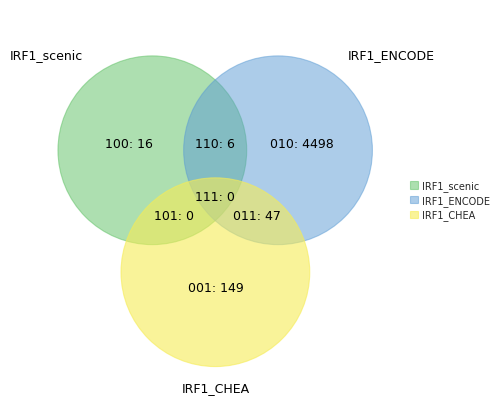

In [37]:
fig, ax = venn.venn3(labels, names=['IRF1_scenic', 'IRF1_ENCODE', 'IRF1_CHEA'], figsize=(5,5), fontsize=9, dpi=100)


In [36]:
set(sigGenes) & set(IRF1_ENCODE)

{'IRF1', 'ISOC2', 'KLF3', 'NR1H2', 'RAB8A', 'UBE4B'}

## Regulon GSVA scores in TCGA

In [1]:
from utils import * 

/bgfs/alee/chelsea/apps/anaconda3/envs/py37/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [53]:
!ls ../data/TCGA15 

ExonCounts.csv	  IntronCounts.csv     tcga_Regulon.gsva.csv
IDC_patients.txt  tcga.Cts.csv	       tcga_Regulon.ssgsea.csv
ILC_patients.txt  tcga.logNormCts.csv


In [14]:
sample = 'tcga'
keyword = 'Regulon'

gsva = pd.read_csv('../data/GSVA/{}_{}.ssgsea.csv'.format(sample, keyword), index_col=0).T # obs x var
gsva.index = (x.replace('.','-') for x in gsva.index) 
gsva.columns = [f'{x} Regulon' for x in gsva.columns]
print(len(gsva.columns),gsva.columns)

48 Index(['ATF1 Regulon', 'ATF3 Regulon', 'BHLHE40 Regulon', 'BRF2 Regulon',
       'CEBPB Regulon', 'CEBPZ Regulon', 'CREB3L4 Regulon', 'CTCF Regulon',
       'E2F1 Regulon', 'E2F2 Regulon', 'E2F4 Regulon', 'E2F6 Regulon',
       'E2F7 Regulon', 'E2F8 Regulon', 'EGR1 Regulon', 'ELF1 Regulon',
       'ELF2 Regulon', 'ELK1 Regulon', 'ESRRA Regulon', 'FOS Regulon',
       'GABPA Regulon', 'IRF1 Regulon', 'IRF3 Regulon', 'JUN Regulon',
       'JUND Regulon', 'KDM5B Regulon', 'KLF4 Regulon', 'MAZ Regulon',
       'MXI1 Regulon', 'MYC Regulon', 'NFYA Regulon', 'NFYB Regulon',
       'NR3C1 Regulon', 'RELA Regulon', 'RFX5 Regulon', 'SP1 Regulon',
       'SP2 Regulon', 'SPDEF Regulon', 'SREBF2 Regulon', 'SRF Regulon',
       'TEAD2 Regulon', 'TFDP1 Regulon', 'THAP1 Regulon', 'THAP11 Regulon',
       'USF1 Regulon', 'USF2 Regulon', 'YY1 Regulon', 'ZBTB7A Regulon'],
      dtype='object')


In [15]:
fpath = '/bgfs/alee/chelsea/projects/PublicData/adata/tcga15.h5ad'
tcga = anndata.read_h5ad(fpath)

X = tcga.X
E = np.log2(X/np.sum(X, axis=1, keepdims=True)) # sample x gene
E_df = pd.DataFrame(E, index=tcga.obs.index, columns=[f'{x} RNA' for x in tcga.var.index])

df_p = tcga.obs 
df_p = tcga.obs.join(gsva).join(E_df)

In [17]:
mpl.style.use('NaturePub')
sns.set(context='paper', style='whitegrid', palette='deep', font='sans-serif', 
font_scale=2, color_codes=True)

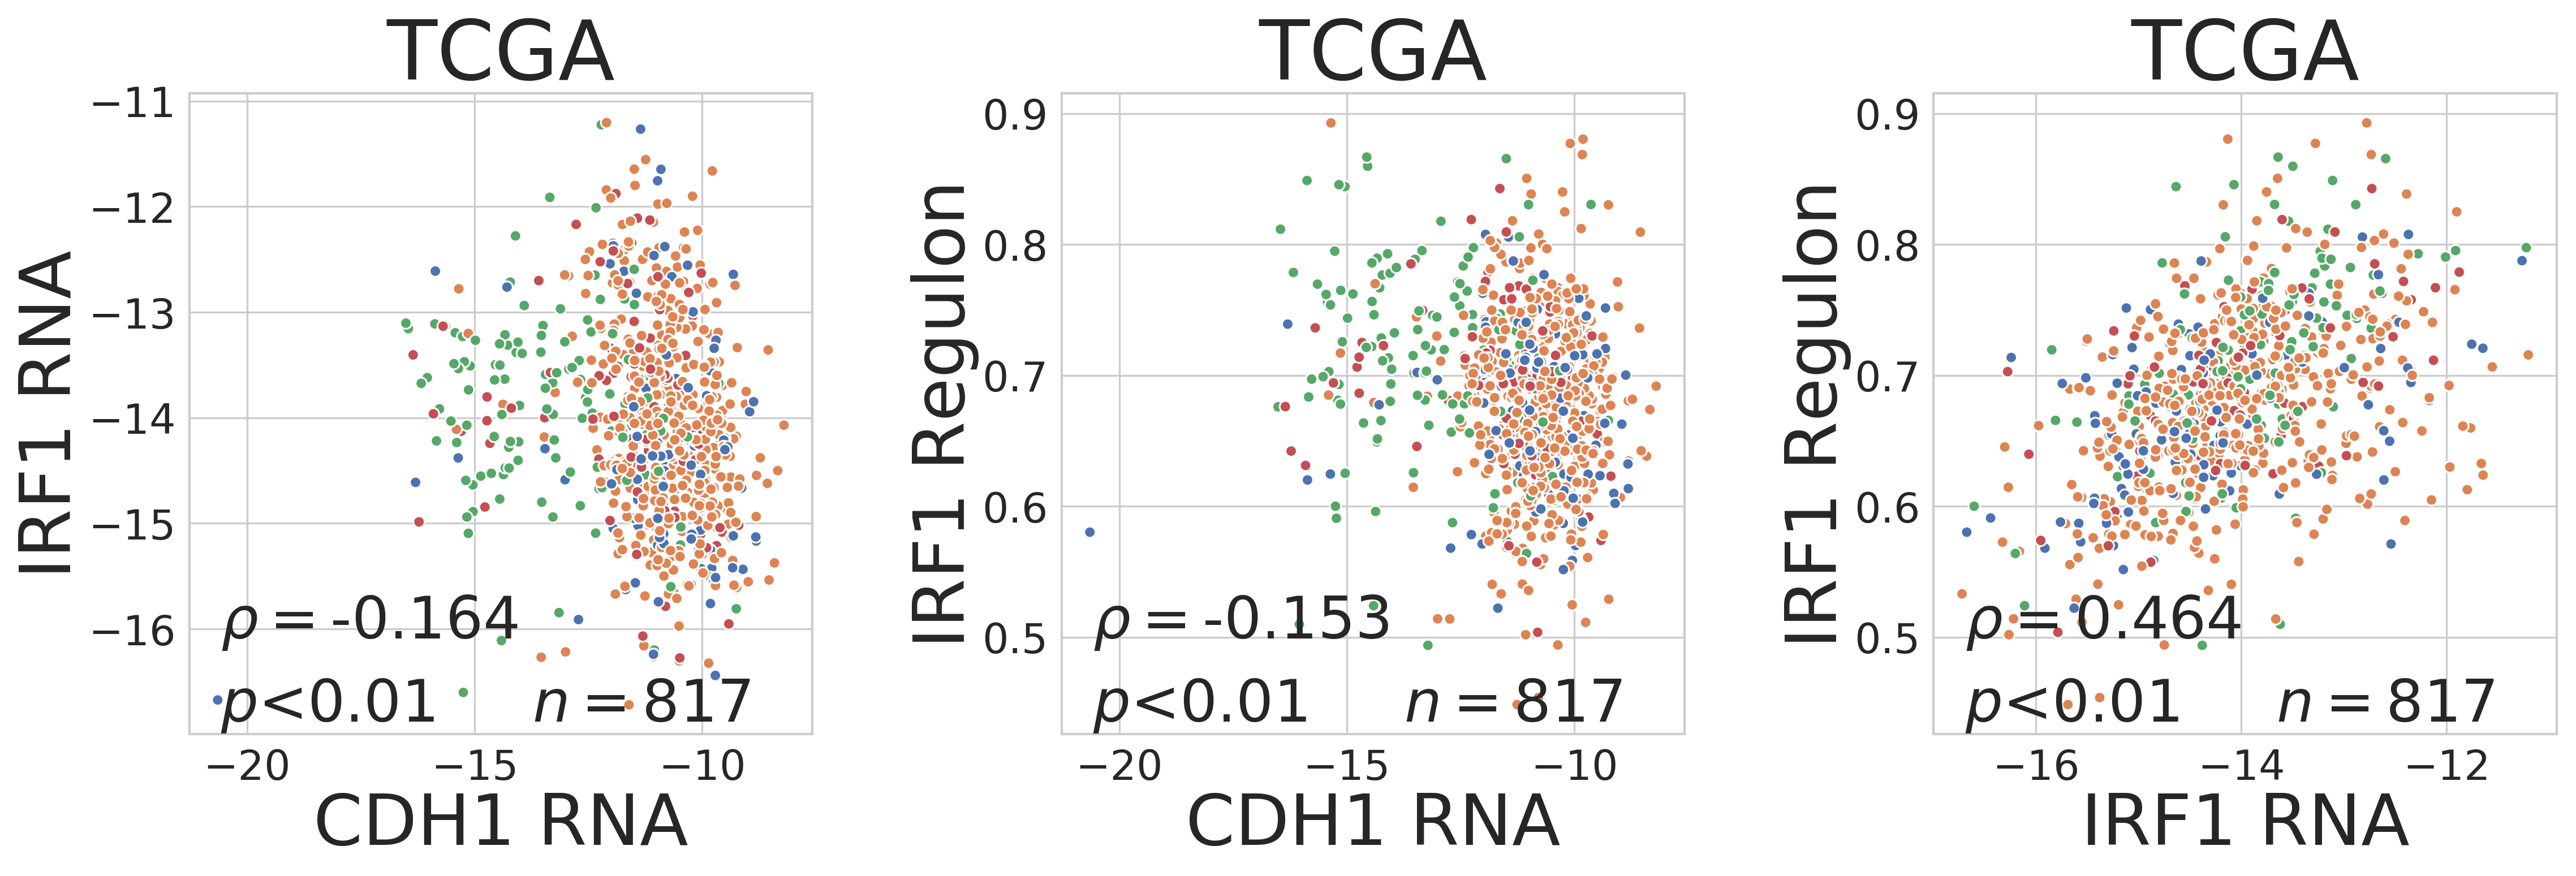

In [24]:
#restricted to LumA? 
# df_sel = df_p[df_p['PAM50'] == 'LumA']

df_sel = df_p

from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=['LumA'], ordered=True)
df_sel['PAM50'] = df_sel['PAM50'].astype(cat_type)

cats = ['CDH1 RNA', 'IRF1 RNA', 'IRF1 Regulon']
nplots = len(cats)
nrows = 1
ncols = ceil(nplots/nrows)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*6, nrows*5), dpi=300)
plt.subplots_adjust(wspace=0.4, hspace=0.8) # 
axes_list = axes.flatten()

for n, g in enumerate(cats):
    ax = axes_list[n]
    if n==0:
        g1 = 'CDH1 RNA'
        g2 = 'IRF1 RNA'
    if n==1:
        g1 = 'CDH1 RNA'
        g2 = 'IRF1 Regulon'
    if n==2:
        g1 = 'IRF1 RNA'
        g2 = 'IRF1 Regulon' 
    
    lgd = 'full' if n==nplots-1 else False 

    g = sns.scatterplot(data=df_p, x=g1, y=g2, hue='ONCOTREE_CODE', ax=ax, legend=False)

    x1 = df_sel[g1]
    x2 = df_sel[g2]    
    rho, p = pearsonr(x1,x2)

    ax.set_title('TCGA', fontsize=35)
    ax.set_xlabel(g1, fontsize=30)
    ax.set_ylabel(g2, fontsize=30)
        
    ax.text(0.55, 0.02, '${n}=$%d'%len(x1), fontsize=25, transform = ax.transAxes)

    if p < 0.01:
        ax.text(0.05, 0.15, '${\\rho}=$%.3f'%rho, fontsize=25, transform = ax.transAxes)
        ax.text(0.05, 0.02, '${p}$<0.01', fontsize=25, transform = ax.transAxes) 
        
plt.savefig('../Figure/Fig5/CoExpr_tcga_allsample.png', dpi=300, bbox_inches='tight')

# Signature Co-expression with IRF1

## TCGA

In [3]:
fpath = '../data/TCGA15/tcga15.h5ad'
tcga = anndata.read_h5ad(fpath)

X = tcga.X
E = np.log2(X/np.sum(X, axis=1, keepdims=True)) # sample x gene
E_df = pd.DataFrame(E, index=tcga.obs.index, columns=[f'{x} RNA' for x in tcga.var.index])

In [4]:
sample = 'tcga' # ssgsea using all tcga samples
method = 'ssgsea' # ssgsea
keywords = ['Regulon', 'CellCycle','h.all.v6.2.symbols']

print(keywords)

for n, keyword in enumerate(keywords):

    fpath = '../data/GSVA/{}_{}.{}.csv'.format(sample, keyword, method)
    tmp = pd.read_csv(fpath, index_col=0)
    if keyword == 'Regulon':
        tmp.index = ['%s_Regulon'%x for x in tmp.index]

    gsva = tmp if n==0 else pd.concat((gsva, tmp))
print(gsva.shape)

gsva.columns = [x.replace('.','-') for x in gsva.columns]

print(gsva.index)
gsva.tail(14)

['Regulon', 'CellCycle', 'h.all.v6.2.symbols']
(99, 817)
Index(['ATF1_Regulon', 'ATF3_Regulon', 'BHLHE40_Regulon', 'BRF2_Regulon',
       'CEBPB_Regulon', 'CEBPZ_Regulon', 'CREB3L4_Regulon', 'CTCF_Regulon',
       'E2F1_Regulon', 'E2F2_Regulon', 'E2F4_Regulon', 'E2F6_Regulon',
       'E2F7_Regulon', 'E2F8_Regulon', 'EGR1_Regulon', 'ELF1_Regulon',
       'ELF2_Regulon', 'ELK1_Regulon', 'ESRRA_Regulon', 'FOS_Regulon',
       'GABPA_Regulon', 'IRF1_Regulon', 'IRF3_Regulon', 'JUN_Regulon',
       'JUND_Regulon', 'KDM5B_Regulon', 'KLF4_Regulon', 'MAZ_Regulon',
       'MXI1_Regulon', 'MYC_Regulon', 'NFYA_Regulon', 'NFYB_Regulon',
       'NR3C1_Regulon', 'RELA_Regulon', 'RFX5_Regulon', 'SP1_Regulon',
       'SP2_Regulon', 'SPDEF_Regulon', 'SREBF2_Regulon', 'SRF_Regulon',
       'TEAD2_Regulon', 'TFDP1_Regulon', 'THAP1_Regulon', 'THAP11_Regulon',
       'USF1_Regulon', 'USF2_Regulon', 'YY1_Regulon', 'ZBTB7A_Regulon',
       'CellCycle', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_HYPOXIA',
 

TCGA-A1-A0SB  TCGA-A1-A0SD  TCGA-A1-A0SE  \
HALLMARK_P53_PATHWAY               0.412891      0.444377      0.408811   
HALLMARK_UV_RESPONSE_UP            0.365694      0.407586      0.373489   
HALLMARK_UV_RESPONSE_DN            0.514304      0.502557      0.506721   
HALLMARK_ANGIOGENESIS              0.338592      0.516888      0.433691   
HALLMARK_HEME_METABOLISM           0.297794      0.332082      0.337397   
HALLMARK_COAGULATION               0.210686      0.315031      0.293071   
HALLMARK_IL2_STAT5_SIGNALING       0.236908      0.327930      0.286632   
HALLMARK_BILE_ACID_METABOLISM      0.119836      0.187547      0.196808   
HALLMARK_PEROXISOME                0.342927      0.397735      0.410277   
HALLMARK_ALLOGRAFT_REJECTION       0.063337      0.193660      0.142468   
HALLMARK_SPERMATOGENESIS          -0.058246     -0.095675     -0.064553   
HALLMARK_KRAS_SIGNALING_UP         0.132364      0.239276      0.187291   
HALLMARK_KRAS_SIGNALING_DN        -0.087994     -0.107226     -0.110186   
HALLMARK_PANCREAS_BETA_CELLS      -0.178608     -0.057330     -0.046605   

                               TCGA-A1-A0SF  TCGA-A1-A0SH  TCGA-A1-A0SI  \
HALLMARK_P53_PATHWAY               0.420562      0.417670      0.448353   
HALLMARK_UV_RESPONSE_UP            0.395394      0.352179      0.402636   
HALLMARK_UV_RESPONSE_DN            0.457997      0.520056      0.479319   
HALLMARK_ANGIOGENESIS              0.375458      0.452003      0.428256   
HALLMARK_HEME_METABOLISM           0.320823      0.331949      0.325572   
HALLMARK_COAGULATION               0.291197      0.307978      0.308636   
HALLMARK_IL2_STAT5_SIGNALING       0.300642      0.314324      0.338231   
HALLMARK_BILE_ACID_METABOLISM      0.177612      0.191420      0.171821   
HALLMARK_PEROXISOME                0.392729      0.404124      0.395903   
HALLMARK_ALLOGRAFT_REJECTION       0.221161      0.187646      0.262605   
HALLMARK_SPERMATOGENESIS          -0.096515     -0.087345     -0.039057   
HALLMARK_KRAS_SIGNALING_UP         0.186922      0.240575      0.257653   
HALLMARK_KRAS_SIGNALING_DN        -0.113055     -0.136260     -0.124035   
HALLMARK_PANCREAS_BETA_CELLS      -0.091402     -0.082483     -0.111756   

                               TCGA-A1-A0SJ  TCGA-A1-A0SK  TCGA-A1-A0SM  \
HALLMARK_P53_PATHWAY               0.429147      0.346770      0.436908   
HALLMARK_UV_RESPONSE_UP            0.416529      0.409105      0.410263   
HALLMARK_UV_RESPONSE_DN            0.488482      0.374385      0.472371   
HALLMARK_ANGIOGENESIS              0.501317      0.341755      0.479308   
HALLMARK_HEME_METABOLISM           0.330277      0.298743      0.326864   
HALLMARK_COAGULATION               0.311544      0.115249      0.333715   
HALLMARK_IL2_STAT5_SIGNALING       0.318913      0.244727      0.305149   
HALLMARK_BILE_ACID_METABOLISM      0.219363      0.072045      0.176011   
HALLMARK_PEROXISOME                0.423270      0.330480      0.409502   
HALLMARK_ALLOGRAFT_REJECTION       0.158741      0.058717      0.168749   
HALLMARK_SPERMATOGENESIS          -0.071042      0.086957     -0.080640   
HALLMARK_KRAS_SIGNALING_UP         0.214389      0.114092      0.234123   
HALLMARK_KRAS_SIGNALING_DN        -0.131032     -0.108202     -0.127761   
HALLMARK_PANCREAS_BETA_CELLS      -0.091222      0.100923     -0.081115   

                               TCGA-A1-A0SN  ...  TCGA-LL-A5YM  TCGA-LL-A5YN  \
HALLMARK_P53_PATHWAY               0.425632  ...      0.423743      0.452009   
HALLMARK_UV_RESPONSE_UP            0.414281  ...      0.425088      0.407121   
HALLMARK_UV_RESPONSE_DN            0.451539  ...      0.298341      0.325897   
HALLMARK_ANGIOGENESIS              0.444823  ...      0.413016      0.363329   
HALLMARK_HEME_METABOLISM           0.322498  ...      0.298017      0.305084   
HALLMARK_COAGULATION               0.297411  ...      0.329343      0.306535   
HALLMARK_IL2_STAT5_SIGNALING       0.331486  ...      0.257684      0.338984   
HALLMARK_BILE

In [10]:
sel_terms = ['IRF1_Regulon', 'HALLMARK_P53_PATHWAY', 'HALLMARK_APOPTOSIS', 
             'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_TGF_BETA_SIGNALING',
             'CellCycle', 'HALLMARK_E2F_TARGETS', 'HALLMARK_G2M_CHECKPOINT']


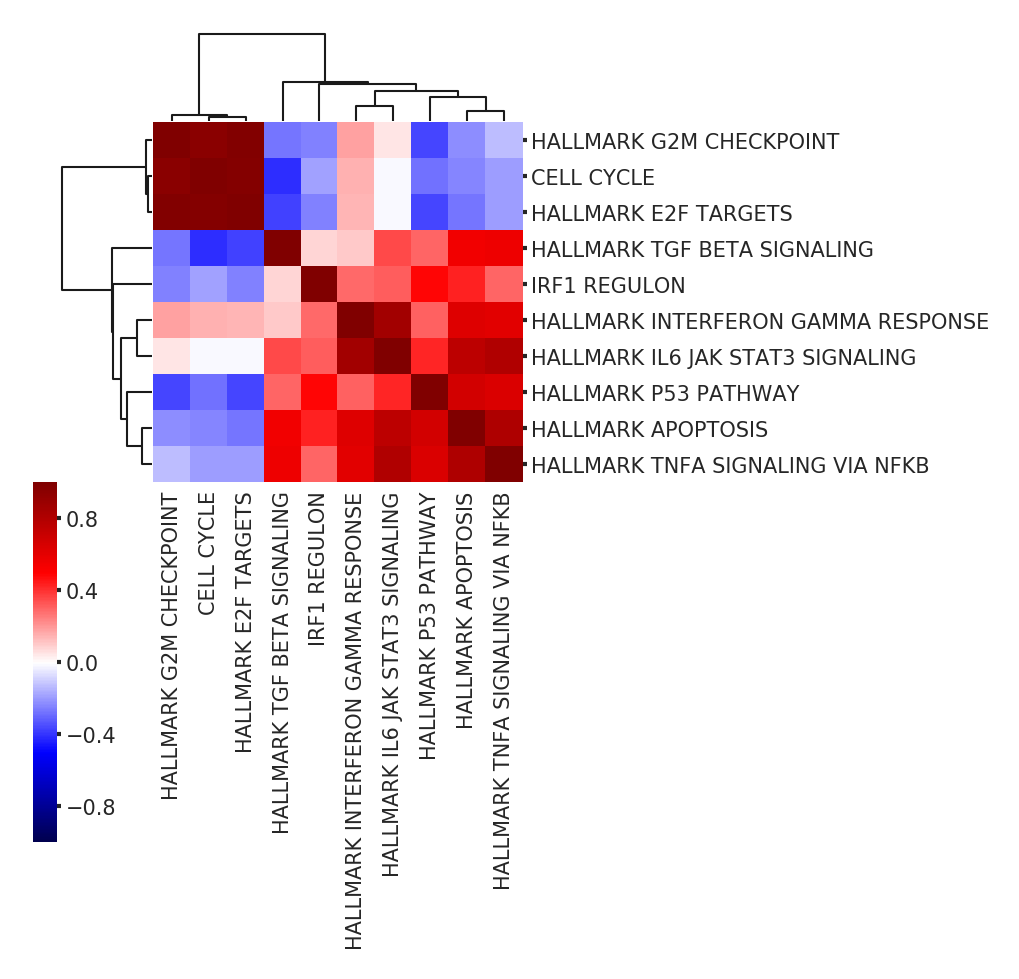

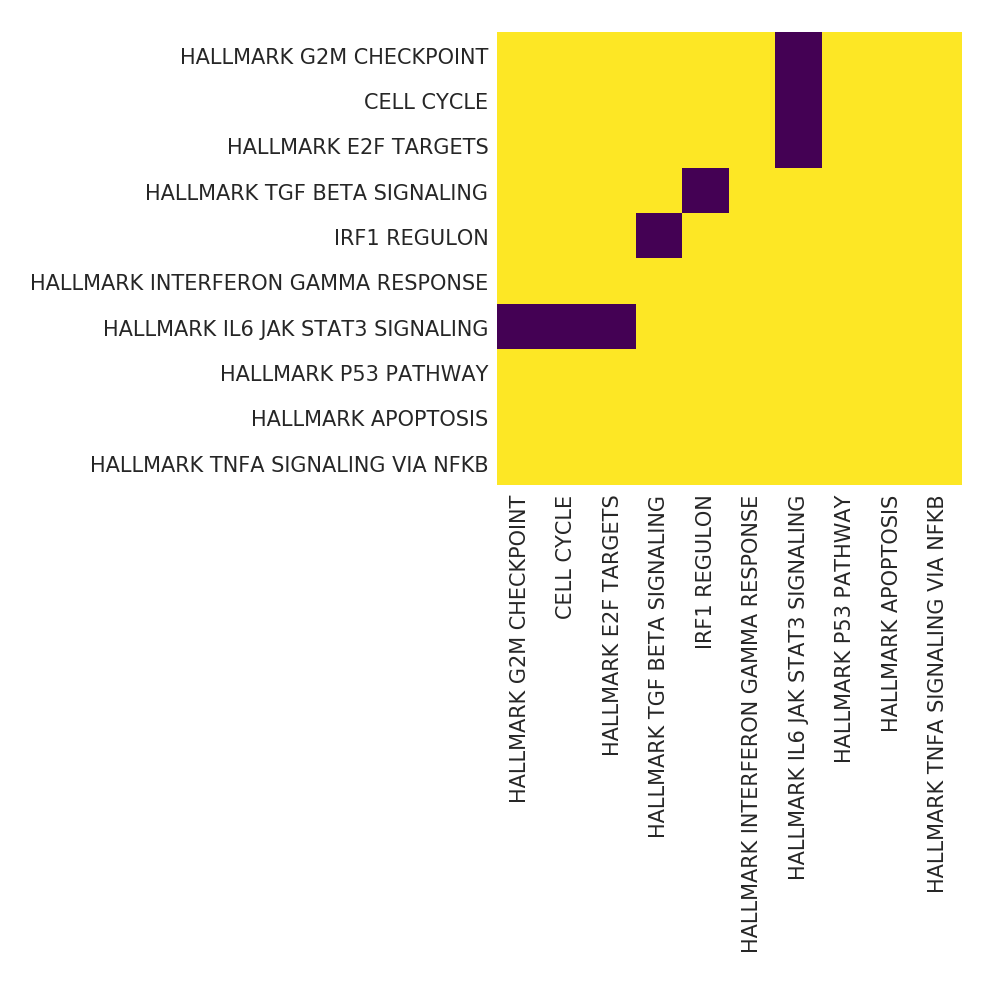

In [30]:
# gsva using all tcga samples
mpl.style.use('NaturePub') 
sns.set(context='paper', style='whitegrid', palette='deep', font='sans-serif', 
font_scale=1.5, color_codes=True)


gsva_sel = gsva.loc[sel_terms, :]
plot_keys = [x.replace('pantherFAS','panther FAS').replace('CellCycle','cell cycle').replace('_',' ').upper()
 for x in gsva_sel.index]

from scipy.stats import *    
X = gsva_sel.values
Corr = np.empty((X.shape[0], X.shape[0]))
pCorr = np.empty((X.shape[0], X.shape[0])) 

for i in range(X.shape[0]):
    for j in range(X.shape[0]):
        x, y = X[i,:], X[j,:]
        stat, p = pearsonr(x, y)
        Corr[i,j], pCorr[i,j] = stat, p

from statsmodels.stats.multitest import multipletests
fdrCorr = np.reshape(multipletests(pCorr.flatten())[1], pCorr.shape) # FDR
CorrDf = pd.DataFrame(Corr, index=plot_keys, columns=plot_keys)    
fdrCorrDf = pd.DataFrame(fdrCorr, index=plot_keys, columns=plot_keys) 

mpl.rc('figure', dpi=300)
mpl.style.use('NaturePub')
g1 = sns.clustermap(CorrDf, figsize=(2,2), cmap='seismic', vmin=-1, vmax=1)
cbar = g1.cax
x0,y0,x1,y1 = np.array(g1.ax_heatmap.get_position()).flatten()
cbar.set_position([x0-.2, y0-.6, 0.04, y1-y0])
g1.savefig('../Figure/Fig5/SigCorrHeatmap_tcga_RegulonHallmark_gsva.pdf')

xlabels = CorrDf.columns[np.array(g1.dendrogram_col.reordered_ind)]
fdrCorrDf = fdrCorrDf.loc[xlabels,xlabels]
fig = plt.figure(figsize=(2,2))
sns.heatmap(fdrCorrDf<0.1, vmin=0, vmax=1, cmap='viridis', cbar=False)
plt.savefig('../Figure/Fig5/SigCorrFdrHeatmap_tcga_RegulonHallmark_gsva.pdf')

In [5]:
df_p = tcga.obs 
df_p = tcga.obs.join(gsva.T).join(E_df)
df_p = df_p[df_p['PAM50']=='LumA'] ## Only LumA cases


In [15]:
# test
glist = sel_terms
ks_res = np.empty((len(glist), 3))

for n, g in enumerate(glist):
    x1 = df_p[g][df_p['ONCOTREE_CODE']=='ILC'].values
    x2 = df_p[g][df_p['ONCOTREE_CODE']=='IDC'].values
    x1 = x1[abs(x1) < 1e308] 
    x2 = x2[abs(x2) < 1e308] 

    stat, p = ks_2samp(x1, x2)
    sg_stat = stat if np.median(x1) > np.median(x2) else (-1)*stat
    ks_res[n,:] = [stat, sg_stat, p]
    
ks_df = pd.DataFrame(ks_res, columns=['ks','sg_ks','p'], index=glist).sort_values(by='sg_ks', ascending=False)

from statsmodels.stats.multitest import multipletests
ks_df['FDR'] = multipletests(ks_df['p'])[1] 
ks_df[ks_df['FDR']<0.05] 

ks     sg_ks         p       FDR
HALLMARK_IL6_JAK_STAT3_SIGNALING  0.275094  0.275094  0.000040  0.000397
HALLMARK_TNFA_SIGNALING_VIA_NFKB  0.266604  0.266604  0.000077  0.000691
IRF1_Regulon                      0.241226  0.241226  0.000485  0.002422
HALLMARK_P53_PATHWAY              0.207736  0.207736  0.004138  0.016449
HALLMARK_APOPTOSIS                0.202264  0.202264  0.005686  0.016963
CellCycle                         0.246981 -0.246981  0.000327  0.001961
HALLMARK_G2M_CHECKPOINT           0.262264 -0.262264  0.000106  0.000744
HALLMARK_E2F_TARGETS              0.266038 -0.266038  0.000080  0.000691

In [16]:
# mpl.style.use('NaturePub')
sns.set(context='paper', style='whitegrid', palette='deep', font='sans-serif', 
font_scale=1.2, color_codes=True)

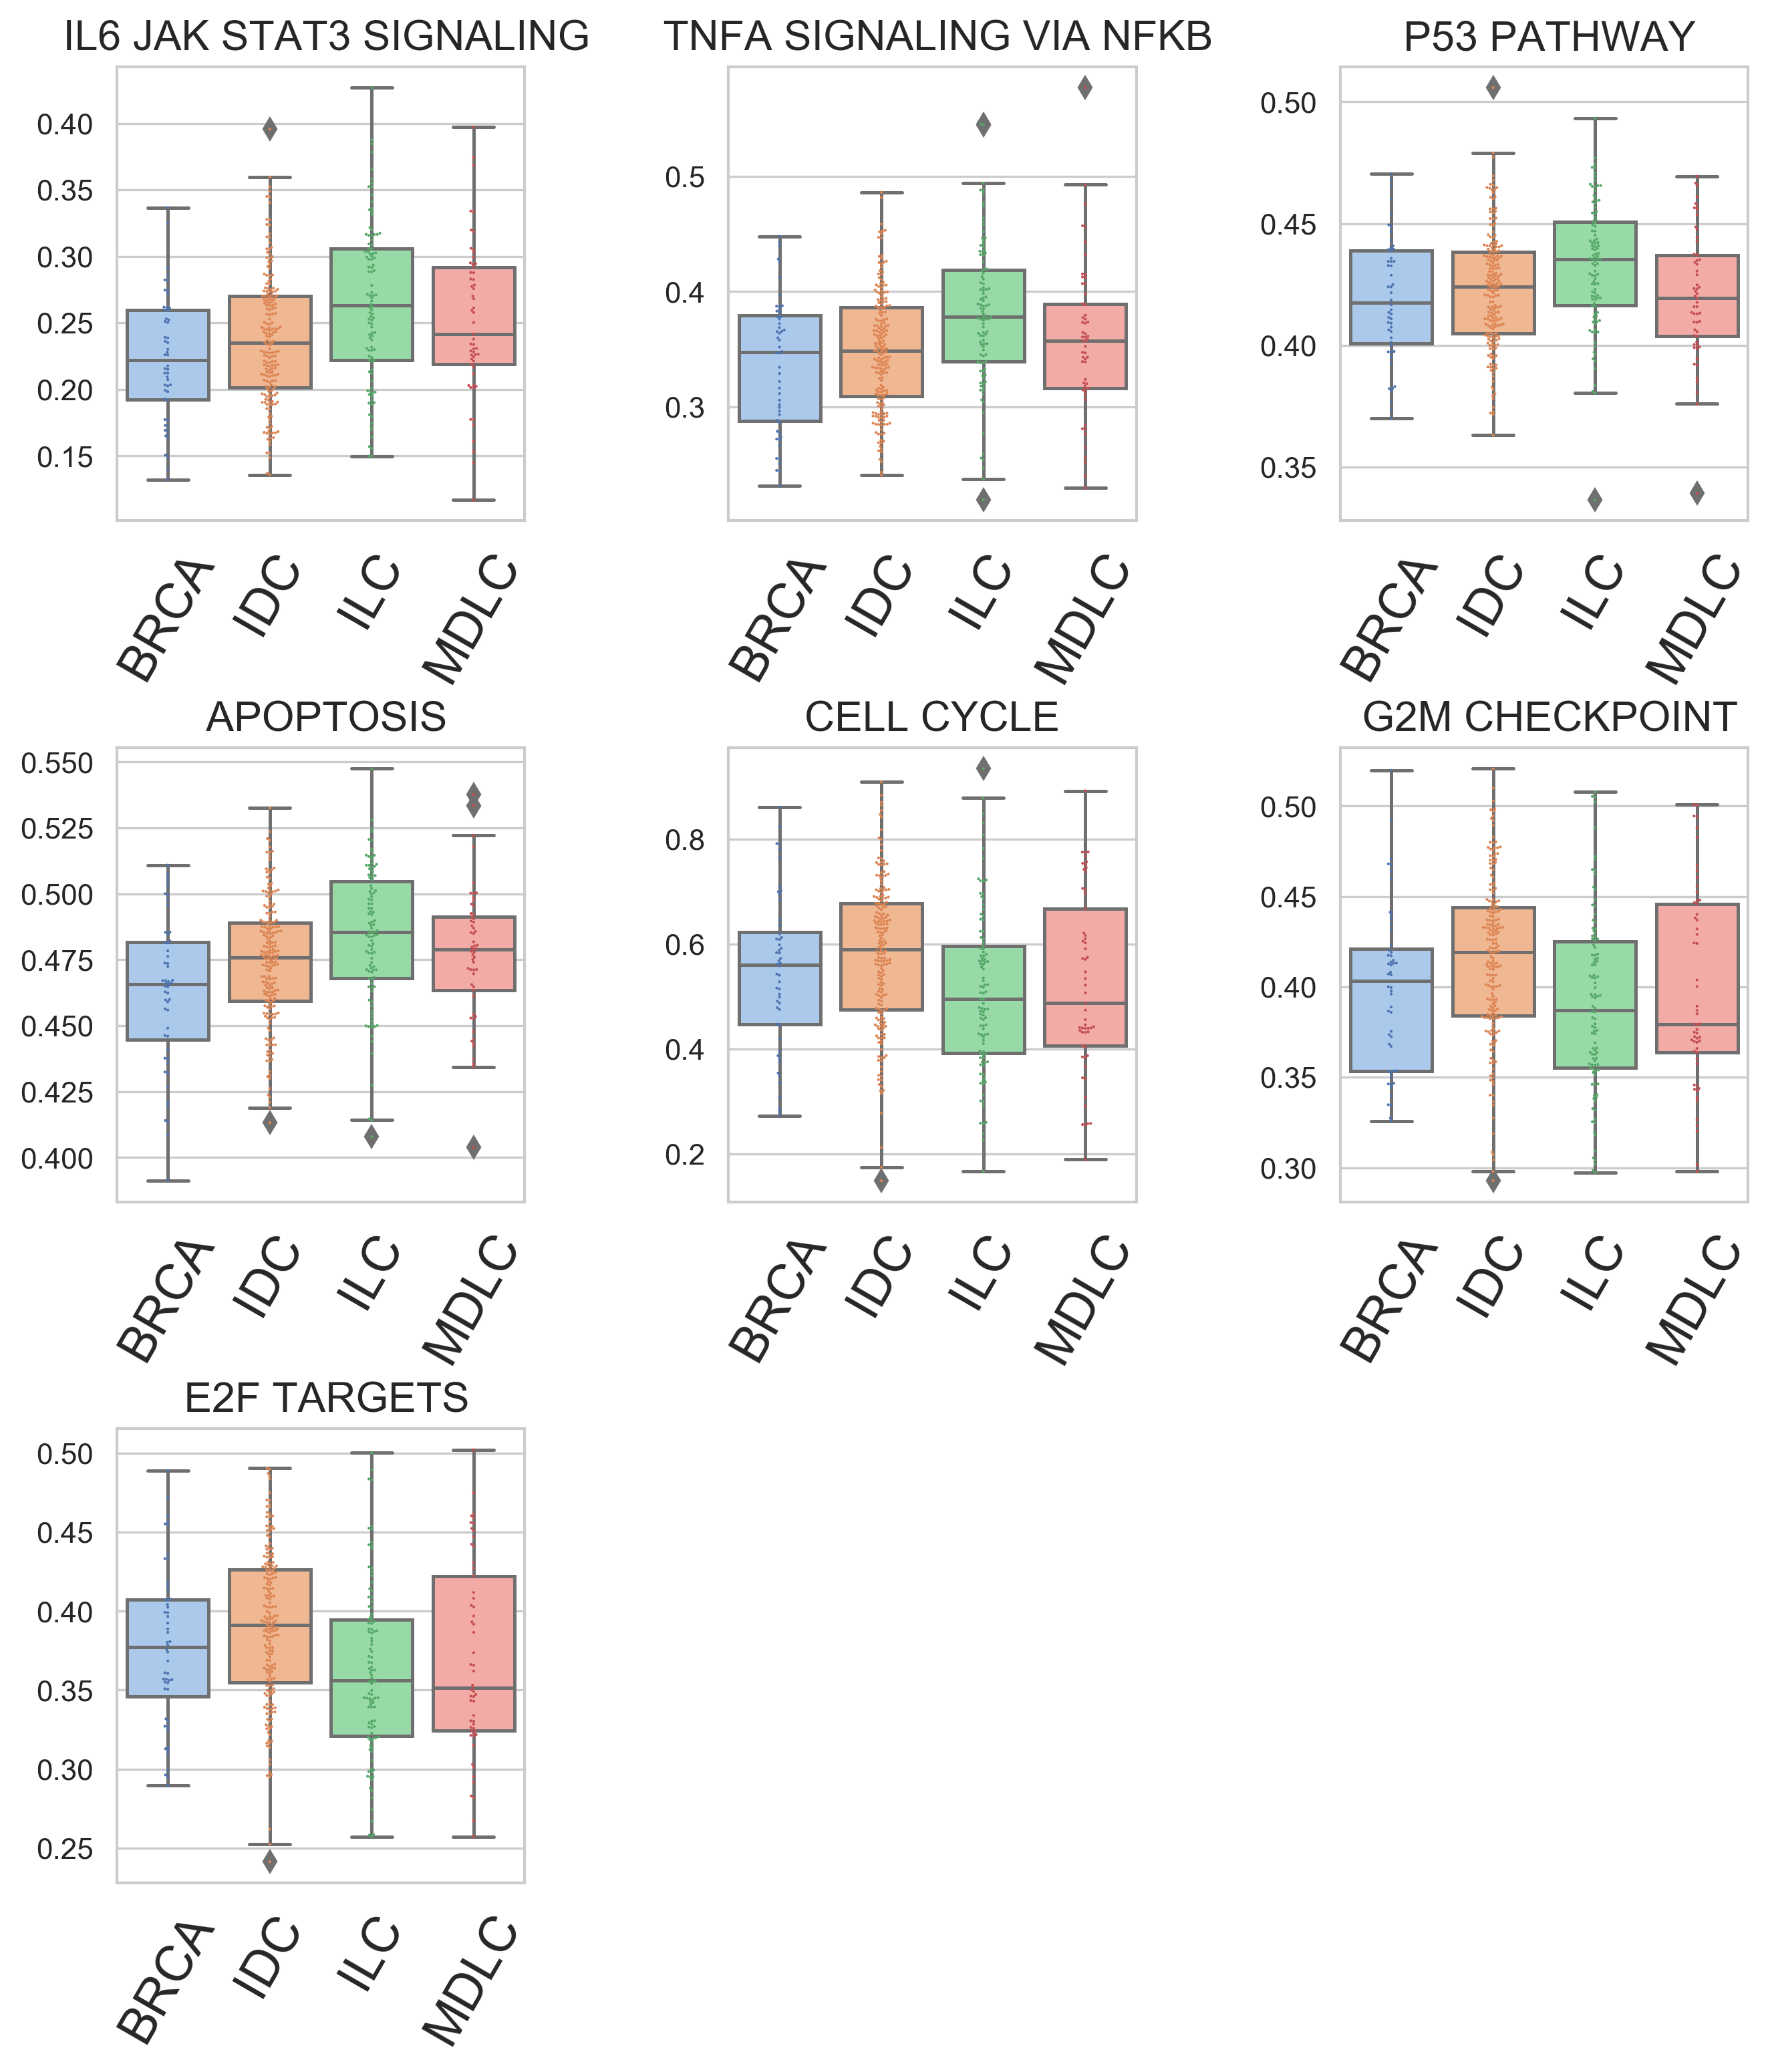

In [22]:
sel_terms = [x for x in ks_df[ks_df['FDR']<0.05].index if x != 'IRF1_Regulon']

nplots = len(sel_terms)
ncols = 3

nrows = ceil(nplots/ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3.5, nrows*4), dpi=300)
plt.subplots_adjust(wspace=0.5, hspace=.5) # 
axes_list = axes.flatten()


for n in range(len(axes_list)):

    ax = axes_list[n]
    try:
        x = sel_terms[n] 
        sns.boxplot(x='ONCOTREE_CODE', y=x, data=df_p, ax=ax, palette='pastel') 
        sns.swarmplot(x='ONCOTREE_CODE', y=x, data=df_p, s=1, ax=ax, palette='deep') 
        
        ax.set_xlabel('')
        ax.set_xticklabels(['BRCA','IDC','ILC','MDLC'],fontsize=18,rotation=60)

        ax.set_ylabel('')
        ax.set_title(x.replace('_',' ').replace('CellCycle','CELL CYCLE').strip('HALLMARK'),fontsize=15)
    except:
        ax.axis('off')
        
plt.savefig('../Figure/Fig5/tcga_CoexpressedSignatures.png', dpi=300, bbox_inches='tight')

In [9]:
from scipy.stats import ks_2samp

In [10]:
glist = ['CDH1 RNA','IRF1 RNA','IRF1_Regulon']
ks_res = np.empty((len(glist), 3))

for n, g in enumerate(glist):
    x1 = df_p[g][df_p['ONCOTREE_CODE']=='ILC'].values
    x2 = df_p[g][df_p['ONCOTREE_CODE']=='IDC'].values
    x1 = x1[abs(x1) < 1e308] 
    x2 = x2[abs(x2) < 1e308] 

    stat, p = ks_2samp(x1, x2)
    sg_stat = stat if np.median(x1) > np.median(x2) else (-1)*stat
    ks_res[n,:] = [stat, sg_stat, p]
    
ks_df = pd.DataFrame(ks_res, columns=['ks','sg_ks','p'], index=glist).sort_values(by='sg_ks', ascending=False)

from statsmodels.stats.multitest import multipletests
ks_df['FDR'] = multipletests(ks_df['p'])[1] 
ks_df[ks_df['FDR']<0.05] 

ks     sg_ks             p       FDR
IRF1 RNA      0.278302  0.278302  3.070039e-05  0.000061
IRF1_Regulon  0.241226  0.241226  4.847849e-04  0.000485
CDH1 RNA      0.737453 -0.737453  3.755825e-33  0.000000

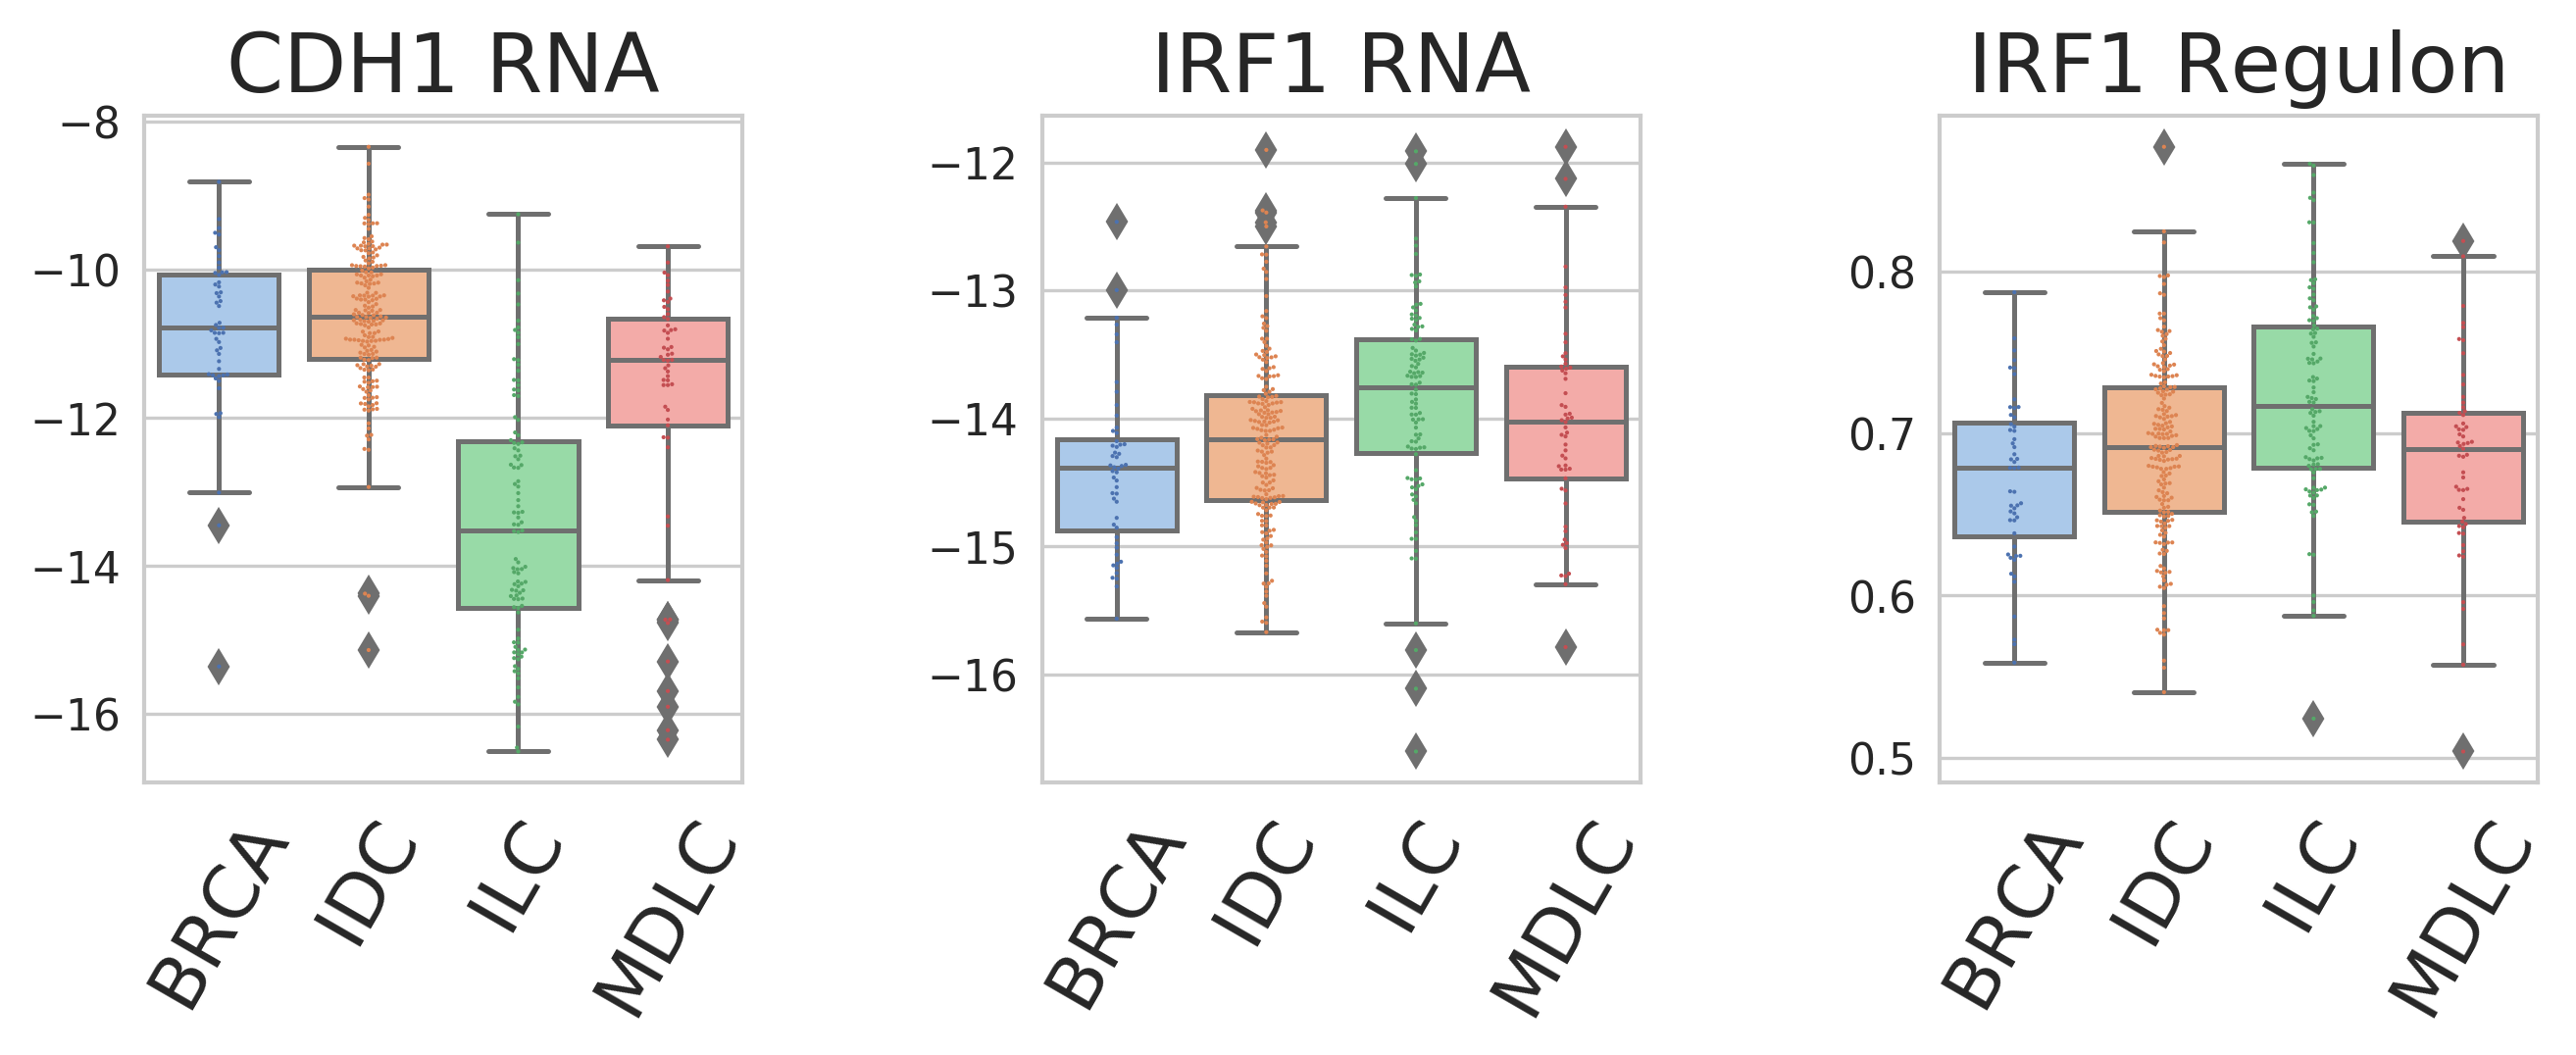

In [78]:
sel_terms = ['CDH1 RNA','IRF1 RNA','IRF1_Regulon']

nplots = len(sel_terms)
ncols = 3

nrows = ceil(nplots/ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3.5, nrows*3), dpi=300)
plt.subplots_adjust(wspace=0.5, hspace=.5) # 
axes_list = axes.flatten()


for n in range(len(axes_list)):

    ax = axes_list[n]
    try:
        x = sel_terms[n] 
        sns.boxplot(x='ONCOTREE_CODE', y=x, data=df_p, ax=ax, palette='pastel') 
        sns.swarmplot(x='ONCOTREE_CODE', y=x, data=df_p, s=1, ax=ax, palette='deep') 
        ax.set_xlabel('')
        ax.set_xticklabels(['BRCA','IDC','ILC','MDLC'],fontsize=18,rotation=60)

        ax.set_ylabel('')

        ax.set_title(x.replace('_',' '),fontsize=20)
    except:
        ax.axis('off')
        
plt.savefig('../Figure/Fig5/tcga_Gene.png', dpi=300, bbox_inches='tight')

## AL1

In [28]:
sample = 'AL1' # ssgsea using all tcga samples
method = 'gsva' # gsva
keywords = ['CellCycle','h.all.v6.2.symbols']

print(keywords)

for n, keyword in enumerate(keywords):

    fpath = '../data/GSVA/{}_{}.{}.csv'.format(sample, keyword, method)
    tmp = pd.read_csv(fpath, index_col=0)
    if keyword == 'Regulon':
        tmp.index = ['%s_Regulon'%x for x in tmp.index]

    gsva = tmp if n==0 else pd.concat((gsva, tmp))
print(gsva.shape)

gsva.columns = [x.replace('.',':') for x in gsva.columns]

print(gsva.index)
gsva.tail(14)

['CellCycle', 'h.all.v6.2.symbols']
(51, 4614)
Index(['CellCycle', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_HYPOXIA',
       'HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_MITOTIC_SPINDLE',
       'HALLMARK_WNT_BETA_CATENIN_SIGNALING', 'HALLMARK_TGF_BETA_SIGNALING',
       'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_DNA_REPAIR',
       'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_APOPTOSIS',
       'HALLMARK_NOTCH_SIGNALING', 'HALLMARK_ADIPOGENESIS',
       'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'HALLMARK_ESTROGEN_RESPONSE_LATE',
       'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_MYOGENESIS',
       'HALLMARK_PROTEIN_SECRETION', 'HALLMARK_INTERFERON_ALPHA_RESPONSE',
       'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_APICAL_JUNCTION',
       'HALLMARK_APICAL_SURFACE', 'HALLMARK_HEDGEHOG_SIGNALING',
       'HALLMARK_COMPLEMENT', 'HALLMARK_UNFOLDED_PROTEIN_RESPONSE',
       'HALLMARK_PI3K_AKT_MTOR_SIGNALING', 'HALLMARK_MTORC1_SIGNALING',
       'HALLMARK_E2F_TARGETS', 'HALLMARK_MYC_TARGETS_V1'

AL1:AAAGTGAGTCATAGTCx  AL1:AAAGAACGTAACAAGTx  \
HALLMARK_P53_PATHWAY                       -0.269955              -0.012267   
HALLMARK_UV_RESPONSE_UP                    -0.251179              -0.053067   
HALLMARK_UV_RESPONSE_DN                    -0.160640              -0.189896   
HALLMARK_ANGIOGENESIS                       0.015499              -0.209704   
HALLMARK_HEME_METABOLISM                   -0.202087              -0.086299   
HALLMARK_COAGULATION                        0.002449              -0.084166   
HALLMARK_IL2_STAT5_SIGNALING               -0.205140              -0.130275   
HALLMARK_BILE_ACID_METABOLISM              -0.112473               0.002063   
HALLMARK_PEROXISOME                        -0.293890               0.059752   
HALLMARK_ALLOGRAFT_REJECTION               -0.147496              -0.083997   
HALLMARK_SPERMATOGENESIS                   -0.147644               0.041190   
HALLMARK_KRAS_SIGNALING_UP                 -0.072062              -0.193388   
HALLMARK_KRAS_SIGNALING_DN                  0.080674              -0.009602   
HALLMARK_PANCREAS_BETA_CELLS                0.241024              -0.018275   

                               AL1:AAACGCTGTAGACACGx  AL1:AAAGGGCCAGCAATTCx  \
HALLMARK_P53_PATHWAY                       -0.112176              -0.128488   
HALLMARK_UV_RESPONSE_UP                    -0.124080               0.109257   
HALLMARK_UV_RESPONSE_DN                    -0.192895              -0.193606   
HALLMARK_ANGIOGENESIS                      -0.432257              -0.060419   
HALLMARK_HEME_METABOLISM                   -0.053401              -0.073213   
HALLMARK_COAGULATION                       -0.094029              -0.013997   
HALLMARK_IL2_STAT5_SIGNALING               -0.228302              -0.033193   
HALLMARK_BILE_ACID_METABOLISM              -0.211810              -0.080528   
HALLMARK_PEROXISOME                        -0.108089               0.015276   
HALLMARK_ALLOGRAFT_REJECTION               -0.087719               0.186852   
HALLMARK_SPERMATOGENESIS                    0.278031              -0.007149   
HALLMARK_KRAS_SIGNALING_UP                 -0.124597              -0.233473   
HALLMARK_KRAS_SIGNALING_DN                  0.067718              -0.102400   
HALLMARK_PANCREAS_BETA_CELLS                0.254744              -0.158030   

                               AL1:AACAAAGGTTGAATCCx  AL1:AAAGTGATCCCGAATAx  \
HALLMARK_P53_PATHWAY                       -0.174231               0.036886   
HALLMARK_UV_RESPONSE_UP                    -0.004917               0.079213   
HALLMARK_UV_RESPONSE_DN                    -0.231530               0.009505   
HALLMARK_ANGIOGENESIS                      -0.218260              -0.138498   
HALLMARK_HEME_METABOLISM                   -0.155262              -0.122692   
HALLMARK_COAGULATION                       -0.098604               0.332049   
HALLMARK_IL2_STAT5_SIGNALING               -0.013306               0.230155   
HALLMARK_BILE_ACID_METABOLISM              -0.032505               0.205514   
HALLMARK_PEROXISOME                        -0.060533              -0.000102   
HALLMARK_ALLOGRAFT_REJECTION                0.085526              -0.113550   
HALLMARK_SPERMATOGENESIS                   -0.026248              -0.166151   
HALLMARK_KRAS_SIGNALING_UP                 -0.235371              -0.067296   
HALLMARK_KRAS_SIGNALING_DN                 -0.118103               0.217010   
HALLMARK_PANCREAS_BETA_CELLS                0.147196               0.120855   

                               AL1:AAACGAAAGAGGATCCx  AL1:AAACGCTGTGCCCGTAx  \
HALLMARK_P53_PATHWAY                       -0.161727              -0.051759   
HALLMARK_UV_RESPONSE_UP                     0.071620              -0.062996   
HALLMARK_UV_RESPONSE_DN                    -0.340316              -0.087349   
HALLMARK_ANGIOGENESIS                      -0.398197              -0.089656   
HALLMARK_HEME_METABOLISM                   -0.120357              -0.089494   

In [29]:
df_p = gsva.T.join(AL1.obs[['CellType']])
df_p 

CellCycle  HALLMARK_TNFA_SIGNALING_VIA_NFKB  \
AL1:AAAGTGAGTCATAGTCx  -0.552250                         -0.151478   
AL1:AAAGAACGTAACAAGTx  -0.028700                         -0.219810   
AL1:AAACGCTGTAGACACGx   0.463156                         -0.271505   
AL1:AAAGGGCCAGCAATTCx   0.339022                         -0.087588   
AL1:AACAAAGGTTGAATCCx   0.092944                         -0.274129   
...                          ...                               ...   
AL1:TTTGATCGTTGCACGCx   0.332835                          0.000488   
AL1:TTTGTTGCATCAGCGCx  -0.440076                          0.078622   
AL1:TTTGGTTGTGATACAAx  -0.260945                          0.148579   
AL1:TTTGACTGTTAGTTCGx  -0.457674                          0.333394   
AL1:TTTGTTGGTGATTAGAx  -0.447562                          0.294898   

                       HALLMARK_HYPOXIA  HALLMARK_CHOLESTEROL_HOMEOSTASIS  \
AL1:AAAGTGAGTCATAGTCx         -0.155990                          0.021363   
AL1:AAAGAACGTAACAAGTx         -0.130968                          0.002993   
AL1:AAACGCTGTAGACACGx         -0.274538                          0.039580   
AL1:AAAGGGCCAGCAATTCx         -0.214628                          0.137900   
AL1:AACAAAGGTTGAATCCx         -0.177605                          0.150566   
...                                 ...                               ...   
AL1:TTTGATCGTTGCACGCx         -0.034170                          0.057333   
AL1:TTTGTTGCATCAGCGCx          0.123570                         -0.024690   
AL1:TTTGGTTGTGATACAAx          0.004342                          0.104806   
AL1:TTTGACTGTTAGTTCGx          0.041767                          0.087093   
AL1:TTTGTTGGTGATTAGAx          0.272573                          0.172445   

                       HALLMARK_MITOTIC_SPINDLE  \
AL1:AAAGTGAGTCATAGTCx                 -0.354617   
AL1:AAAGAACGTAACAAGTx                 -0.207226   
AL1:AAACGCTGTAGACACGx                  0.001840   
AL1:AAAGGGCCAGCAATTCx                 -0.056530   
AL1:AACAAAGGTTGAATCCx                 -0.155184   
...                                         ...   
AL1:TTTGATCGTTGCACGCx                 -0.056013   
AL1:TTTGTTGCATCAGCGCx                 -0.237641   
AL1:TTTGGTTGTGATACAAx                 -0.141209   
AL1:TTTGACTGTTAGTTCGx                 -0.132333   
AL1:TTTGTTGGTGATTAGAx                 -0.100886   

                       HALLMARK_WNT_BETA_CATENIN_SIGNALING  \
AL1:AAAGTGAGTCATAGTCx                            -0.201415   
AL1:AAAGAACGTAACAAGTx                            -0.435220   
AL1:AAACGCTGTAGACACGx                            -0.037036   
AL1:AAAGGGCCAGCAATTCx                             0.055477   
AL1:AACAAAGGTTGAATCCx                            -0.052184   
...                                                    ...   
AL1:TTTGATCGTTGCACGCx                            -0.123393   
AL1:TTTGTTGCATCAGCGCx                            -0.018703   
AL1:TTTGGTTGTGATACAAx                            -0.273098   
AL1:TTTGACTGTTAGTTCGx                            -0.136723   
AL1:TTTGTTGGTGATTAGAx                             0.149688   

                       HALLMARK_TGF_BETA_SIGNALING  \
AL1:AAAGTGAGTCATAGTCx                    -0.236320   
AL1:AAAGAACGTAACAAGTx                    -0.259204   
AL1:AAACGCTGTAGACACGx                    -0.289923   
AL1:AAAGGGCCAGCAATTCx                    -0.150783   
AL1:AACAAAGGTTGAATCCx                    -0.151047   
...                                            ...   
AL1:TTTGATCGTTGCACGCx                    -0.233108   
AL1:TTTGTTGCATCAGCGCx                    -0.176517   
AL1:TTTGGTTGTGATACAAx                    -0.065586   
AL1:TTTGACTGTTAGTTCGx                     0.045642   
AL1:TTTGTTGGTGATTAGAx                     0.002278   

                       HALLMARK_IL6_JAK_STAT3_SIGNALING  HALLMARK_DNA_REPAIR  \
AL1:AAAGTGAGTCATAGTCx                         -0.209312            -0.205373   
AL1:AAAGAACGTAACAAGTx                         -0.264800             0.084908   
AL1:AAACGC

In [30]:
# test
sel_terms = ['HALLMARK_P53_PATHWAY', 'HALLMARK_APOPTOSIS', 
             'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_TGF_BETA_SIGNALING',
             'CellCycle', 'HALLMARK_E2F_TARGETS', 'HALLMARK_G2M_CHECKPOINT']
glist = sel_terms 
ks_res = np.empty((len(glist), 3))

for n, g in enumerate(glist):
    x1 = df_p[g][df_p['CellType']=='T47D KO'].values
    x2 = df_p[g][df_p['CellType']=='T47D WT'].values
    x1 = x1[abs(x1) < 1e308] 
    x2 = x2[abs(x2) < 1e308] 

    stat, p = ks_2samp(x1, x2)
    sg_stat = stat if np.median(x1) > np.median(x2) else (-1)*stat
    ks_res[n,:] = [stat, sg_stat, p]
    
ks_df = pd.DataFrame(ks_res, columns=['ks','sg_ks','p'], index=glist).sort_values(by='sg_ks', ascending=False)

from statsmodels.stats.multitest import multipletests
ks_df['FDR'] = multipletests(ks_df['p'])[1] 
ks_df[ks_df['FDR']<0.05] 

ks     sg_ks             p  \
HALLMARK_TNFA_SIGNALING_VIA_NFKB  0.245876  0.245876  8.970602e-14   
HALLMARK_P53_PATHWAY              0.233388  0.233388  1.925238e-12   
HALLMARK_TGF_BETA_SIGNALING       0.125557  0.125557  6.648068e-04   
HALLMARK_APOPTOSIS                0.098816  0.098816  1.380343e-02   
CellCycle                         0.140181 -0.140181  9.305127e-05   
HALLMARK_E2F_TARGETS              0.181779 -0.181779  1.050203e-07   
HALLMARK_G2M_CHECKPOINT           0.191818 -0.191818  1.563397e-08   

                                           FDR  
HALLMARK_TNFA_SIGNALING_VIA_NFKB  8.073542e-13  
HALLMARK_P53_PATHWAY              1.540190e-11  
HALLMARK_TGF_BETA_SIGNALING       2.656577e-03  
HALLMARK_APOPTOSIS                4.084133e-02  
CellCycle                         4.651698e-04  
HALLMARK_E2F_TARGETS              6.301215e-07  
HALLMARK_G2M_CHECKPOINT           1.094378e-07

In [31]:
mpl.style.use('NaturePub')
sns.set(context='paper', style='whitegrid', palette='deep', font='sans-serif', 
font_scale=1.2, color_codes=True)

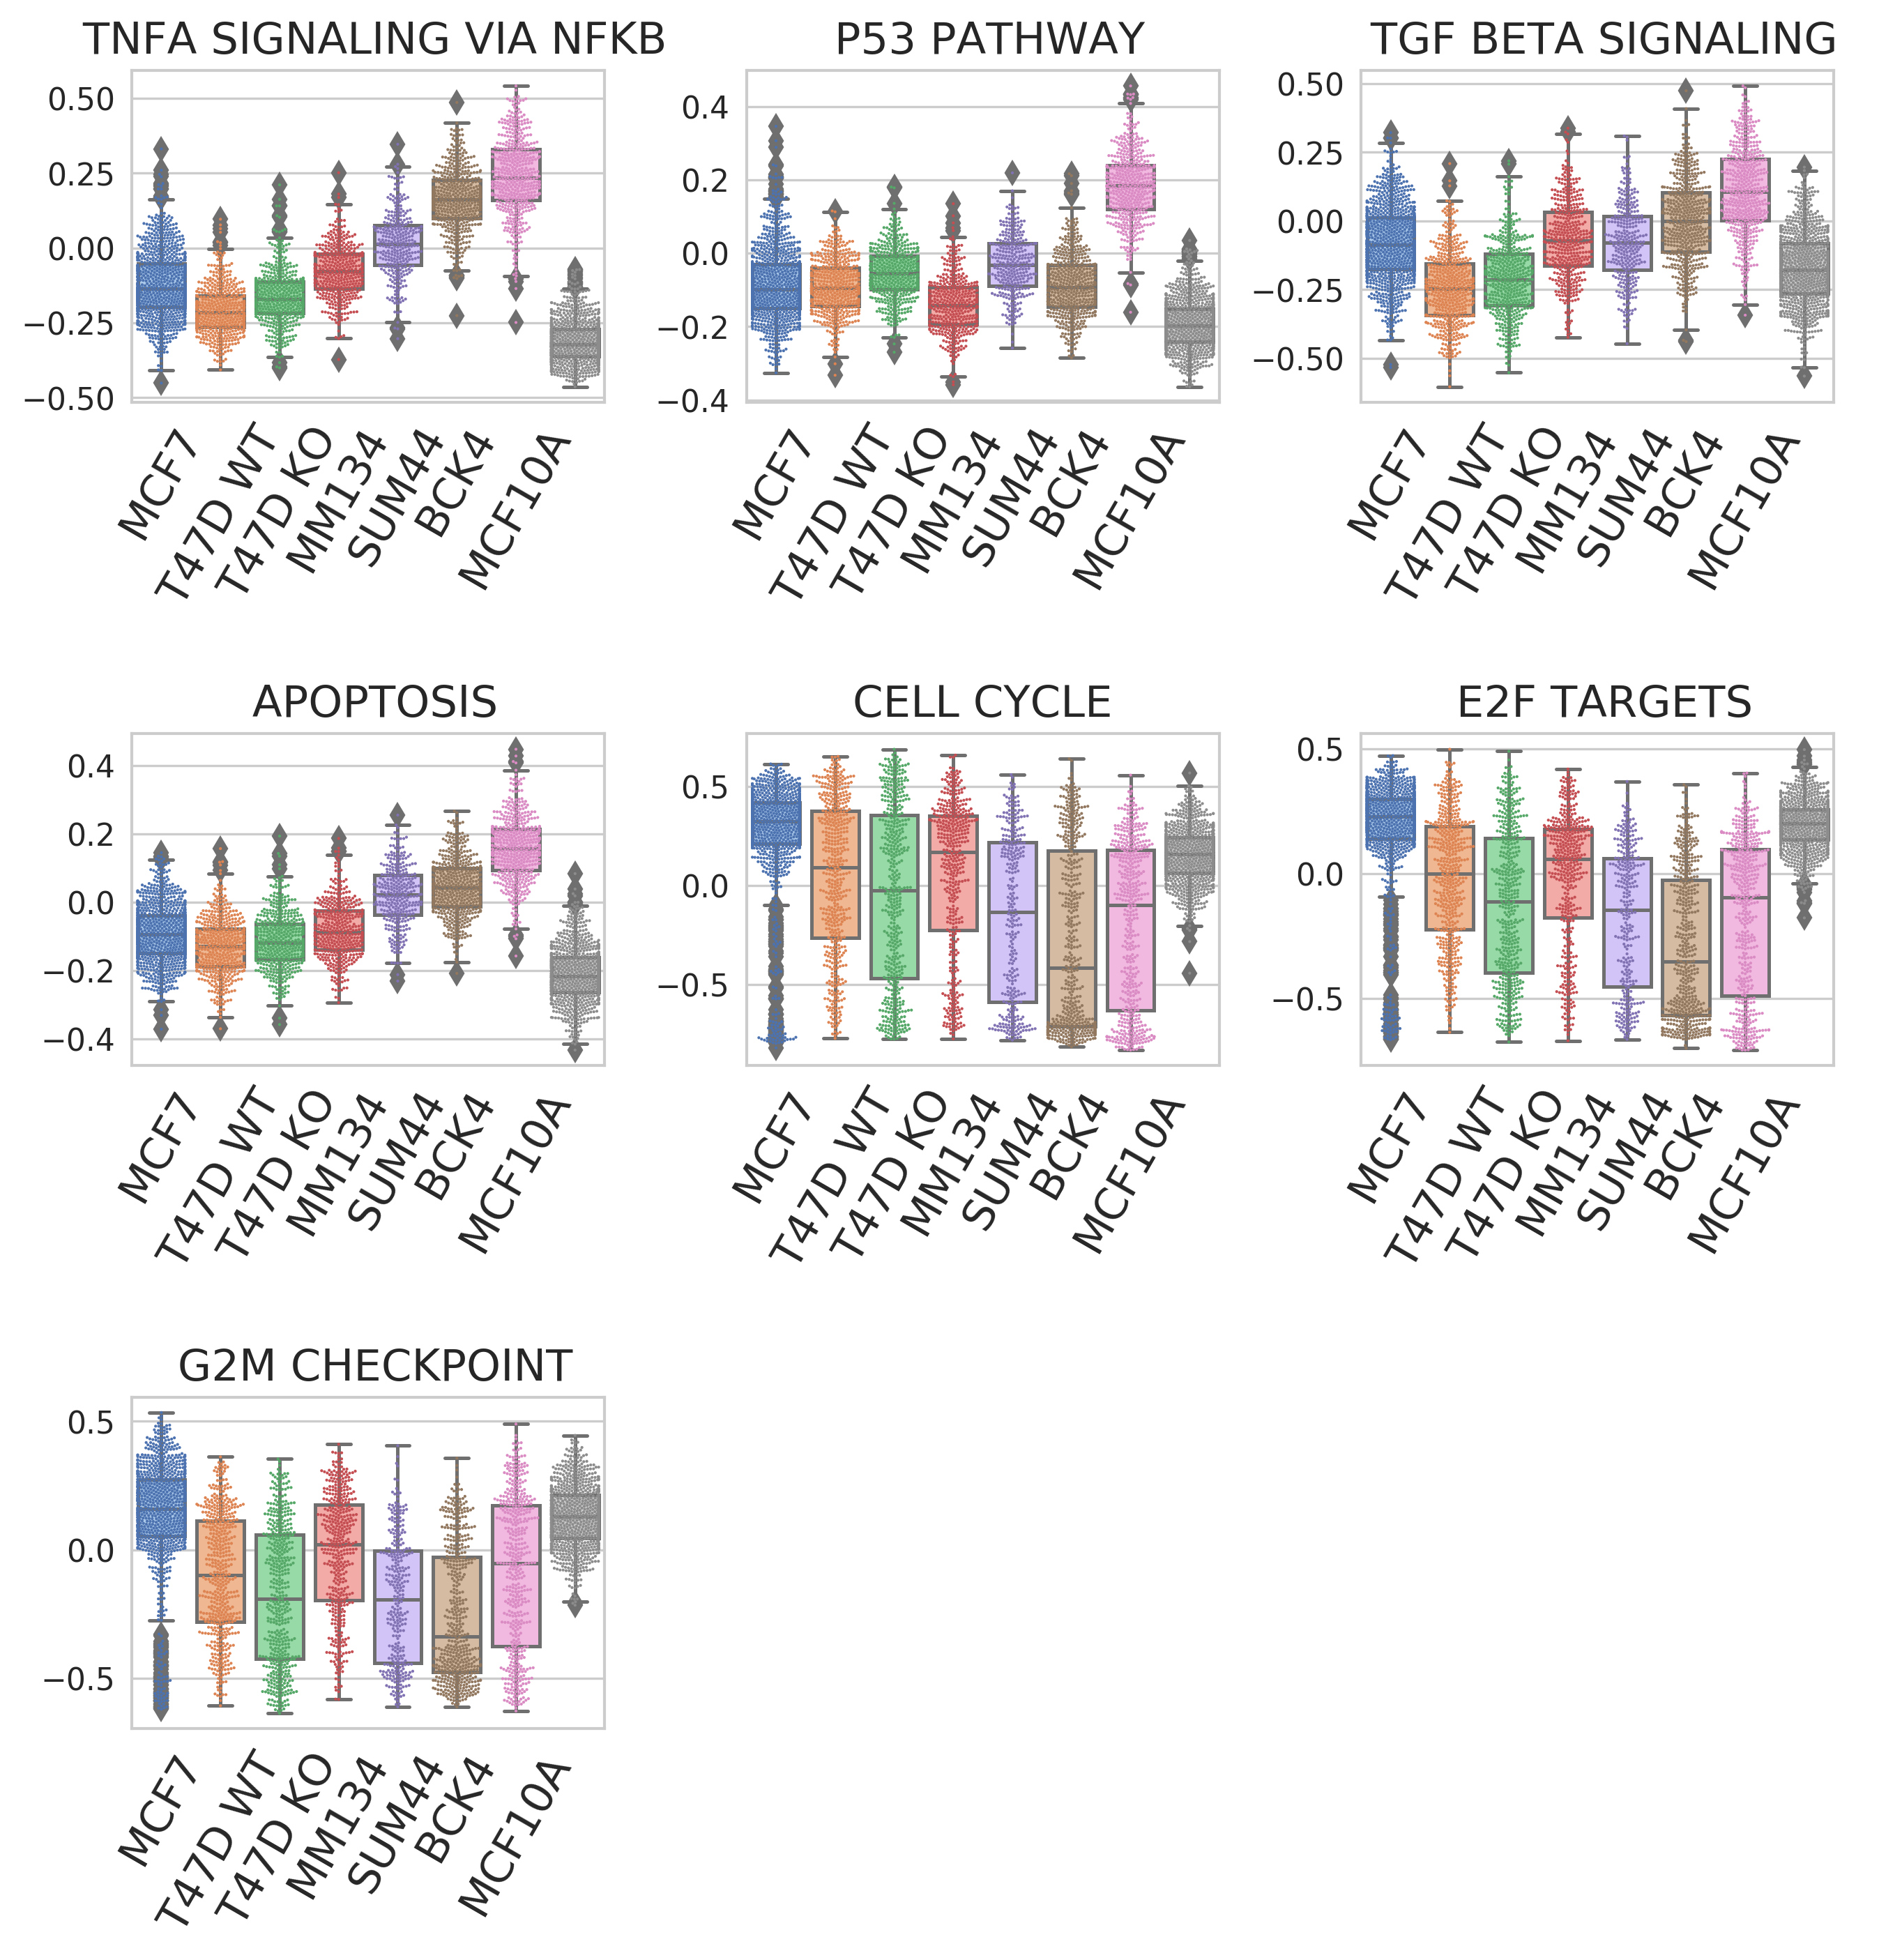

In [32]:
sel_terms = [x for x in ks_df[ks_df['FDR']<0.05].index if x != 'IRF1_Regulon']
CellTypes = ['MCF7','T47D WT','T47D KO',  'MM134','SUM44','BCK4',  'MCF10A'] 

nplots = len(sel_terms)
ncols = 3 

nrows = ceil(nplots/ncols)
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3.5, nrows*3.5), dpi=300)
plt.subplots_adjust(wspace=0.3, hspace=1) # 
axes_list = axes.flatten()


for n in range(len(axes_list)):

    ax = axes_list[n]
    try:
        x = sel_terms[n] 
        sns.boxplot(x='CellType', y=x, data=df_p, ax=ax, palette='pastel') 
        sns.swarmplot(x='CellType', y=x, data=df_p, s=1, ax=ax, palette='deep') 
        
        ax.set_xlabel('')
        ax.set_xticklabels(CellTypes,fontsize=15,rotation=60)

        ax.set_ylabel('')
        ax.set_title(x.replace('_',' ').replace('CellCycle','CELL CYCLE').strip('HALLMARK'),fontsize=15)
    except:
        ax.axis('off')
        
plt.savefig('../Figure/Fig5/AL1_CoexpressedSignatures.png', dpi=300, bbox_inches='tight')